# Imports

In [2]:
%load_ext autoreload
%autoreload 2

# og python libs
import re
import os
import pprint
import itertools
from typing import Tuple, List, Dict, Pattern, Any


# classic DS libs
import pandas as pd
import numpy as np

# viz libs
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager as font_manager
from ipywidgets import interact, fixed, interact_manual

# scipy
from scipy.integrate import quad
from scipy.signal import find_peaks, peak_widths, find_peaks_cwt
from scipy.constants import k as k_B
from scipy.constants import c, pi, N_A, h, hbar, m_e, m_p

# lmfit things
from lmfit.models import LinearModel, GaussianModel, VoigtModel, SplineModel, ExponentialModel, ExpressionModel, Model, ConstantModel
from lmfit import Parameter, Parameters
from lmfit import minimize, minimizer

# ML
from sklearn.linear_model import LinearRegression

# GenAI
from google import genai
from google.genai import types

# natural data databases
import hapi
DB_PATH = 'hapi_data'
hapi.db_begin(DB_PATH)

# API setups
G_MODEL_ID = "gemini-2.5-flash-preview-05-20"
G_API_KEY = os.environ.get("GEMINI_API_KEY")
G_CLIENT = genai.Client(api_key=G_API_KEY)

response = G_CLIENT.models.generate_content(
    model=G_MODEL_ID,
    contents="test",
)

print(response.text)

pp = pprint.PrettyPrinter(depth=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using hapi_data

H2O
                     Lines parsed: 9
Hello! How can I help you today?


In [3]:
# custom
import sys
sys.path.append('..')
from my_utils import defs as cp
from my_utils.classes import CEPAS_measurement, CEPAS_benchmark, CEPAS_noise_info, CEPAS_SNR_bench
cp.hello_test()

Hello!


# tests

In [4]:
T = 292.15
P_atm = 0.9
wavenumber_axis = np.linspace(6983.4, 6984, 1000)
params = cp.get_n_strongest('h2o', 18.015e-3, 6983.4, 6983.8, 1)[0]
hwhm_g = cp.gaussian_hwhm(params['v0'], T, params['M'])
sigma_g = hwhm_g / np.sqrt(2 * np.log(2))
gamma_l = cp.lorentzian_hwhm(P_atm, T, params['gamma_L0'], params['T0'], params['n_exp'])
data = cp.get_voigt(params['v0'], sigma_g, gamma_l, wavenumber_axis)
print(type(np.where(data == data.max())))


Data is fetched from http://hitran.org

BEGIN DOWNLOAD: H2O
  65536 bytes written to hapi_data/H2O.data
Header written to hapi_data/H2O.header
END DOWNLOAD
                     Lines parsed: 9
PROCESSED
--- Fetched H2O Line Parameters from HITRAN ---
v0: 6983.667843
gamma_L0: 0.0905
n_exp: 0.73
T0: 296.0
P0: 1.0
M: 0.018015
<class 'tuple'>


3.83027428613938
(array([255.12230805]), array([2.08226874]), array([318.39745738]), array([573.51976543]))
0.16696696696726576


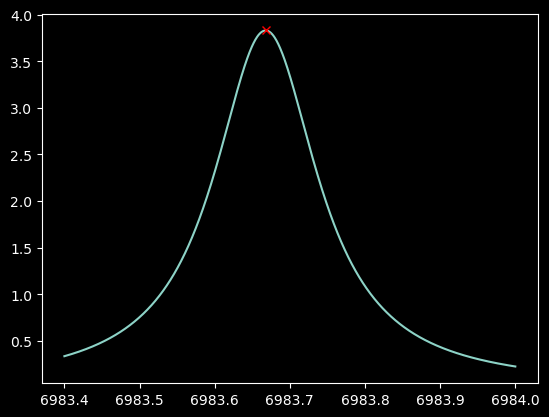

In [5]:
peaks, _ = find_peaks(data)
width = peak_widths(data, peaks, 0.5)
print(data.max())
print(width)
print(cp.get_fwhm_theory(wavenumber_axis, data))
plt.plot(wavenumber_axis, data)
plt.plot(wavenumber_axis[peaks], data[peaks], 'rx')
plt.show()

In [6]:
prompt = "a function that returns the result of 13^2"
test = cp.defai(prompt, "onesixnine")
test

Stripped!


'def onesixnine() -> int:\n    """\n    Calculates and returns the result of 13 raised to the power of 2 (13 squared).\n\n    This function does not take any arguments and simply returns the fixed\n    mathematical result of 13 * 13.\n\n    Returns:\n        int: The integer result of 13^2, which is 169.\n    """\n    return 13**2'

In [7]:
exec(test) # type: ignore
onesixnine() # type: ignore  # noqa: F821


169

In [8]:
cp.askai("Hello how are you?")

"Hello! I'm doing great, thank you for asking.\n\nHow are you today?"

In [9]:
path = './datas/full_tests/'
path2 = './datas/freq_tests/1/'
freq_list = [20, 32, 42, 74, 98, 130, 171, 227, 300]
for i in freq_list:
    test_pattern = re.compile(f".+600_51_{i}.+")
    print(cp.dir_match(path2, test_pattern))

['gasx_600_51_20__msr__0', 'gasx_600_51_20__msr__1', 'gasx_600_51_20__msr__2']
['gasx_600_51_32__msr__3', 'gasx_600_51_32__msr__4', 'gasx_600_51_32__msr__5']
['gasx_600_51_42__msr__6', 'gasx_600_51_42__msr__7', 'gasx_600_51_42__msr__8']
['gasx_600_51_74__msr__10', 'gasx_600_51_74__msr__11', 'gasx_600_51_74__msr__9']
['gasx_600_51_98__msr__12', 'gasx_600_51_98__msr__13', 'gasx_600_51_98__msr__14']
['gasx_600_51_130__msr__15', 'gasx_600_51_130__msr__16', 'gasx_600_51_130__msr__17']
['gasx_600_51_171__msr__18', 'gasx_600_51_171__msr__19', 'gasx_600_51_171__msr__20']
['gasx_600_51_227__msr__21', 'gasx_600_51_227__msr__22', 'gasx_600_51_227__msr__23']
['gasx_600_51_300__msr__24', 'gasx_600_51_300__msr__25', 'gasx_600_51_300__msr__26']


# For analysis

## 16.05.2025 Single point test data analysis

/tmp/ipykernel_2291/2168176887.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  single_point_test = pd.read_csv("./datas/point_tests/point0", sep=r'\s+', header=None, names=list(col_names.values()), index_col=False)


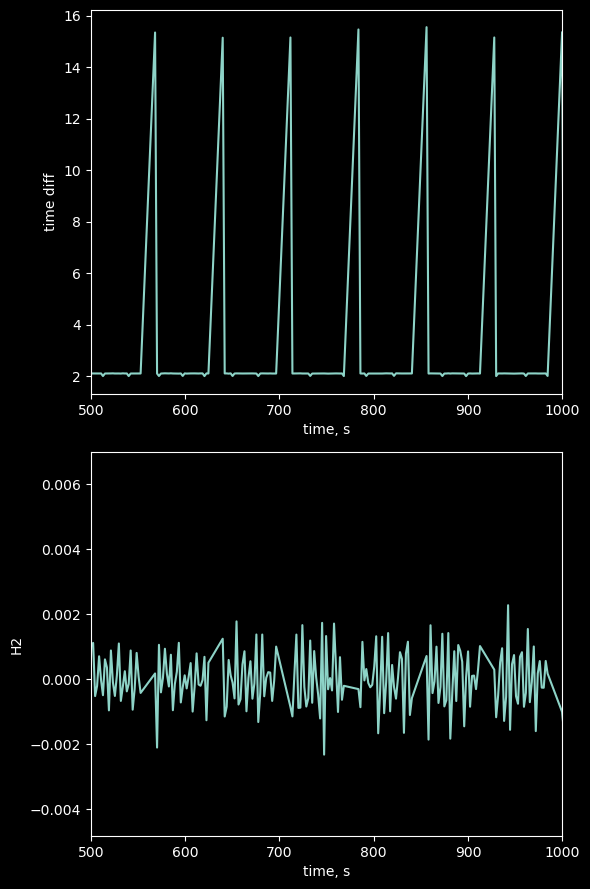

In [10]:
col_names = {
    0: 'time',          # time (measurement tick, stopped on gasx, arbitrary)
    1: 'offset1',       # DFB offset-1
    2: 'P1',            # onboard pressure sensor (blue tube)
    3: 'H3',            # 3rd harmonic (L1H1)
    4: 'H2',            # 2nd harmonic (L1H2)
    5: 'P_las',         # laser power (some volts)
    6: 'T_las',         # diode temp (Kelvin)
    7: 'RH',            # humidity sensor (external)
    8: 'Pressure'       # sensor (external)
}

single_point_test = pd.read_csv("./datas/point_tests/point0", sep=r'\s+', header=None, names=list(col_names.values()), index_col=False)
single_point_test_gasx = pd.read_csv("./datas/point_tests/point_gasx_2", sep=r'\s+', header=None, names=list(col_names.values()), index_col=False)



df_single_diff = single_point_test_gasx.iloc[1:,:].copy().diff(axis=0, periods=1)
df_single = single_point_test_gasx.iloc[1:,:].copy()

# df_single['time'] -= df_single['time'].min()
plt.figure(figsize=(6, 9))
plt.subplot(211)
plt.plot(df_single['time'], df_single_diff['time'])
# plt.hlines(y=[df_single_diff['H2'].mean(), df_single_diff['H2'].mean() - df_single_diff['H2'].std(), df_single_diff['H2'].mean() + df_single_diff['H2'].std()], xmin=0, xmax=4000, colors=['black', 'red', 'red'])
plt.xlim(500, 1000)
plt.xlabel("time, s")
plt.ylabel("time diff")

plt.subplot(212)
plt.plot(df_single['time'], df_single_diff['H2'])
# plt.hlines(y=[df_single_diff['H2'].mean(), df_single_diff['H2'].mean() - df_single_diff['H2'].std(), df_single_diff['H2'].mean() + df_single_diff['H2'].std()], xmin=0, xmax=4000, colors=['black', 'red', 'red'])
plt.xlim(500, 1000)
plt.xlabel("time, s")
plt.ylabel("H2")

plt.tight_layout()
plt.show()

# $p_{cell}\approx300\ \text{[mbar]}$

Index(['time', 'offset1', 'P1', 'H3', 'H2', 'P_las', 'T_las', 'RH', 'Pressure',
       'time_subtracted', 'H2_pnorm', 'H3_pnorm'],
      dtype='object')


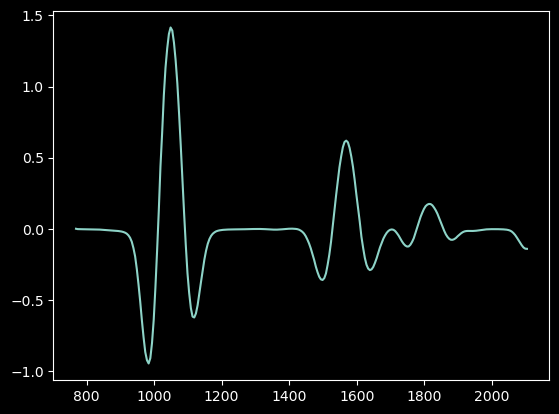

In [11]:
path_sig = "gasx2__msr__"
cm1 = CEPAS_measurement(path, path_sig, col_names)
# cm1.water_plot()
cm1_avg = cm1.avg()
print(cm1_avg.columns)
plt.plot(cm1_avg['offset1'], cm1_avg['H2_pnorm'])
plt.show()


# $p_{cell}\approx600\ \text{[mbar]}$

After closer inspection, seems like in these measurements the power meter was not turned on, so the power normalization is just wrong here

<Figure size 640x480 with 0 Axes>

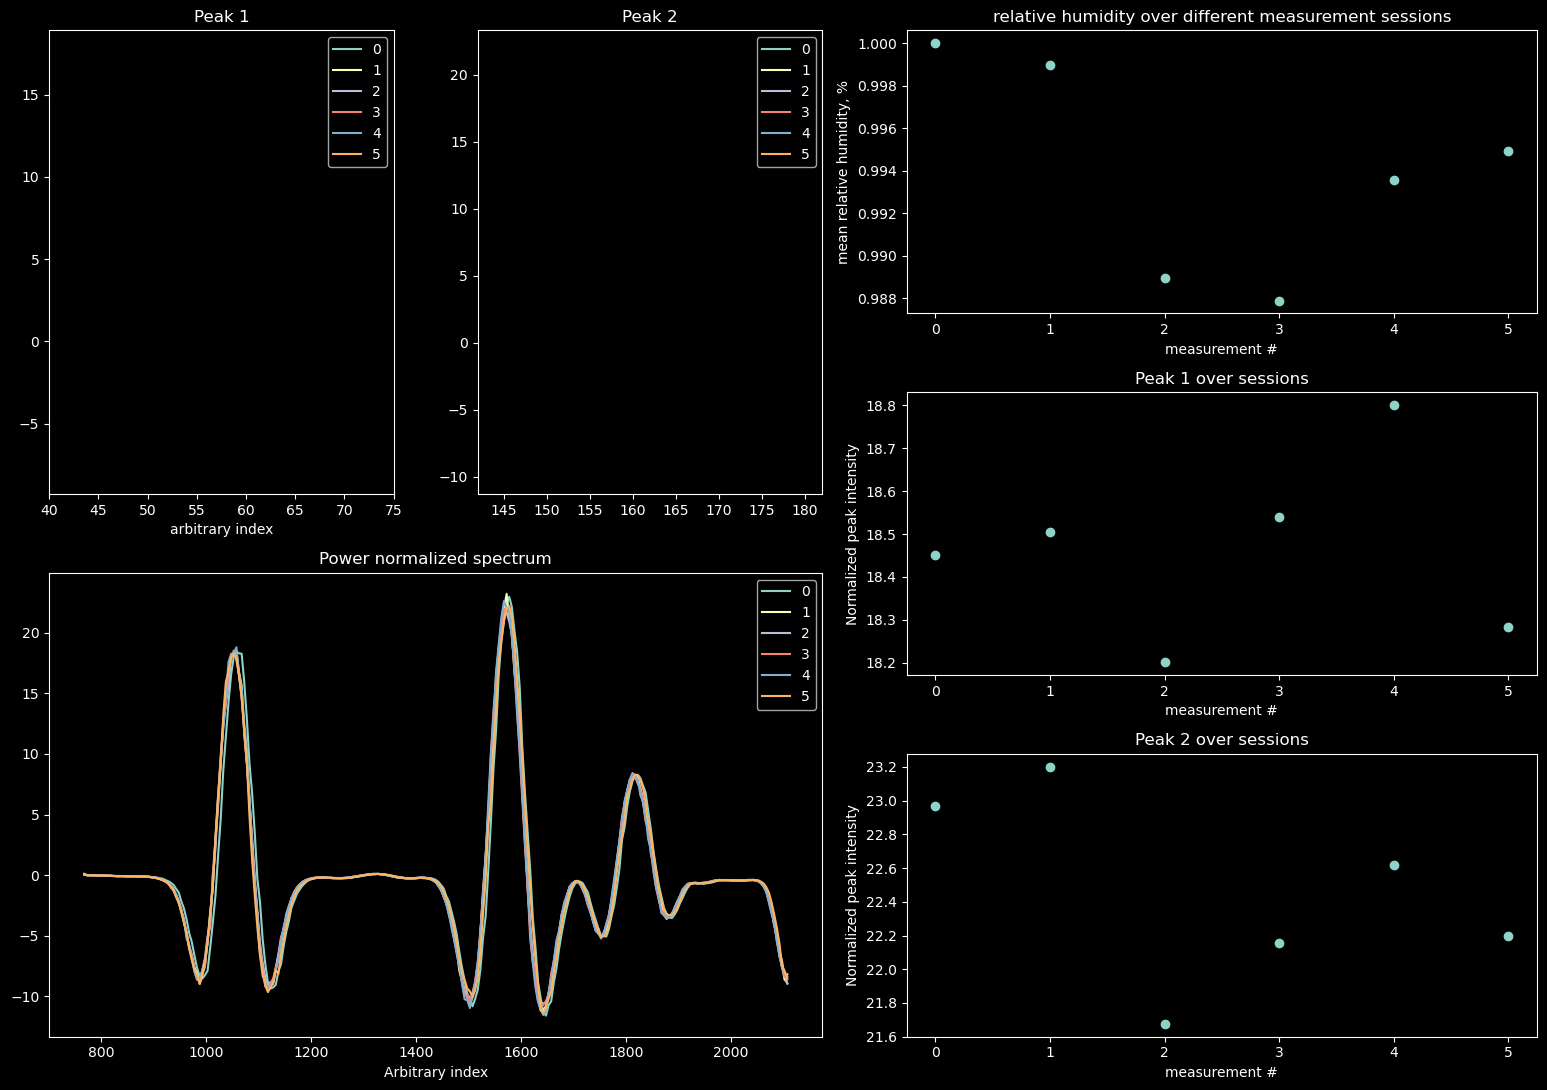

In [12]:
path_sig = "gasx600mbar__msr__"
cm2 = CEPAS_measurement(path, path_sig, col_names)
cm2.water_plot()

In [13]:
cm2.spectra_list[0]

time  offset1   P1        H3            H2     P_las     T_las  \
1    2720.914    768.0  0.0 -0.000061  2.726311e-05 -0.001233  292.2455   
2    2723.023    773.0  0.0  0.000067  9.624281e-06 -0.001233  292.2383   
3    2725.132    778.0  0.0 -0.000015  3.086489e-06 -0.001226  292.2392   
4    2727.237    783.0  0.0  0.000002  9.410022e-07 -0.001219  292.2385   
5    2729.340    788.0  0.0  0.000045  1.849333e-06 -0.001238  292.2407   
..        ...      ...  ...       ...           ...       ...       ...   
265  3384.542   2088.0  0.0  0.000987 -6.414715e-03 -0.001249  292.2231   
266  3386.646   2093.0  0.0  0.001334 -8.102135e-03 -0.001269  292.2290   
267  3388.751   2098.0  0.0  0.001813 -9.388976e-03 -0.001260  292.2339   
268  3390.860   2103.0  0.0  0.001807 -1.076885e-02 -0.001251  292.2345   
269  3392.970   2108.0  0.0  0.001466 -1.119438e-02 -0.001242  292.2296   

           RH  Pressure  time_subtracted  H2_pnorm  H3_pnorm  
1    40.20996     600.0            0.000  0.021520 -0.047832  
2    40.20996     600.0            2.109  0.007597  0.052638  
3    40.18555     600.0            4.218  0.002423 -0.011454  
4    40.18555     600.0            6.323  0.000735  0.001475  
5    40.16113     600.0            8.426  0.001465  0.035961  
..        ...       ...              ...       ...       ...  
265  40.25879     595.0          663.628 -5.127629  0.789028  
266  40.30762     595.0          665.732 -6.583943  1.084011  
267  40.30762     595.0          667.837 -7.573795  1.462784  
268  40.30762     595.0          669.946 -8.623766  1.446961  
269  40.25879     595.0          672.056 -8.899848  1.165565  

[269 rows x 12 columns]

# Amplitude effects (@ $900\ [\text{mbar}]$) [0x20 too low, 0x66 optimal, 0x108 too high]

## Amplitude = 0x20

<Figure size 640x480 with 0 Axes>

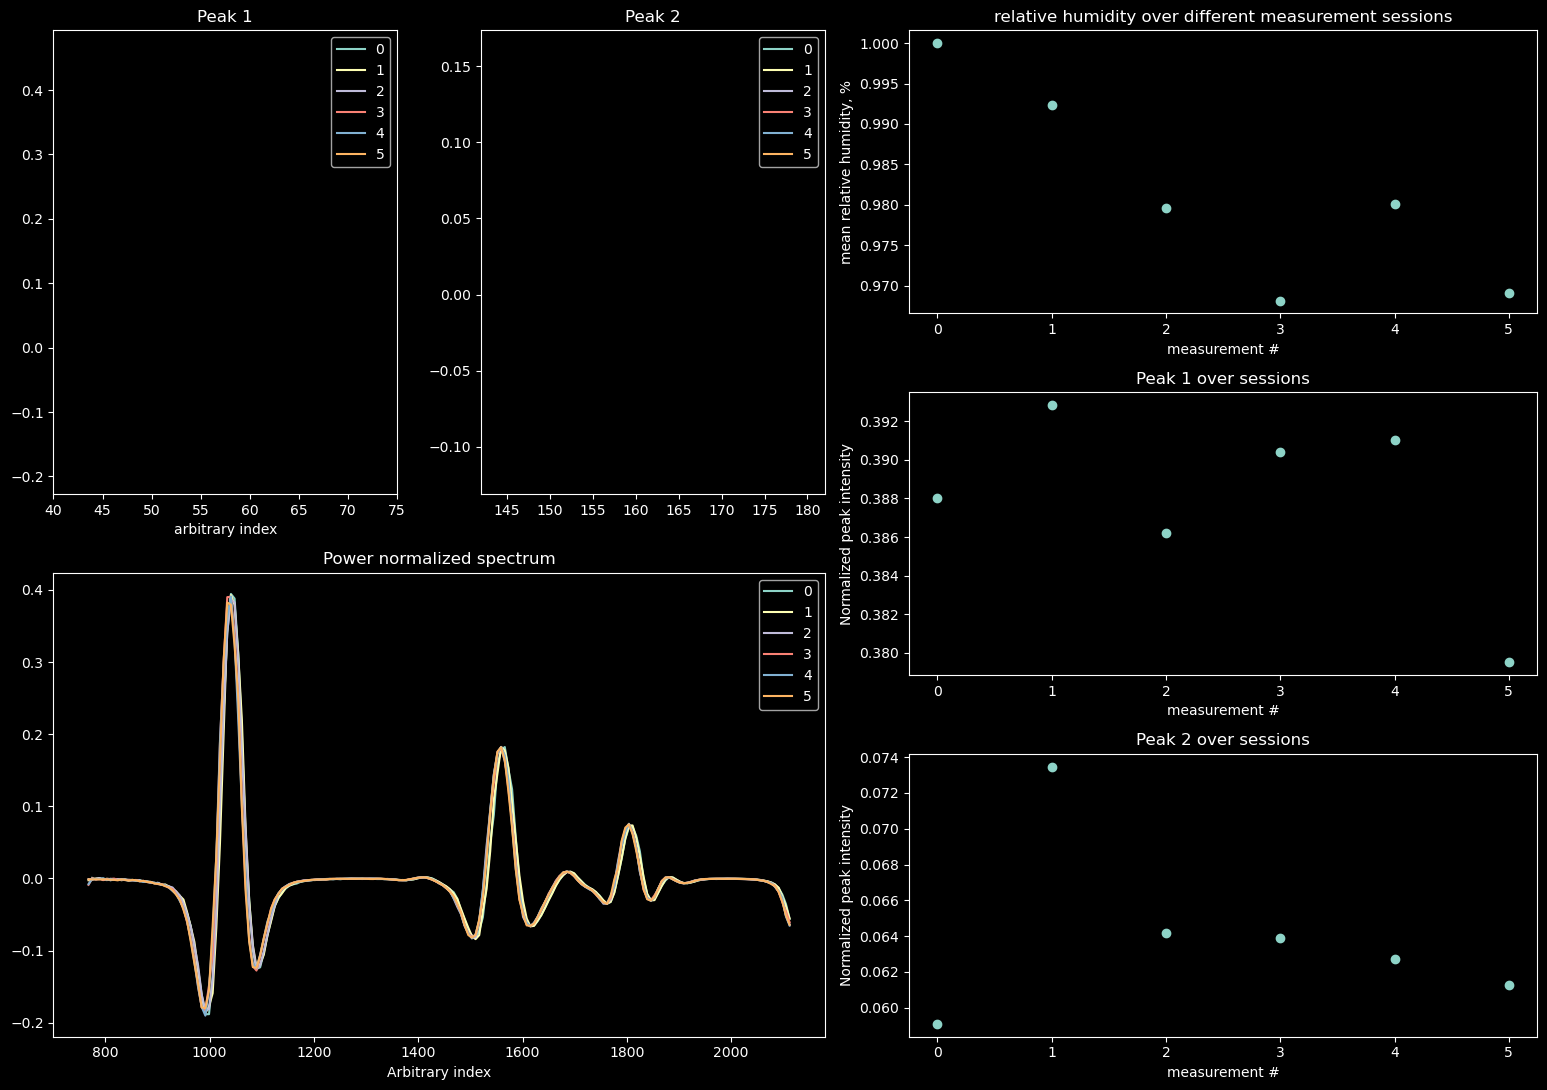

In [14]:
path_sig = "gasx900mbar20amp__msr__"
cm3 = CEPAS_measurement(path, path_sig, col_names)
# len(cm3.spectra_list[0].columns)
cm3.water_plot()


## Amplitude = 66

<Figure size 640x480 with 0 Axes>

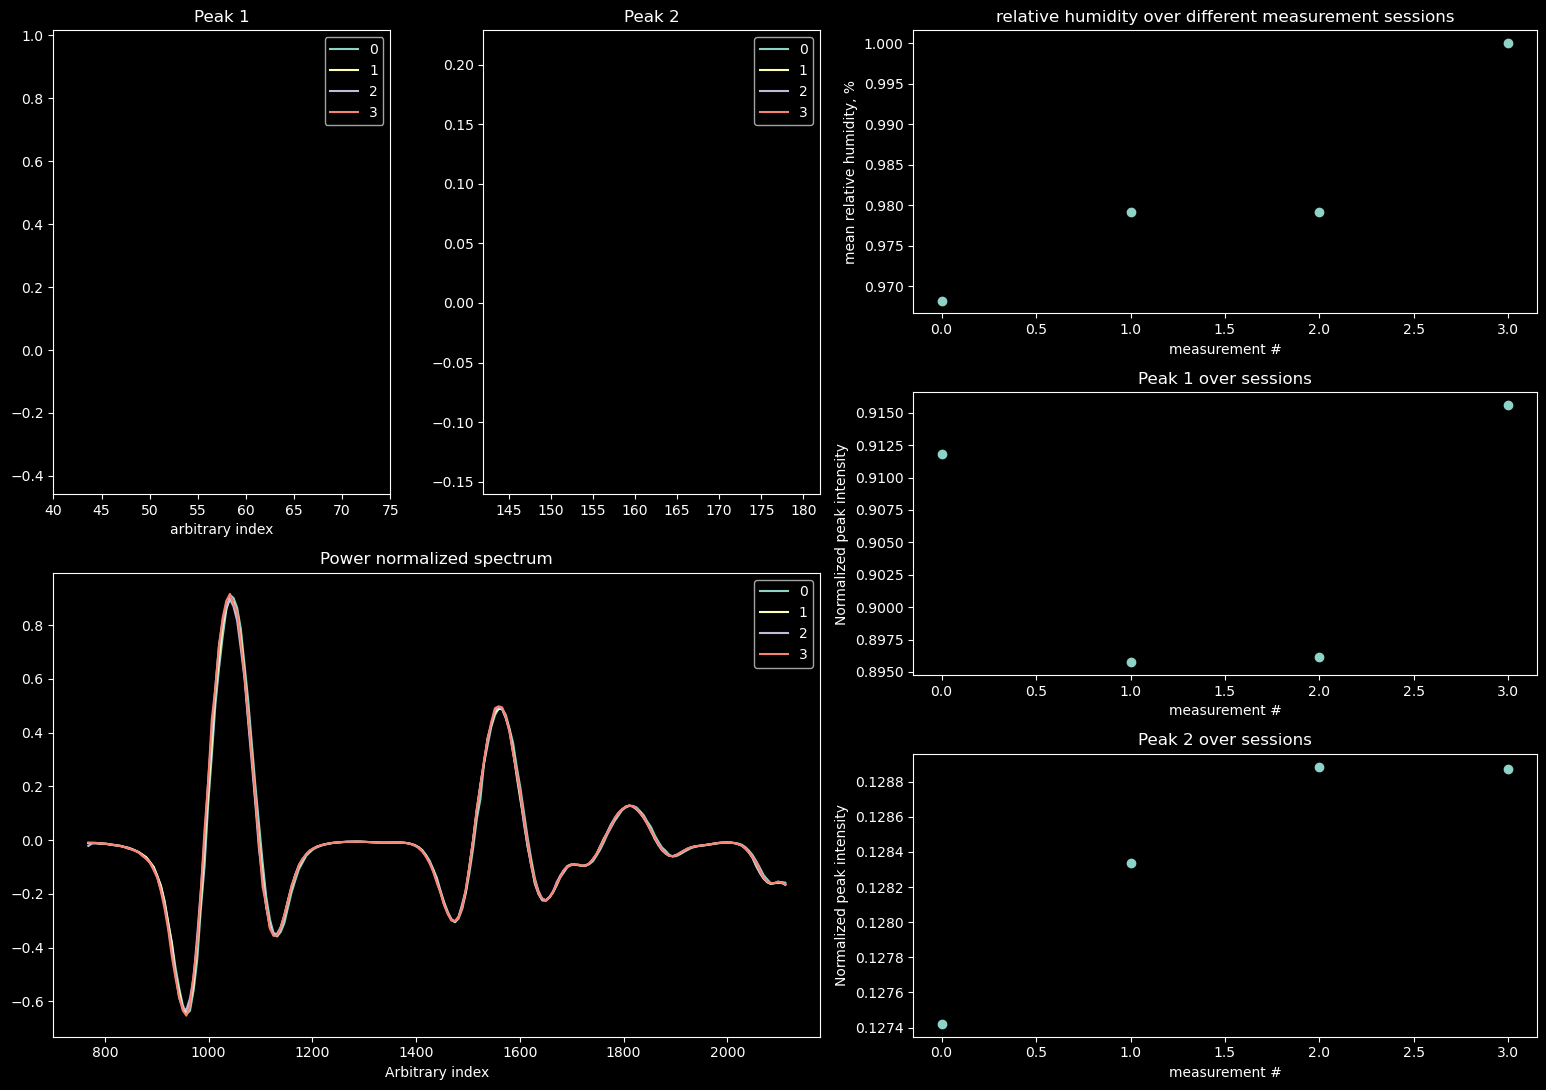

In [15]:
path_sig = "gasx900mbar66amp__msr__"
cm4 = CEPAS_measurement(path, path_sig, col_names)
cm4.water_plot()

## Amplitude 106

In [16]:
path_sig = "gasx900mbar106amp__msr__"
cm5 = CEPAS_measurement(path, path_sig, col_names)
# cm5.water_plot()

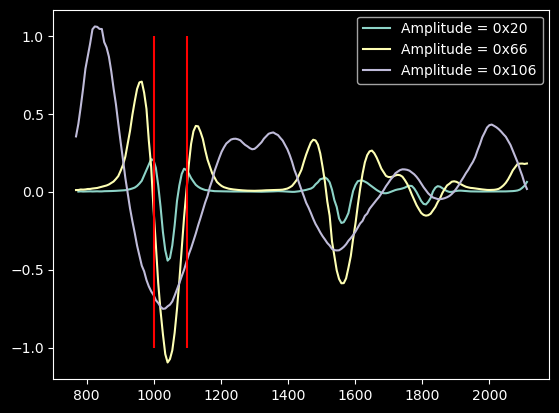

-2.0963459364193224
-1.407104337011501
-0.5346356674952111


In [17]:
plt.plot(cm3.spectra_list[0]["offset1"], cm3.spectra_list[0]["H3_pnorm"], label="Amplitude = 0x20")
plt.plot(cm4.spectra_list[0]["offset1"], cm4.spectra_list[0]["H3_pnorm"], label="Amplitude = 0x66")
plt.plot(cm5.spectra_list[0]["offset1"], cm5.spectra_list[0]["H3_pnorm"], label="Amplitude = 0x106")
# plt.xlim(800, 1200)
plt.vlines([1000, 1100], -1, 1, colors=['red', 'red'])
plt.legend()
plt.show()

print(cm3.spectra_list[0]["H2_pnorm"].max() / cm3.spectra_list[0]["H2_pnorm"].min())
print(cm4.spectra_list[0]["H2_pnorm"].max() / cm4.spectra_list[0]["H2_pnorm"].min())
print(cm5.spectra_list[0]["H2_pnorm"].max() / cm5.spectra_list[0]["H2_pnorm"].min())

## Small amplitude range test

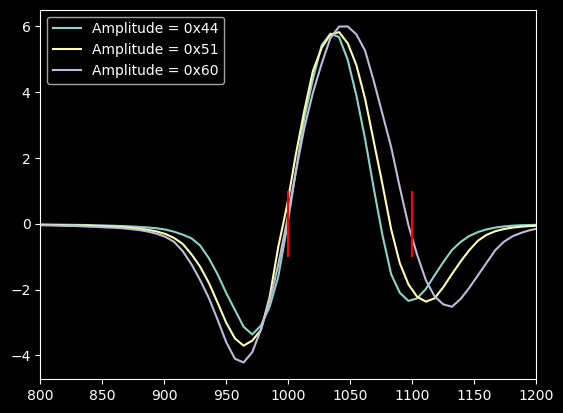

In [18]:
path = './datas/full_tests/'
path_sig = "gasx_600_44_20__msr__"
cm6 = CEPAS_measurement(path, path_sig, col_names)
path_sig = "gasx_600_51_20__msr__"
cm7 = CEPAS_measurement(path, path_sig, col_names)
path_sig = "gasx_600_60_20__msr__"
cm8 = CEPAS_measurement(path, path_sig, col_names)
plt.plot(cm6.spectra_list[0]["offset1"], cm6.spectra_list[0]["H2_pnorm"], label="Amplitude = 0x44")
plt.plot(cm7.spectra_list[0]["offset1"], cm7.spectra_list[0]["H2_pnorm"], label="Amplitude = 0x51")
plt.plot(cm8.spectra_list[0]["offset1"], cm8.spectra_list[0]["H2_pnorm"], label="Amplitude = 0x60")
plt.xlim(800, 1200)
plt.vlines([1000, 1100], -1, 1, colors=['red', 'red'])
plt.legend()
plt.show()

1      False
2      False
3      False
4      False
5      False
       ...  
189    False
190    False
191    False
192    False
193    False
Name: H2_pnorm, Length: 193, dtype: bool


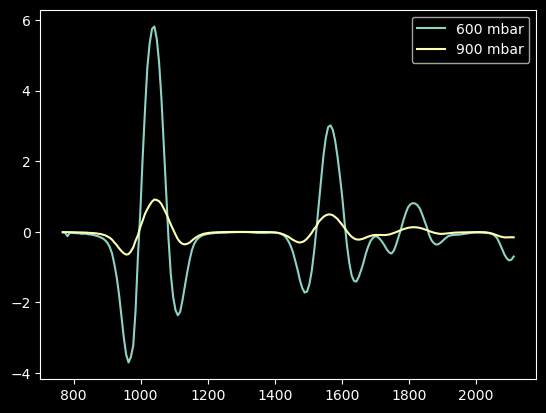

In [19]:
print(cm7.spectra_list[0]["H2_pnorm"] == cm4.spectra_list[0]["H2_pnorm"])
plt.plot(cm7.spectra_list[0]["offset1"], cm7.spectra_list[0]["H2_pnorm"], label="600 mbar")
plt.plot(cm4.spectra_list[0]["offset1"], cm4.spectra_list[0]["H2_pnorm"], label="900 mbar")
plt.legend()
plt.show()


# Auto test

Testing on $\text{H}_2\text{O}$ line in the range

from $6986$ to $6988\ \text{cm}^{-1}$

In [20]:
amp_list = [hex(32+i*8)[2:] for i in range(14)]
print(amp_list)

['20', '28', '30', '38', '40', '48', '50', '58', '60', '68', '70', '78', '80', '88']


In [21]:
offsets_list_h2o_19_deg = [1503.7818, 976.3011] # add lines from the cepas measurement descending
wavenumbers_list_h2o = [6984.9535, 6987.1444] # add lines from trusted source, like HITRAN ascending

fit_params = cp.get_wavenumber(1, offsets_list_h2o_19_deg, wavenumbers_list_h2o)

offset_wav_dict = dict(zip(amp_list, cp.get_modamp_around_line_in_wav(amp_list, offsets_list_h2o_19_deg[0], (fit_params[1], fit_params[2]))))
offset_wav_dict

{'20': 0.13291254068644776,
 '28': 0.16614067585760495,
 '30': 0.19936881102967163,
 '38': 0.23259694620173832,
 '40': 0.2658250813728955,
 '48': 0.2990532165440527,
 '50': 0.3322813517152099,
 '58': 0.3655094868872766,
 '60': 0.39873762205934327,
 '68': 0.43196575723050046,
 '70': 0.46519389240165765,
 '78': 0.49842202757372434,
 '80': 0.531650162745791,
 '88': 0.5648782979169482}

<Figure size 640x480 with 0 Axes>

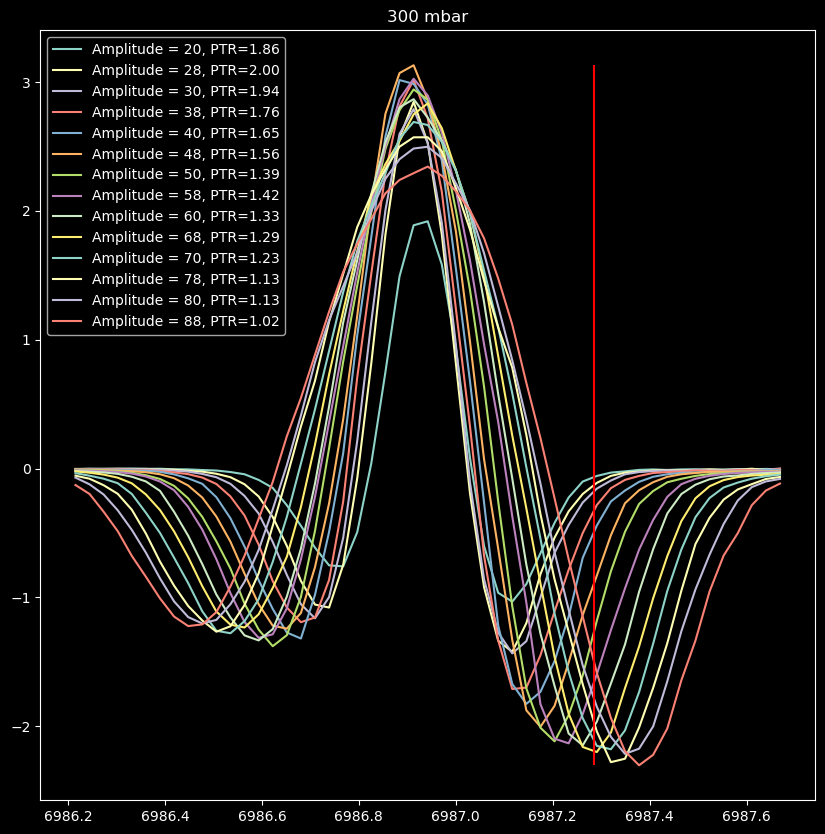

In [22]:
path3 = './datas/amptests/1/'
# amp_list = [hex(8+i*8)[2:] for i in range(14)]
auto_amp_test_300 = {}

cp.amp_test_plot("300", path3, auto_amp_test_300, amp_list, 6987.285, ow_params=(offsets_list_h2o_19_deg, wavenumbers_list_h2o), ctu=CEPAS_measurement)

In [23]:
path4 = "./datas/amptests/2/"
auto_amp_test_600 = {}


interact_manual(
    cp.amp_test_plot,
    pressure_string=fixed("600"),
    path=fixed(path4),
    amp_test_dict=fixed(auto_amp_test_600),
    used_amps=fixed(amp_list),
    vlinepos=(6986.0, 6987.6, 0.004),
    ow_params=fixed((offsets_list_h2o_19_deg, wavenumbers_list_h2o)),
    ctu=fixed(CEPAS_measurement)
) 
# amp_test_plot(path4, auto_amp_test_600, amp_list, 6987.285)

interactive(children=(FloatSlider(value=6986.8, description='vlinepos', max=6987.6, min=6986.0, step=0.004), B…

<function my_utils.defs.amp_test_plot(pressure_string: str | int, path: str, amp_test_dict: Dict, used_amps: Union[List[str], List[int]], vlinepos: float, ow_params: Tuple[List[float], List[float]], ctu) -> None>

<Figure size 640x480 with 0 Axes>

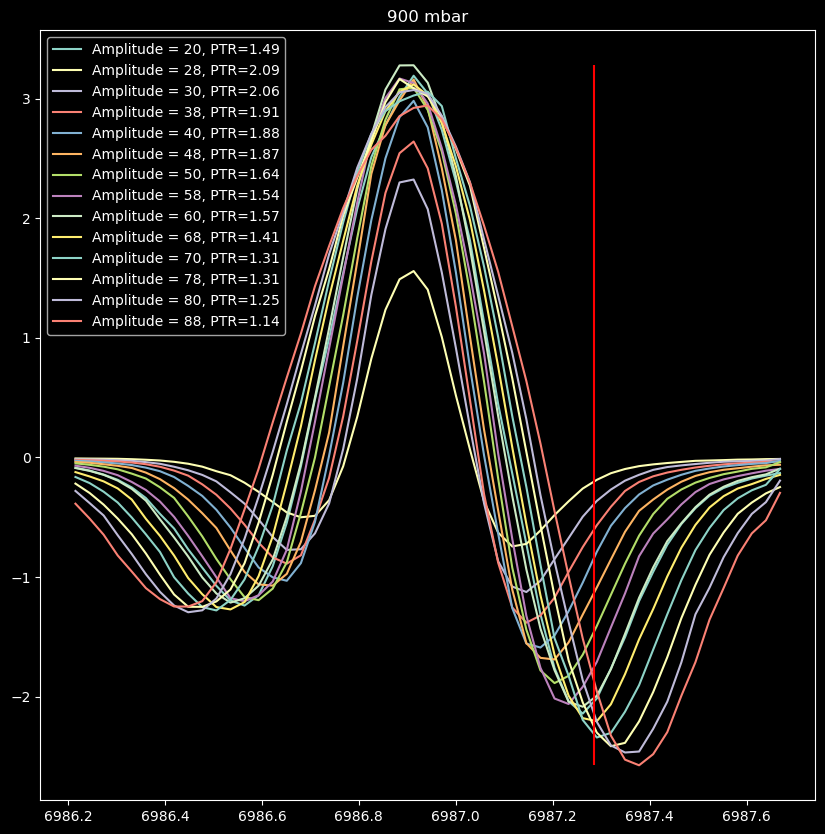

In [24]:
auto_amp_test_900 = {}
# for i in amp_list:
#     # auto_freq_test[f'cm{i}_fl'] = CEPAS_measurement(path=path2, path_signature=f"gasx_600_51_{i}__msr__", cols=col_names)
#     auto_amp_test_900[f'cm{i}_fl'] = CEPAS_measurement(path=path3, path_signature=f"gasx_900_{i}_20__msr__", cols=col_names)
#     auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['wav'] = get_wavenumber(auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['offset1'], offsets_list_h2o_19_deg, wavenumbers_list_h2o)
#     min_val = abs(auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'].min())
#     max_val = abs(auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'].max())
#     ratio = max_val / min_val
#     # auto_test[f'cm{i}_fl'].water_plot()
#     # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[0]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[0]['RH'], label=f"{i}")
#     # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[1]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[1]['RH'], label=f"{i}")
#     # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[2]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[2]['RH'], label=f"{i}")
#     plt.plot(auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['wav'], auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'], label=f'Amplitude = {i}, PTR={ratio:.2f}')
# plt.legend(loc=1)
# plt.title("900 mbar")
# plt.show()

cp.amp_test_plot("900", path3, auto_amp_test_900, amp_list, 6987.285, ow_params=(offsets_list_h2o_19_deg, wavenumbers_list_h2o), ctu=CEPAS_measurement)

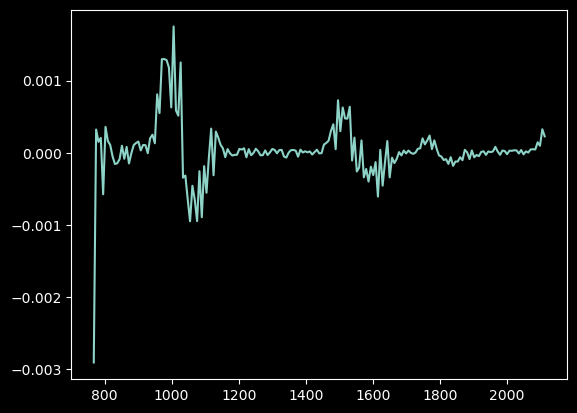

In [25]:
plt.clf()
cm_last = CEPAS_measurement(path=path2, path_signature="gasx_600_51_300__msr__", cols=col_names)
plt.plot(cm_last.spectra_list[0]['offset1'], cm_last.spectra_list[0]['H3_pnorm'])
plt.show()

# Peak/trough ratio

In [26]:
auto_amp_tests = {
    '300': auto_amp_test_300,
    '600': auto_amp_test_600,
    '900': auto_amp_test_900
}



cp.extract_PT_ratios(auto_amp_tests)

300
600
900


{'300': {'Amplitude: cm20_fl': 1.8572713427997576,
  'Amplitude: cm28_fl': 2.0008222960484106,
  'Amplitude: cm30_fl': 1.9438575305495334,
  'Amplitude: cm38_fl': 1.762320889490436,
  'Amplitude: cm40_fl': 1.6506866033833827,
  'Amplitude: cm48_fl': 1.5617129296110441,
  'Amplitude: cm50_fl': 1.3897437074053178,
  'Amplitude: cm58_fl': 1.4184613990501653,
  'Amplitude: cm60_fl': 1.3344244237293932,
  'Amplitude: cm68_fl': 1.2879978759832391,
  'Amplitude: cm70_fl': 1.234607380678039,
  'Amplitude: cm78_fl': 1.1282843521561705,
  'Amplitude: cm80_fl': 1.1276990716844901,
  'Amplitude: cm88_fl': 1.0176601718405858},
 '600': {},
 '900': {'Amplitude: cm20_fl': 1.48986372048321,
  'Amplitude: cm28_fl': 2.0936990056230846,
  'Amplitude: cm30_fl': 2.0649541769237674,
  'Amplitude: cm38_fl': 1.9117654058314861,
  'Amplitude: cm40_fl': 1.8758202287102135,
  'Amplitude: cm48_fl': 1.8704666319656866,
  'Amplitude: cm50_fl': 1.6385571394383918,
  'Amplitude: cm58_fl': 1.5366259549738166,
  'Amplit

# Expt vs Sim analysis

In [27]:
# rows will be 300-600-900 mbar pressures (implicit)
sim = pd.DataFrame({
    "pressure": [300, 600, 900],
    "pos1": [np.nan, 6987.02, 6986.97],
    "pos2": [6987.13, 6987.13, 6987.13],
    "pos3": [6987.23, 6987.25, 6987.3],
    "amp": [0.083, 0.1, 0.1561]
})

expt = pd.DataFrame({
    "pressure": [300, 600, 900],
    "pos1": [6986.691, 6986.78, 6986.616],
    "pos2": [6986.906, 6987.025, 6986.903],
    "pos3": [6987.128, 6987.29, 6987.193],
    "amp": [offset_wav_dict[i] for i in ['38', '40', '48']]
})

sim

pressure     pos1     pos2     pos3     amp
0       300      NaN  6987.13  6987.23  0.0830
1       600  6987.02  6987.13  6987.25  0.1000
2       900  6986.97  6987.13  6987.30  0.1561

/tmp/ipykernel_2291/804583558.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc=3)


<Figure size 640x480 with 0 Axes>

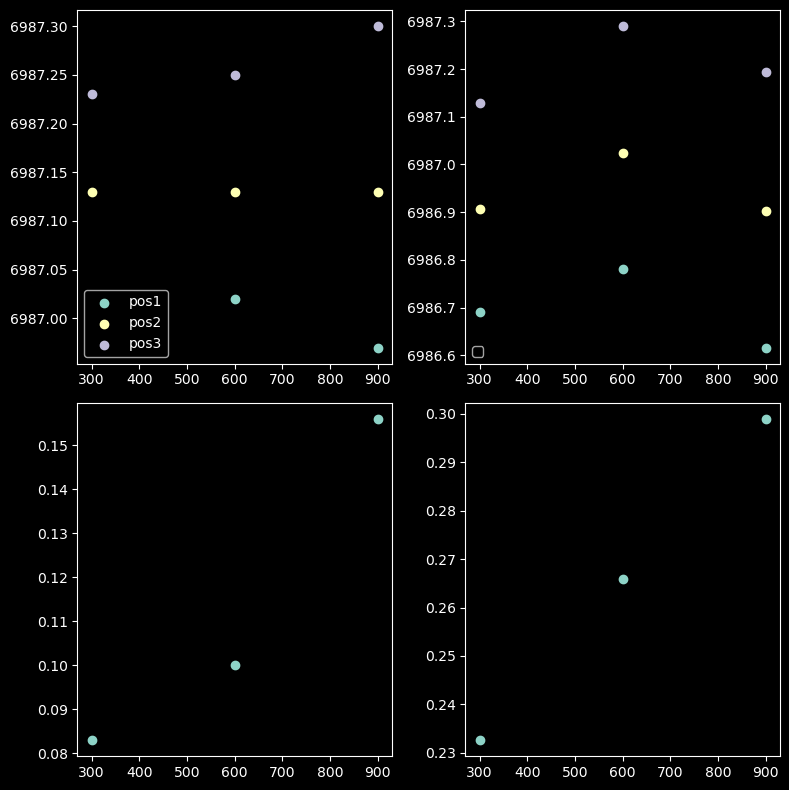

In [28]:
plt.clf()
fig = plt.figure(figsize=(8, 8))  # noqa: F841

ax0 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=1, rowspan=1)
for pos in ['pos1', 'pos2', 'pos3']:
    ax0.scatter(sim['pressure'], sim[pos], label=pos)
ax0.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax0.legend(loc=3)

ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 1), colspan=1, rowspan=1)
ax1.legend(loc=3)
for pos in ['pos1', 'pos2', 'pos3']:
    ax1.scatter(expt['pressure'], expt[pos], label=pos)

ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), rowspan=1, colspan=1)
ax2.scatter(sim['pressure'], sim['amp'])

ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), rowspan=1, colspan=1)
ax3.scatter(expt['pressure'], expt['amp'])

plt.tight_layout()
plt.show()

In [29]:
# r_o_r_expt = (expt['amp'][2] - expt['amp'][0]) / 600
# r_o_r_sim = (sim['amp'][2] - sim['amp'][0]) / 600
r_o_r_expt = (0.1222-0.042) / 600
r_o_r_sim = (int('0x38', 16) - int('0x28', 16)) / 600

print(f"ROR expt = {r_o_r_expt}")
print(f"ROR sim  = {r_o_r_sim}")

ROR expt = 0.00013366666666666665
ROR sim  = 0.02666666666666667


# $22\ \degree\text{C}$ test

## Initial full spectrums in $p_{cell}=\lbrace 300,600,900\rbrace\ \text{[mbar]}$

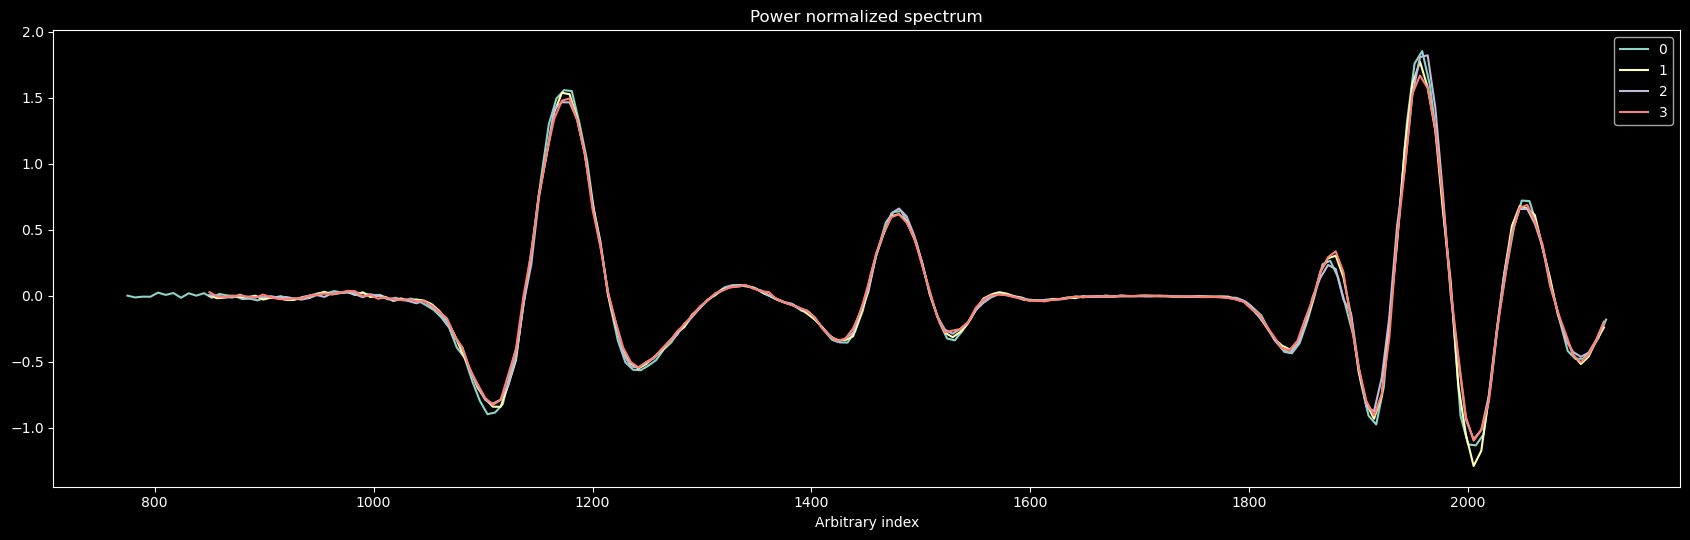

In [30]:
path_22_deg = "./datas/22deg/"
cm_22deg_300 = CEPAS_measurement(path=path_22_deg, path_signature="gasx_300_.+", cols=col_names)
cm_22deg_300.spectrum_only_plot()

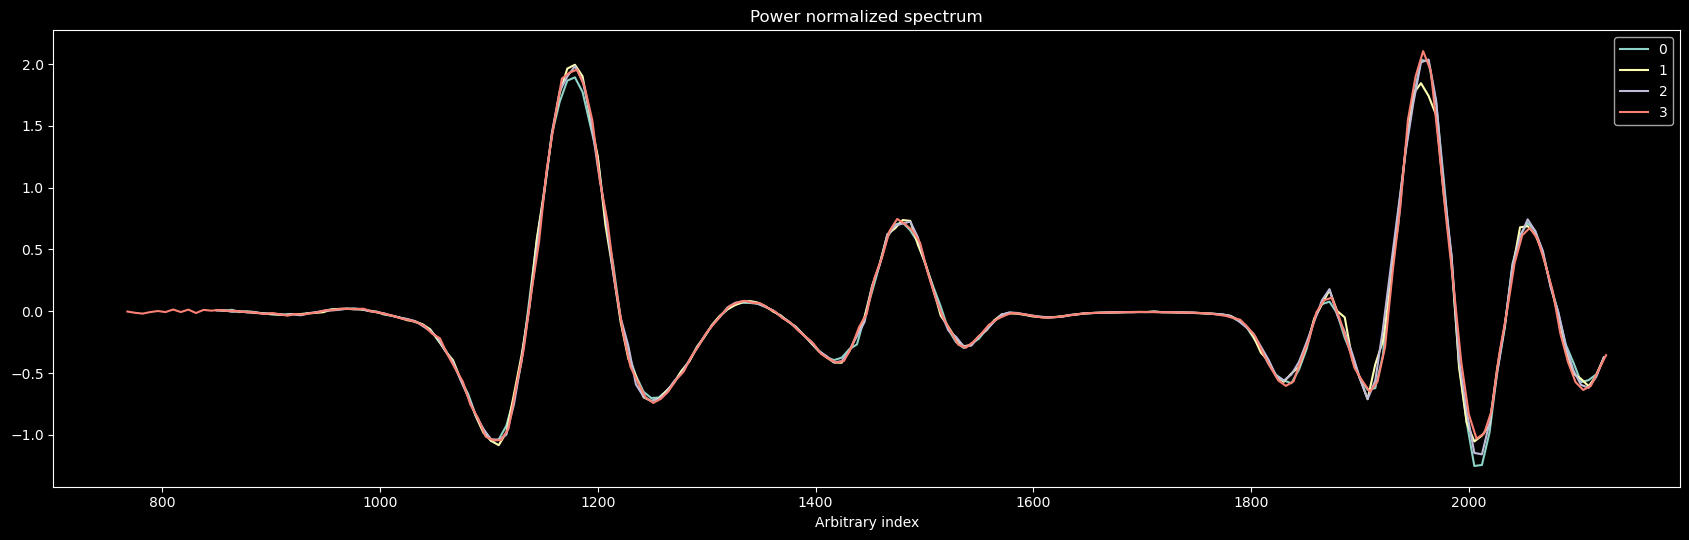

In [31]:
path_22_deg = "./datas/22deg/"
cm_22deg_600 = CEPAS_measurement(path=path_22_deg, path_signature="gasx_600_.+", cols=col_names)
cm_22deg_600.spectrum_only_plot()

# cm_22deg_600.spectra_list[0]

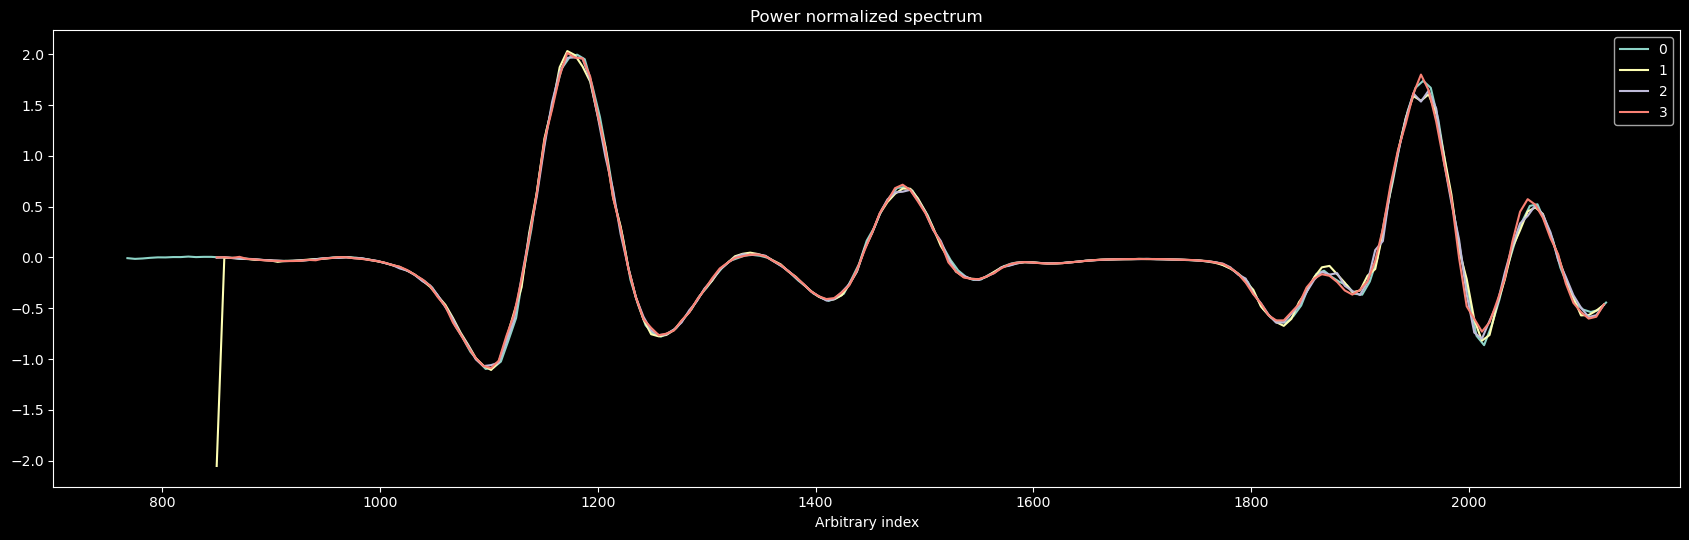

In [32]:
path_22_deg = "./datas/22deg/"
cm_22deg_900 = CEPAS_measurement(path=path_22_deg, path_signature="gasx_900_.+", cols=col_names)
cm_22deg_900.spectrum_only_plot()

## Modulation amplitude test for line $\tilde{\nu}_{\text{H}_2\text{O}}=6983.6678\ \text{cm}^{-1}$

<Figure size 640x480 with 0 Axes>

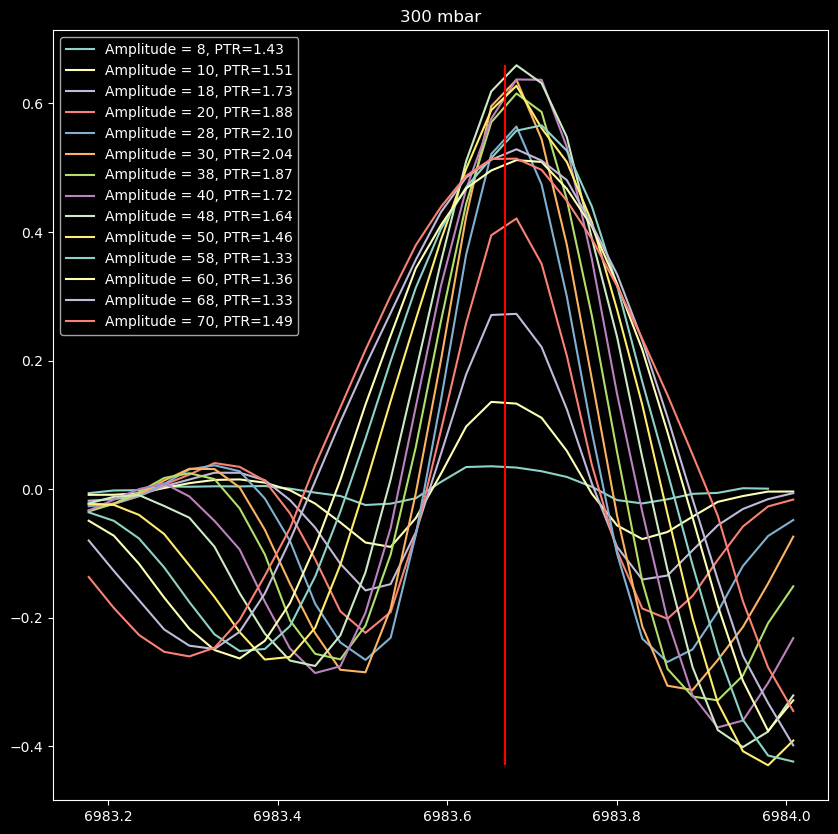

time  offset1   P1        H3        H2     P_las     T_las        RH  \
1   692.030   1400.0  0.0 -0.000295 -0.000355  0.090616  295.1961  26.00098   
2   693.132   1407.0  0.0 -0.000330 -0.000366  0.091319  295.2094  26.00098   
3   694.237   1414.0  0.0 -0.000806 -0.001018  0.091428  295.1972  26.00098   
4   695.341   1421.0  0.0 -0.001261 -0.001873  0.091594  295.2020  26.00098   
5   696.447   1428.0  0.0 -0.002533 -0.004061  0.092134  295.1947  26.00098   
6   697.549   1435.0  0.0 -0.004007 -0.006343  0.092527  295.1940  26.00098   
7   698.654   1442.0  0.0 -0.005324 -0.007416  0.092858  295.1913  26.00098   
8   699.759   1449.0  0.0 -0.003673 -0.005397  0.092917  295.2010  26.00098   
9   700.860   1456.0  0.0 -0.000165 -0.000716  0.093110  295.2087  26.00098   
10  701.965   1463.0  0.0  0.003752  0.005712  0.093477  295.2045  26.00098   
11  717.712   1470.0  0.0  0.007216  0.010742  0.094437  295.1940  26.00098   
12  718.815   1477.0  0.0  0.009345  0.012881  0.094385  295.1927  26.00098   
13  719.920   1484.0  0.0  0.009591  0.013263  0.095283  295.2033  26.00098   
14  721.023   1491.0  0.0  0.007292  0.009704  0.097260  295.2032  25.97656   
15  722.125   1498.0  0.0  0.001678  0.002398  0.098097  295.2078  25.97656   
16  723.232   1505.0  0.0 -0.003102 -0.004595  0.099357  295.1941  25.97656   
17  724.337   1512.0  0.0 -0.006002 -0.009277  0.100576  295.1983  25.97656   
18  725.439   1519.0  0.0 -0.005850 -0.008687  0.101966  295.1877  25.97656   
19  726.542   1526.0  0.0 -0.004368 -0.005497  0.103392  295.1951  25.97656   
20  727.648   1533.0  0.0 -0.001851 -0.002427  0.104805  295.1982  25.97656   
21  728.753   1540.0  0.0 -0.000360 -0.000201  0.106304  295.2045  25.97656   
22  729.756   1547.0  0.0  0.000341  0.001099  0.107370  295.2080  25.97656   
23  730.861   1554.0  0.0  0.000798  0.001678  0.109211  295.1938  25.97656   
24  731.966   1561.0  0.0  0.001305  0.001634  0.112410  295.2023  25.97656   
25  733.070   1568.0  0.0  0.000569  0.001077  0.114403  295.2058  25.97656   
26  734.172   1575.0  0.0 -0.000017  0.000190  0.115530  295.2089  25.97656   
27  749.836   1582.0  0.0 -0.000873 -0.000781  0.117861  295.1938  25.97656   
28  751.038   1589.0  0.0 -0.000657 -0.001081  0.119851  295.1998  25.92773   
29  752.043   1596.0  0.0 -0.000604 -0.001112  0.121769  295.1943  25.92773   

    Pressure  time_subtracted  H2_pnorm  H3_pnorm  
1      299.0            0.000 -0.003810 -0.003166  
2      299.0            1.102 -0.003900 -0.003520  
3      299.0            2.207 -0.010839 -0.008582  
4      299.0            3.311 -0.019904 -0.013401  
5      299.0            4.417 -0.042917 -0.026768  
6      299.0            5.519 -0.066752 -0.042171  
7      299.0            6.624 -0.077772 -0.055828  
8      299.0            7.729 -0.056564 -0.038498  
9      299.0            8.830 -0.007489 -0.001723  
10     299.0            9.935  0.059514  0.039091  
11     297.0           25.682  0.110819  0.074443  
12     297.0           26.785  0.132948  0.096455  
13     297.0           27.890  0.135634  0.098083  
14     297.0           28.993  0.097273  0.073093  
15     297.0           30.095  0.023835  0.016683  
16     297.0           31.202 -0.045115 -0.030459  
17     297.0           32.307 -0.090002 -0.058229  
18     297.0           33.409 -0.083152 -0.056000  
19     297.0           34.512 -0.051910 -0.041252  
20     297.0           35.618 -0.022622 -0.017248  
21     297.0           36.723 -0.001850 -0.003306  
22     297.0           37.726  0.010005  0.003103  
23     297.0           38.831  0.015021  0.007144  
24     297.0           39.936  0.014220  0.011353  
25     297.0           41.040  0.009216  0.004869  
26     297.0           42.142  0.001613 -0.000144  
27     299.0           57.806 -0.006487 -0.007256  
28     299.0           59.008 -0.008836 -0.005367  
29     299.0           60.013 -0.008949 -0.004860

In [33]:
offsets = [1480.3, 1177.2]
wavenumbers = [6983.6678, 6984.9534710]

path_6983_6678_300 = "./datas/amptests/h2o_6983_6678/1/"
amp_test_6983_6678_300_dict = {}
amp_list = [hex(8+i*8)[2:] for i in range(14)]
cp.amp_test_plot("300", path_6983_6678_300, amp_test_6983_6678_300_dict, amp_list, 6983.6678, ow_params=(offsets, wavenumbers), ctu=CEPAS_measurement)
cm_new_line_300 = CEPAS_measurement(path=path_6983_6678_300, path_signature="gasx_300.+", cols=col_names)
cm_new_line_300.spectra_list[0]

## Different pressure spectra overlaid (width comparison)

#### Same RH%, diff pressures

       time  offset1   P1        H3        H2     P_las     T_las        RH  \
1  2322.939    768.0  0.0  0.000043  0.000297  0.016986  295.1931  23.19336   
2  2324.042    775.0  0.0 -0.000077 -0.000074  0.016982  295.1858  23.19336   
3  2325.145    782.0  0.0 -0.000208  0.000027  0.018738  295.1790  23.19336   
4  2326.347    789.0  0.0 -0.000011 -0.000107  0.019990  295.2006  23.19336   
5  2327.348    796.0  0.0  0.000016 -0.000004  0.020634  295.1872  23.19336   

   Pressure  time_subtracted  H2_pnorm  H3_pnorm  
1     298.0            0.000  0.015251  0.002219  
2     298.0            1.103 -0.003820 -0.003947  
3     298.0            2.206  0.001282 -0.009800  
4     298.0            3.408 -0.004736 -0.000492  
5     298.0            4.409 -0.000185  0.000710  


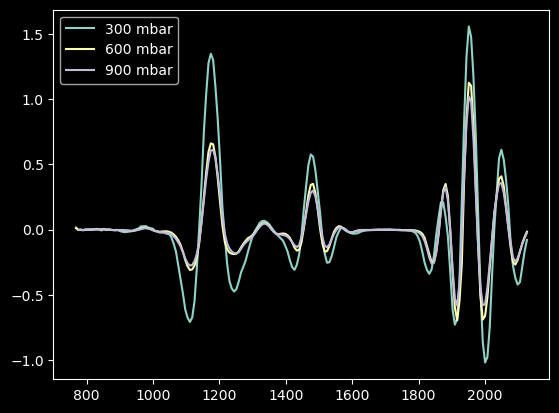

In [34]:
path_pressure_tests_1 = './datas/amptests/h2o_6983_6678/p_tests/1/'
prs_sig_300 = r'gasx_300_.+'
prs_sig_600 = r'gasx_600_.+'
prs_sig_900 = r'gasx_900_.+'
cm300 = CEPAS_measurement(path_pressure_tests_1, prs_sig_300, col_names)
cm600 = CEPAS_measurement(path_pressure_tests_1, prs_sig_600, col_names)
cm900 = CEPAS_measurement(path_pressure_tests_1, prs_sig_900, col_names)
print(cm300.spectra_list[0].head())
plt.plot(cm300.spectra_list[0]['offset1'], cm300.spectra_list[0]['H2_pnorm'], label="300 mbar")
plt.plot(cm600.spectra_list[0]['offset1'], cm600.spectra_list[0]['H2_pnorm'], label="600 mbar")
plt.plot(cm900.spectra_list[0]['offset1'], cm900.spectra_list[0]['H2_pnorm'], label="900 mbar")
plt.legend()
plt.show()

#### Diff pressures, diff RH ($p_{cell}=300\ \text{[mbar]}/RH=10\%$ and $p_{cell}=900\ \text{[mbar]}/RH=37\%$)

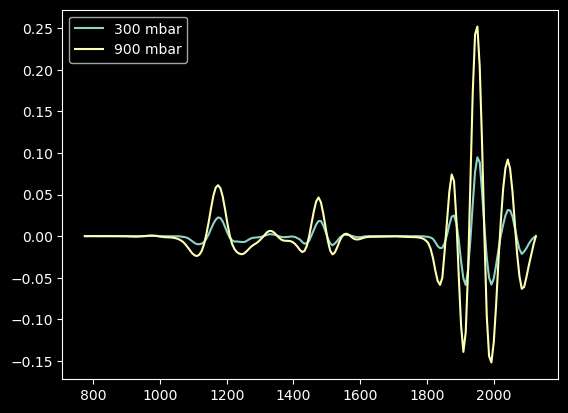

In [35]:
path_pressure_tests_2 = './datas/amptests/h2o_6983_6678/p_tests/2/'
cm300 = CEPAS_measurement(path_pressure_tests_2, prs_sig_300, col_names)
# cm600 = CEPAS_measurement(path_pressure_tests_2, prs_sig_600, col_names)
cm900 = CEPAS_measurement(path_pressure_tests_2, prs_sig_900, col_names)
plt.plot(cm300.spectra_list[0]['offset1'], cm300.spectra_list[0]['H2'], label="300 mbar")
plt.plot(cm900.spectra_list[0]['offset1'], cm900.spectra_list[0]['H2'], label="900 mbar")
plt.legend()
plt.show()

## Amplitude modulation / Chopper

#### Bad chopper run

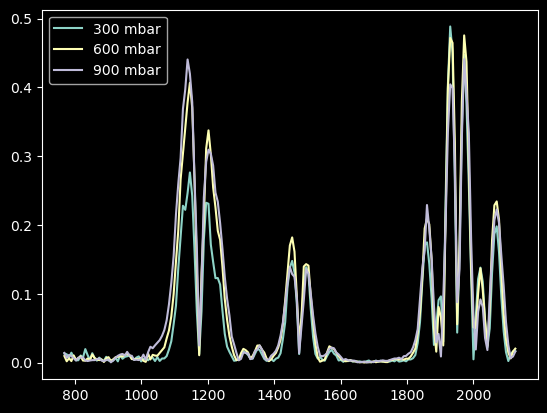

In [36]:
path_pressure_tests_4 = './datas/amptests/h2o_6983_6678/p_tests/4/'
cm300 = CEPAS_measurement(path_pressure_tests_4, prs_sig_300, col_names)
cm600 = CEPAS_measurement(path_pressure_tests_4, prs_sig_600, col_names)
cm900 = CEPAS_measurement(path_pressure_tests_4, prs_sig_900, col_names)
cols = list(cm300.spectra_list[0].columns)
plt.plot(cm300.spectra_list[2]['offset1'], cm300.spectra_list[2]['H2_pnorm'], label="300 mbar")
plt.plot(cm600.spectra_list[2]['offset1'], cm600.spectra_list[2]['H2_pnorm'], label="600 mbar")
plt.plot(cm900.spectra_list[2]['offset1'], cm900.spectra_list[2]['H2_pnorm'], label="900 mbar")
plt.legend()
plt.show()

#### Diff pressures w/ chopper

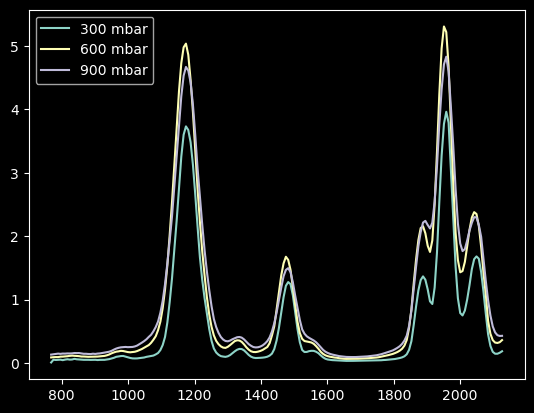

In [37]:
path_pressure_tests_5 = './datas/amptests/h2o_6983_6678/p_tests/5/'
cm300 = CEPAS_measurement(path_pressure_tests_5, prs_sig_300, col_names)
cm600 = CEPAS_measurement(path_pressure_tests_5, prs_sig_600, col_names)
cm900 = CEPAS_measurement(path_pressure_tests_5, prs_sig_900, col_names)
cols = list(cm300.spectra_list[0].columns)
plt.plot(cm300.spectra_list[1]['offset1'], cm300.spectra_list[1]['H2_pnorm'], label="300 mbar")
plt.plot(cm600.spectra_list[1]['offset1'], cm600.spectra_list[1]['H2_pnorm'], label="600 mbar")
plt.plot(cm900.spectra_list[1]['offset1'], cm900.spectra_list[1]['H2_pnorm'], label="900 mbar")
plt.legend()
plt.show()

#### Low humidity test

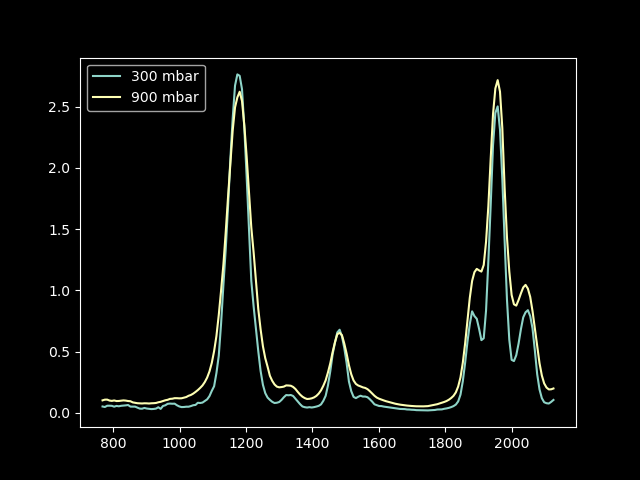

-0.004233358577542437
6989.936134045767


In [38]:
%matplotlib widget
plt.clf()
units1 = [1480.7, 1177.0] # offsets decimal
units2 = [6983.6678, 6984.9534710] # wavenumbers
a = cp.get_wavenumber(1, units1, units2)[1]
b = cp.get_wavenumber(1, units1, units2)[2]
path_pressure_tests_6 = './datas/amptests/h2o_6983_6678/p_tests/lowRH/'
cm300 = CEPAS_measurement(path_pressure_tests_6, prs_sig_300, col_names)
cm900 = CEPAS_measurement(path_pressure_tests_6, prs_sig_900, col_names)
cols = list(cm300.spectra_list[0].columns)
# plt.plot(a*cm300.spectra_list[0]['offset1']+b, cm300.spectra_list[0]['H2_pnorm'], label="300 mbar")
# plt.plot(a*cm900.spectra_list[0]['offset1']+b, cm900.spectra_list[0]['H2_pnorm'], label="900 mbar")
plt.plot(cm300.spectra_list[0]['offset1'], cm300.spectra_list[0]['H2_pnorm'], label="300 mbar")
plt.plot(cm900.spectra_list[0]['offset1'], cm900.spectra_list[0]['H2_pnorm'], label="900 mbar")
plt.legend()
plt.show()
print(a)
print(b)

#### Low RH test, 300, 600, 900 mbar

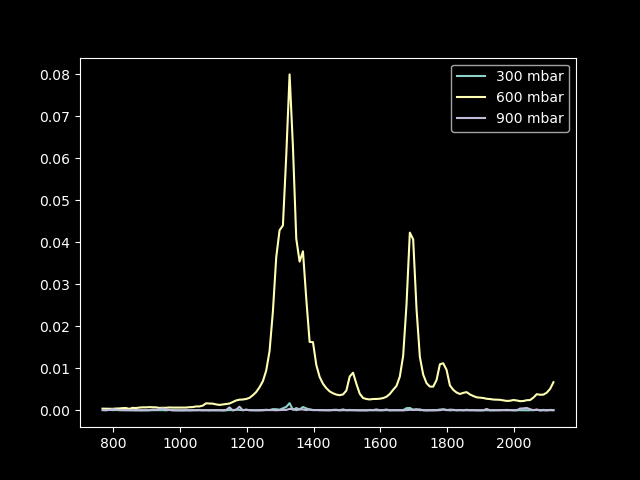

-0.004233358577542437
6989.936134045767


In [39]:
plt.clf()
units1 = [1480.7, 1177.0] # offsets decimal
units2 = [6983.6678, 6984.9534710] # wavenumbers
a = cp.get_wavenumber(1, units1, units2)[1]
b = cp.get_wavenumber(1, units1, units2)[2]
path_pressure_tests_7 = './datas/amptests/h2o_6983_6678/p_tests/lowRH_picoSignal/'
cm300_7 = CEPAS_measurement(path_pressure_tests_7, prs_sig_300, col_names)
cm600_7 = CEPAS_measurement(path_pressure_tests_7, prs_sig_600, col_names)
cm900_7 = CEPAS_measurement(path_pressure_tests_7, prs_sig_900, col_names)
cols = list(cm300_7.spectra_list[0].columns)
# plt.plot(a*cm300_7.spectra_list[0]['offset1']+b, cm300_7.spectra_list[0]['H2'], label="300 mbar")
plt.plot(cm300_7.spectra_list[1]['offset1'], cm300_7.spectra_list[1]['H2'], label="300 mbar")
plt.plot(cm600_7.spectra_list[0]['offset1'], cm600_7.spectra_list[0]['H2'], label="600 mbar")
plt.plot(cm900_7.spectra_list[0]['offset1'], cm900_7.spectra_list[0]['H2'], label="900 mbar")
plt.legend()
plt.show()
print(a)
print(b)

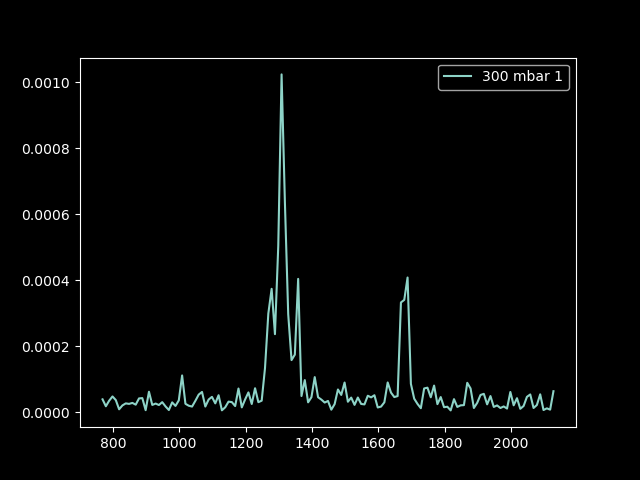

In [40]:
plt.clf()
path_pressure_tests_8 = './datas/amptests/h2o_6983_6678/p_tests/picoSignal_newLoop/'
cm300_8 = CEPAS_measurement(path_pressure_tests_8, prs_sig_300, col_names)
cols = list(cm300_8.spectra_list[0].columns)
plt.plot(cm300_8.spectra_list[0]['offset1'], cm300_8.spectra_list[0]['H2'], label="300 mbar 1")
# plt.plot(cm300_8.spectra_list[1]['offset1'], cm300_8.spectra_list[1]['H2'], label="300 mbar 2")
# plt.plot(cm300_8.spectra_list[2]['offset1'], cm300_8.spectra_list[2]['H2'], label="300 mbar 3")
plt.legend()
plt.show()

#### Good chopper runs (correct frequency $\approx 84\ \text{Hz}$)

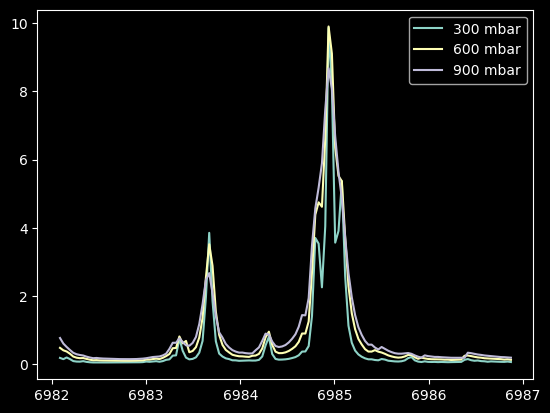

-0.0035223863013688714
6989.580829884108


In [41]:

%matplotlib inline
plt.clf()
units1 = [1678.7, 1313.7] # offsets decimal
units2 = [6983.6678, 6984.9534710] # wavenumbers
a = cp.get_wavenumber(1, units1, units2)[1]
b = cp.get_wavenumber(1, units1, units2)[2]
path_pressure_tests_9 = './datas/amptests/h2o_6983_6678/p_tests/33RH_84Hz_chopper_correct/'
cm300_9 = CEPAS_measurement(path_pressure_tests_9, prs_sig_300, col_names)
cm600_9 = CEPAS_measurement(path_pressure_tests_9, prs_sig_600, col_names)
cm900_9 = CEPAS_measurement(path_pressure_tests_9, prs_sig_900, col_names)
# line_300_9 = get_range(cm300_9.spectra_list[0], 'offset1', 6983.5, 6983.9)
# line_600_9 = get_range(cm600_9.spectra_list[0], 'offset1', 6983.5, 6983.9)
# line_900_9 = get_range(cm900_9.spectra_list[0], 'offset1', 6983.5, 6983.9)
# cols = list(cm300_7.spectra_list[0].columns)
# plt.plot(cm300_9.spectra_list[1]['offset1'], cm300_9.spectra_list[1]['H2_pnorm'], label="300 mbar")
# plt.plot(cm600_9.spectra_list[0]['offset1'], cm600_9.spectra_list[0]['H2_pnorm'], label="600 mbar")
# plt.plot(cm900_9.spectra_list[0]['offset1'], cm900_9.spectra_list[0]['H2_pnorm'], label="900 mbar")
plt.plot(a*cm300_9.spectra_list[2]['offset1']+b, cm300_9.spectra_list[2]['H2_pnorm'], label="300 mbar")
plt.plot(a*cm600_9.spectra_list[2]['offset1']+b, cm600_9.spectra_list[2]['H2_pnorm'], label="600 mbar")
plt.plot(a*cm900_9.spectra_list[2]['offset1']+b, cm900_9.spectra_list[2]['H2_pnorm'], label="900 mbar")
plt.legend()
plt.show()
print(a)
print(b)

#### Current -> offsets -> wavenumbers

We can convert from current to offsets. And from offsets to wavenumbers.

Then we convert from current to wavenumbers.

`get_wavenumber()` is general enough, lets go to lab

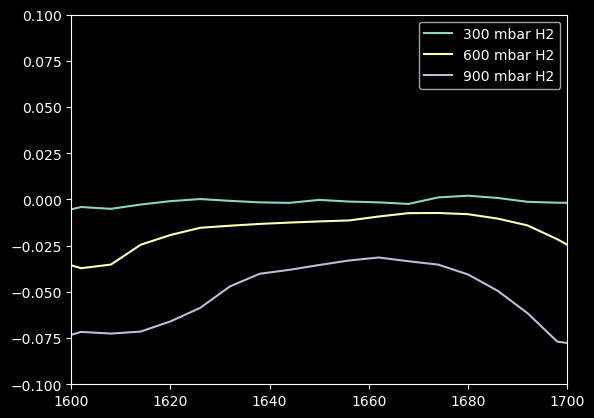

In [42]:
plt.clf()
path_pressure_tests_10 = './datas/FilteredSignal/2/'
cm300_10 = CEPAS_measurement(path_pressure_tests_10, prs_sig_300, col_names)
cm600_10 = CEPAS_measurement(path_pressure_tests_10, prs_sig_600, col_names)
cm900_10 = CEPAS_measurement(path_pressure_tests_10, prs_sig_900, col_names)
cols = list(cm300_10.spectra_list[0].columns)
plt.plot(cm300_10.spectra_list[0]['offset1'], cm300_10.spectra_list[0]['H2_pnorm'], label="300 mbar H2")
# plt.plot(cm300_10.spectra_list[1]['offset1'], cm300_10.spectra_list[1]['H2_pnorm'], label="300 mbar H2")
plt.plot(cm600_10.spectra_list[0]['offset1'], cm600_10.spectra_list[0]['H2_pnorm'], label="600 mbar H2")
# plt.plot(cm600_10.spectra_list[1]['offset1'], cm300_10.spectra_list[1]['H2_pnorm'], label="300 mbar H2")
plt.plot(cm900_10.spectra_list[0]['offset1'], cm900_10.spectra_list[0]['H2_pnorm'], label="900 mbar H2")
# plt.plot(cm900_10.spectra_list[1]['offset1'], cm900_10.spectra_list[1]['H2_pnorm'], label="900 mbar H2")
plt.vlines([1440], ymin=-0.2, ymax=0.2, colors=['red'])
plt.legend()
plt.xlim((1600, 1700))
plt.ylim(-0.1, 0.1)
plt.show()

# For microphone noise spectra (acoustic freq)

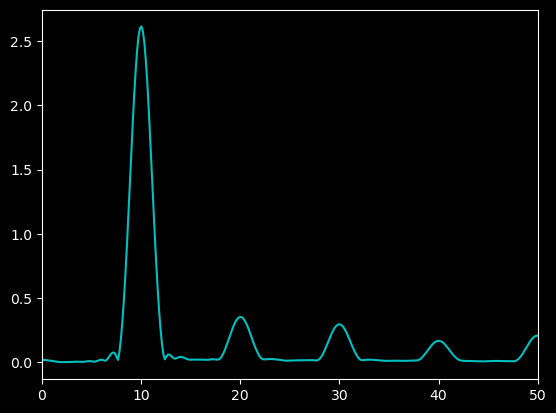

In [43]:
%matplotlib inline
noise_path = './datas/noise_tests/spectrum_20082025'
noise_x10_avg = './datas/noise_tests/spectrum_21082025_0_x10'
noise_x10_avg_84Hz = './datas/noise_tests/spectrum_21082025_0_x10_84Hz'
noise_x10_avg_84Hz_gasx_RH35 = './datas/noise_tests/spectrum_21082025_0_x10_84Hz_gasx_RH35'
# df = pd.read_csv(noise_path, sep=r'\s+', header=None, names=['freq', 'intensity'])
df = pd.read_csv(noise_x10_avg, sep=r'\s+', header=None, names=['freq', 'intensity'])
# df = pd.read_csv(noise_x10_avg_84Hz, sep=r'\s+', header=None, names=['freq', 'intensity'])
# df = pd.read_csv(noise_x10_avg_84Hz_gasx_RH35, sep=r'\s+', header=None, names=['freq', 'intensity'])
plt.plot(df['freq'], df['intensity'], 'c-')
plt.xlim(0, 50)
plt.show()

# Benchmark #1

First, we establish the paths of the noise and measurement data directories:

In [44]:
benchmark_path = "./datas/benchmark/1/measurements/"
benchmark_noise = "./datas/benchmark/1/noise/"

Now, we need to figure out the grouping, the most efficient way to display the results. Used frequencies are
$
\begin{equation}
f \in \left\{20, 30, 40, 80, 90, 130, 170, 220, 300\right\}\ \left[\text{Hz}\right],
\end{equation}
$

In [45]:
freq_list_2 = [20, 30, 40, 80, 90, 130, 170, 220, 300]


and we have three measurements of each frequency, at three different pressures, namely:
$
\begin{equation}
p \in \left\{300,600,900\right\}\ \left[\text{mbar}\right]
\end{equation}
$


In [46]:
pressure_list = [300, 600, 900]

So the total amount of measurements is $n = 3\times9\times3=27\times3$. Of each $p$ and $f$, those three measurements are meant to be averaged.
And the top three points (peak, left to peak and right to peak) are meant to be fit to some arbitrary function (for example spline or some
gaussian-like function). Physicality here is not as important as consistency throughout the analysis.

Also, need to determine the noise from some relatively flat region in the spectrum.

Also, need to create wavenumber axis for the all the spectra.

In [47]:
patterns = cp.create_regex_strings(pressure_list, freq_list_2)

test_bench_files = cp.dir_match_dict(benchmark_path, patterns) 
pp.pprint(patterns)
pp.pprint(test_bench_files)

{300: {20: re.compile('gasx_300_(12|24|32)_20__msr__[0-9]{1,2}'),
       30: re.compile('gasx_300_(12|24|32)_30__msr__[0-9]{1,2}'),
       40: re.compile('gasx_300_(12|24|32)_40__msr__[0-9]{1,2}'),
       80: re.compile('gasx_300_(12|24|32)_80__msr__[0-9]{1,2}'),
       90: re.compile('gasx_300_(12|24|32)_90__msr__[0-9]{1,2}'),
       130: re.compile('gasx_300_(12|24|32)_130__msr__[0-9]{1,2}'),
       170: re.compile('gasx_300_(12|24|32)_170__msr__[0-9]{1,2}'),
       220: re.compile('gasx_300_(12|24|32)_220__msr__[0-9]{1,2}'),
       300: re.compile('gasx_300_(12|24|32)_300__msr__[0-9]{1,2}')},
 600: {20: re.compile('gasx_600_(12|24|32)_20__msr__[0-9]{1,2}'),
       30: re.compile('gasx_600_(12|24|32)_30__msr__[0-9]{1,2}'),
       40: re.compile('gasx_600_(12|24|32)_40__msr__[0-9]{1,2}'),
       80: re.compile('gasx_600_(12|24|32)_80__msr__[0-9]{1,2}'),
       90: re.compile('gasx_600_(12|24|32)_90__msr__[0-9]{1,2}'),
       130: re.compile('gasx_600_(12|24|32)_130__msr__[0-9]{1,2}'),

 We have done some data logistics, now, for the flow of analysis.

 For each pressure/frequency:

1) Get those three measurements into `CEPAS_measurement` object DONE

2) Apply averaging DONE

3) Add wavenumber axis DONE

4) Find the test peak DONE

5) Do the fit for those top 3 peak points, determine __peak height__ DONE

6) Determine the noise at some flat region DONE

7) Determine the SNR (signal to noise ratio) DONE

8) Make some automation to do this for any number of different measurements DONE

## Work on spectra

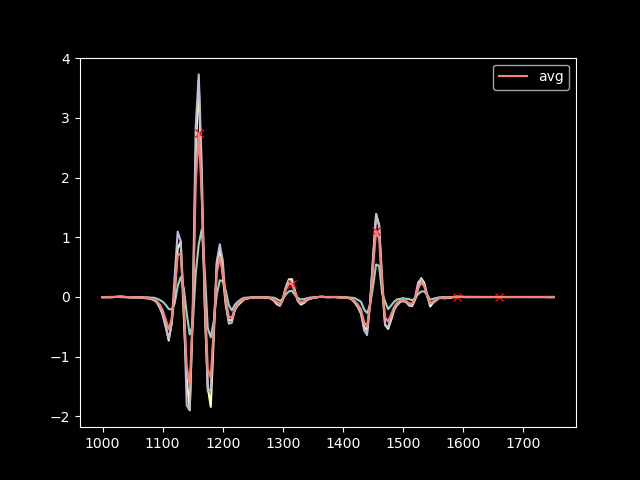

In [48]:
u1 = [1158.9, 1452.0]
u2 = [6984.9534710, 6983.6678]

# REMINDER frequencies: [20, 30, 40, 80, 90, 130, 170, 220, 300]
p = 300
f = 40
bench_test = CEPAS_benchmark(benchmark_path, test_bench_files, p, f)
# bench_test.self_test()
bench_test.add_wav(u1, u2)
test_avg = bench_test.get_avg()
target_peak = (1400, 1550)
bench_peaks = find_peaks_cwt(test_avg['H2_pnorm'], 10.0)
# print(bench_peaks)
# print(test_300_20)
%matplotlib widget
plt.ion()
plt.close()
plt.figure()
# 1st test
plt.plot(bench_test.spectra.spectra_list[0]['offset1'], bench_test.spectra.spectra_list[0]['H2_pnorm'])
plt.plot(bench_test.spectra.spectra_list[1]['offset1'], bench_test.spectra.spectra_list[1]['H2_pnorm'])
plt.plot(bench_test.spectra.spectra_list[2]['offset1'], bench_test.spectra.spectra_list[2]['H2_pnorm'])
plt.plot(test_avg['offset1'][bench_peaks], test_avg['H2_pnorm'][bench_peaks], 'rx')
plt.plot(test_avg['offset1'], test_avg['H2_pnorm'], label='avg')
plt.legend()
# plt.xlim(1625, 1750)
# plt.ylim(-0.008, -0.0015)
plt.show()

## Work on signal

### See all analysis peaks (one peak in all different spectra)

uncomment below cell to see

In [49]:
# plt.close()
# ps = [300, 600, 900]
# fs = [20, 30, 40, 80, 90, 130, 170, 220, 300]
# for p, f in itertools.product(ps, fs):
#     bench_test = CEPAS_benchmark(benchmark_path, test_bench_files, p, f)
#     peak_start = 1400
#     peak_end = 1510
#     peak = bench_test.get_window(peak_start, peak_end)
#     peak_spline = bench_test.get_spline_of_window(n_spectrum=-1, n_knots=11, start=peak_start, end=peak_end)
#     # print(peak_spline[1])
#     print(peak_spline[-1])
#     plt.figure()
#     plt.plot(peak[0]['offset1'], peak[0]['H2_pnorm'])
#     plt.plot(peak[1]['offset1'], peak[1]['H2_pnorm'])
#     plt.plot(peak[2]['offset1'], peak[2]['H2_pnorm'])
#     plt.plot(peak[3]['offset1'], peak[3]['H2_pnorm'], label='avg')
#     plt.scatter(peak_spline[2]['offset1'], peak_spline[2]['H2_pnorm'], label='spline of avg')
#     plt.plot(peak_spline[-2]['offset1'], peak_spline[-2]['H2_pnorm'], 'rx')
#     plt.legend()
#     plt.title(f"p={p}, f={f}")
#     plt.show()


# peak_spline[-2]['H2_pnorm']

## Work on noise

[[Model]]
    Model(spline_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 24
    # variables        = 10
    chi-square         = 9.1539e-07
    reduced chi-square = 6.5385e-08
    Akaike info crit   = -389.967148
    Bayesian info crit = -378.186610
    R-squared          = 0.85121937
[[Variables]]
    s0: -0.00147772 +/- 7.2445e-04 (49.02%) (init = -0.0008392455)
    s1: -7.1751e-05 +/- 6.6978e-04 (933.48%) (init = -0.0005895682)
    s2: -8.0332e-04 +/- 5.1670e-04 (64.32%) (init = -0.000296656)
    s3: -1.0708e-04 +/- 3.3720e-04 (314.90%) (init = -0.0004476792)
    s4: -9.5810e-04 +/- 3.3984e-04 (35.47%) (init = -0.0004861219)
    s5:  5.1040e-04 +/- 3.3984e-04 (66.58%) (init = 6.373472e-05)
    s6: -4.5202e-04 +/- 3.3720e-04 (74.60%) (init = -0.000397626)
    s7: -4.7769e-04 +/- 5.1670e-04 (108.16%) (init = -0.000647019)
    s8: -0.00192622 +/- 6.6978e-04 (34.77%) (init = -0.001286293)
    s9: -0.00195570 +/- 7.2445e-0

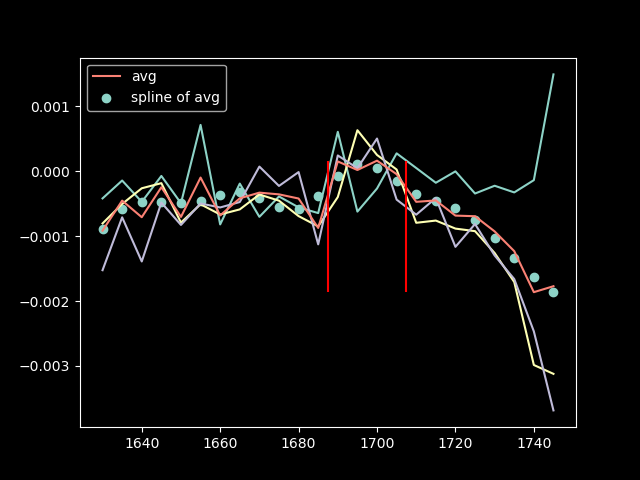

          0         1         2
0  0.000606 -0.000399  0.000242
1 -0.000623  0.000631  0.000046
2 -0.000267  0.000250  0.000502
3  0.000274  0.000025 -0.000438
Horizontal stdevs
['4.746455e-04', '3.725839e-04', '3.441535e-04', '8.795882e-05', '1.052658e-04']
0.000397127623362662
Vertical stdevs
['4.152093e-04', '5.120231e-04', '3.201946e-04', '2.950955e-04']
0.0003856306185754935


In [50]:
%matplotlib widget
flat_regions = bench_test.get_window()
spline_of_avg = bench_test.get_spline_of_window(n_knots=10)
print(spline_of_avg[1])
print(len(flat_regions[3]))
plt.close()
plt.figure()
plt.plot(flat_regions[0]['offset1'], flat_regions[0]['H2_pnorm'])
plt.plot(flat_regions[1]['offset1'], flat_regions[1]['H2_pnorm'])
plt.plot(flat_regions[2]['offset1'], flat_regions[2]['H2_pnorm'])
plt.plot(flat_regions[3]['offset1'], flat_regions[3]['H2_pnorm'], label='avg')
plt.scatter(spline_of_avg[0]['offset1'], spline_of_avg[0]['H2_pnorm'], label='spline of avg')
plt.legend()
plt.vlines([1687.5, 1707.5], ymin=flat_regions[3]['H2_pnorm'].min(), ymax=flat_regions[3]['H2_pnorm'].max(), colors=['red', 'red'])
plt.show()

flat_regions_dict = {
    '0': flat_regions[0],
    '1': flat_regions[1],
    '2': flat_regions[2],
    'avg': flat_regions[3],
    'avg_spline': spline_of_avg[0]
}

stdevs_horizontal = []
stdevs_vertical = []
for k, v in flat_regions_dict.items():
    df = flat_regions_dict[k]
    flat_regions_dict[k] = df[(df['offset1'] > 1687.5) & (df['offset1'] < 1707.5)]
    df = flat_regions_dict[k]
    stdevs_horizontal.append(df['H2_pnorm'].std(ddof=0))

df_std = pd.DataFrame({k: v.reset_index()['H2_pnorm'] for k, v in flat_regions_dict.items()})
df_std = df_std.loc[:,'0':'2']
for i in range(4):
    stdevs_vertical.append(df_std.iloc[i].T.std(ddof=0))
print(df_std)

print('Horizontal stdevs')
print([np.format_float_scientific(i, precision=6) for i in stdevs_horizontal])
print(np.average(np.array(stdevs_horizontal[0:3])))

print('Vertical stdevs')
print([np.format_float_scientific(i, precision=6) for i in stdevs_vertical])
print(np.average(np.array(stdevs_vertical[0:4])))

In [51]:
print((1.548e-4 + 2.796e-4 + 2.618e-4 + 4.099e-4) / 4)
print((1.548e-4 + 2.796e-4 + 2.618e-4) / 4)
print(( + 2.796e-4 + 2.618e-4 + 4.099e-4) / 4)
print(np.std([3.79e-4, 6.69e-4, 7.29e-4]))

0.000276525
0.00017405000000000003
0.000237825
0.00015282524515130202


We can do horizontal and vertical evaluation of stddevs in the region, say, 

6.353e-05


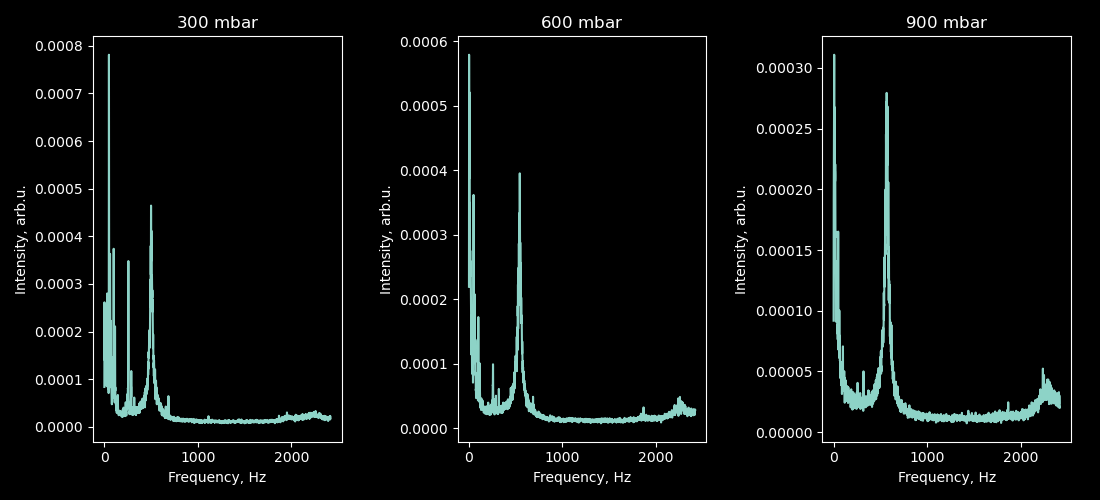

In [52]:
bench_noise_300 = CEPAS_noise_info(benchmark_noise, 300, 3)
bench_noise_600 = CEPAS_noise_info(benchmark_noise, 600, 3)
bench_noise_900 = CEPAS_noise_info(benchmark_noise, 900, 3)


# bench_noise_300 = CEPAS_noise_info(benchmark_noise, 300, 2)
# bench_noise_600 = CEPAS_noise_info(benchmark_noise, 600, 2)
# bench_noise_900 = CEPAS_noise_info(benchmark_noise, 900, 2)
print(f"{np.format_float_scientific(bench_noise_300.get_noise_at(f), precision=3)}")
plt.close()
plt.figure(figsize=(11, 5))
plt.subplot(131)
plt.title("$300\\ \\text{mbar}$")
plt.xlabel('Frequency, Hz')
plt.ylabel('Intensity, arb.u.')
plt.plot(bench_noise_300.spectrum['freq'], bench_noise_300.spectrum['intensity'])
plt.subplot(132)
plt.title("$600\\ \\text{mbar}$")
plt.xlabel('Frequency, Hz')
plt.ylabel('Intensity, arb.u.')
plt.plot(bench_noise_600.spectrum['freq'], bench_noise_600.spectrum['intensity'])
plt.subplot(133)
plt.title("$900\\ \\text{mbar}$")
plt.xlabel('Frequency, Hz')
plt.ylabel('Intensity, arb.u.')
plt.plot(bench_noise_900.spectrum['freq'], bench_noise_900.spectrum['intensity'])
plt.tight_layout()
plt.show()

## Work on noise #2

In [53]:
noise_2_dict = cp.dir_match_dict(benchmark_noise, patterns)
pp.pprint(noise_2_dict)

{300: {20: ['gasx_300_12_20__msr__0'],
       30: ['gasx_300_12_30__msr__0'],
       40: ['gasx_300_12_40__msr__0'],
       80: ['gasx_300_12_80__msr__0'],
       90: ['gasx_300_12_90__msr__0'],
       130: ['gasx_300_12_130__msr__0'],
       170: ['gasx_300_12_170__msr__0'],
       220: ['gasx_300_12_220__msr__0'],
       300: ['gasx_300_12_300__msr__0']},
 600: {20: ['gasx_600_24_20__msr__0'],
       30: ['gasx_600_24_30__msr__0'],
       40: ['gasx_600_24_40__msr__0'],
       80: ['gasx_600_24_80__msr__0'],
       90: ['gasx_600_24_90__msr__0'],
       130: ['gasx_600_24_130__msr__0'],
       170: ['gasx_600_24_170__msr__0'],
       220: ['gasx_600_24_220__msr__0'],
       300: ['gasx_600_24_300__msr__0']},
 900: {20: ['gasx_900_32_20__msr__0'],
       30: ['gasx_900_32_30__msr__0'],
       40: ['gasx_900_32_40__msr__0'],
       80: ['gasx_900_32_80__msr__0'],
       90: ['gasx_900_32_90__msr__0'],
       130: ['gasx_900_32_130__msr__0'],
       170: ['gasx_900_32_170__msr__0'],
   

### See all noises

uncomment below to see

In [54]:
# plt.close()
# new_noise_dict = {}
# n = 3
# y = 'H2'
# for k1 in noise_2_dict.keys():
#     new_noise_dict[k1] = {}
#     for k2, v2 in noise_2_dict[k1].items():

#         cm = CEPAS_measurement(path=benchmark_noise, path_signature=noise_2_dict[k1][k2][0], cols=col_names)
#         df = cm.spectra_list[0]
#         new_df, std, outliers = std_range(df, y, n)
#         Q1 = df[y].quantile(0.25)
#         Q3 = df[y].quantile(0.75)
#         IQR = Q3 - Q1

#         new_noise_dict[k1][k2] = std
#         plt.figure()
#         plt.plot(df.index, df[y], label=f"std = {std:.2e}")
#         plt.hlines([Q1-n*IQR, Q3+n*IQR], xmin=df.index.min(), xmax=df.index.max(), colors=['red', 'red'])
#         plt.legend()
#         plt.show()

## Compilation of all benchmark measurements

Stack 3 barplots (for each pressure), 3 bars for each method of SNR, for all frequencies

In [55]:
noise_start = 1625
noise_end = 1750
peak_start = 1400
peak_end = 1510
bench_final = CEPAS_SNR_bench(test_bench_files,
                              bench_path=benchmark_path,
                              noise_path=benchmark_noise,
                              noise_number=3)
get_all = bench_final.get_all_snrs([peak_start, noise_start],
                                   [peak_end, noise_end]) # float=1625, end: int | float=1750
df_snr = get_all[0]
df_noise = get_all[1]

DEBUG: At p=300                         and f=20 signal is 
---->46    2.911173
Name: H2_pnorm, dtype: float64<----

noise from single measurements: 4.8372113146410214e-05
DEBUG: At p=300                         and f=30 signal is 
---->45    2.224632
Name: H2_pnorm, dtype: float64<----

noise from single measurements: 9.129458950561538e-05
DEBUG: At p=300                         and f=40 signal is 
---->52    0.936699
Name: H2_pnorm, dtype: float64<----

noise from single measurements: 5.2837818457103444e-05
DEBUG: At p=300                         and f=80 signal is 
---->52    0.580258
Name: H2_pnorm, dtype: float64<----

noise from single measurements: 2.163749964113473e-05
DEBUG: At p=300                         and f=90 signal is 
---->51    0.553854
Name: H2_pnorm, dtype: float64<----

noise from single measurements: 2.5305314898033517e-05
DEBUG: At p=300                         and f=130 signal is 
---->50    0.33215
Name: H2_pnorm, dtype: float64<----

noise from single measure

In [56]:
type(df_snr[300][40][0])
df_snr[300][40][0]

7630.392887988096

In [57]:
df_snr.columns[0]

np.int64(300)

/tmp/ipykernel_2291/3890161570.py:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


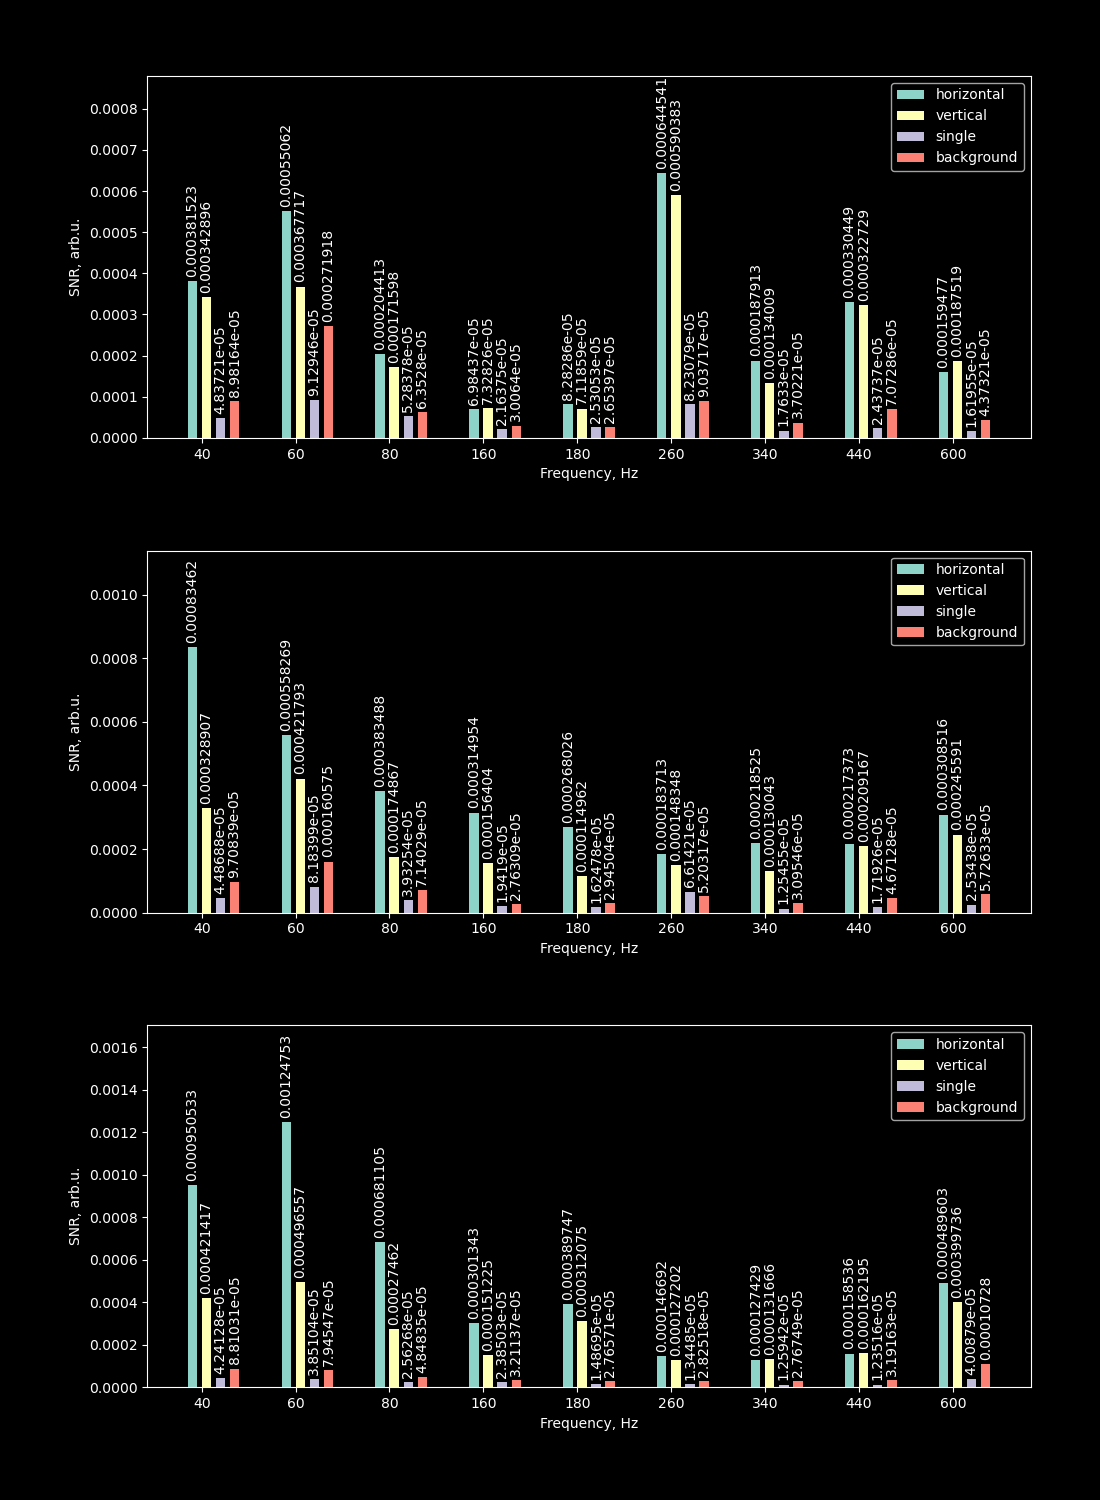

In [58]:
norm_factor300 = np.divide(1, np.array([df_snr[300][f][2] for f in df_snr.index]).max())
norm_factor600 = np.divide(1, np.array([df_snr[300][f][2] for f in df_snr.index]).max())
norm_factor900 = np.divide(1, np.array([df_snr[300][f][2] for f in df_snr.index]).max())

noises300 = {
    'horizontal': [df_noise[300][f][0] for f in df_snr.index],
    'vertical': [df_noise[300][f][1] for f in df_snr.index],
    'single': [df_noise[300][f][2] for f in df_snr.index],
    'background': [df_noise[300][f][3] for f in df_snr.index]
}

noises600 = {
    'horizontal': [df_noise[600][f][0] for f in df_snr.index],
    'vertical': [df_noise[600][f][1] for f in df_snr.index],
    'single': [df_noise[600][f][2] for f in df_snr.index],
    'background': [df_noise[600][f][3] for f in df_snr.index]
}

noises900 = {
    'horizontal': [df_noise[900][f][0] for f in df_snr.index],
    'vertical': [df_noise[900][f][1] for f in df_snr.index],
    'single': [df_noise[900][f][2] for f in df_snr.index],
    'background': [df_noise[900][f][3] for f in df_snr.index]
}

frequencies = df_snr.index
x = np.arange(len(frequencies))
width = 0.1
multiplier = 0
spacing = 0.05
top_align = 1.3

plt.close()
plt.figure(figsize=(11, 15), constrained_layout=True)

ax1 = plt.subplot(311)
for k, v in noises300.items():
    offset = (width+spacing) * multiplier
    rects = ax1.bar(x+offset, v, width, label=k)
    ax1.bar_label(rects, rotation=90, padding=3)
    multiplier += 1
ax1.set_xticks(x+width, np.round(list(frequencies), 2))
ax1.set_xlabel('Frequency, Hz')
ax1.set_ylabel('SNR, arb.u.')
old_top = ax1.get_ylim()[1]
new_top = old_top*top_align
ax1.set_ylim(top=new_top)
ax1.legend()
multiplier = 0

ax2 = plt.subplot(312)
for k, v in noises600.items():
    offset = (width+spacing) * multiplier
    rects = ax2.bar(x+offset, v, width, label=k)
    ax2.bar_label(rects, rotation=90, padding=3)
    multiplier += 1
ax2.set_xticks(x+width, np.round(list(frequencies), 2))
ax2.set_xlabel('Frequency, Hz')
ax2.set_ylabel('SNR, arb.u.')
old_top = ax2.get_ylim()[1]
new_top = old_top*top_align
ax2.set_ylim(top=new_top)
ax2.legend()
multiplier = 0

ax3 = plt.subplot(313)
for k, v in noises900.items():
    offset = (width+spacing) * multiplier
    rects = ax3.bar(x+offset, v, width, label=k)
    ax3.bar_label(rects, rotation=90, padding=3)
    multiplier += 1
ax3.set_xticks(x+width, np.round(list(frequencies), 2))
ax3.set_xlabel('Frequency, Hz')
ax3.set_ylabel('SNR, arb.u.')
old_top = ax3.get_ylim()[1]
new_top = old_top*top_align
ax3.set_ylim(top=new_top)
ax3.legend()

plt.tight_layout(pad=5)
plt.show()

/tmp/ipykernel_2291/1995773126.py:73: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


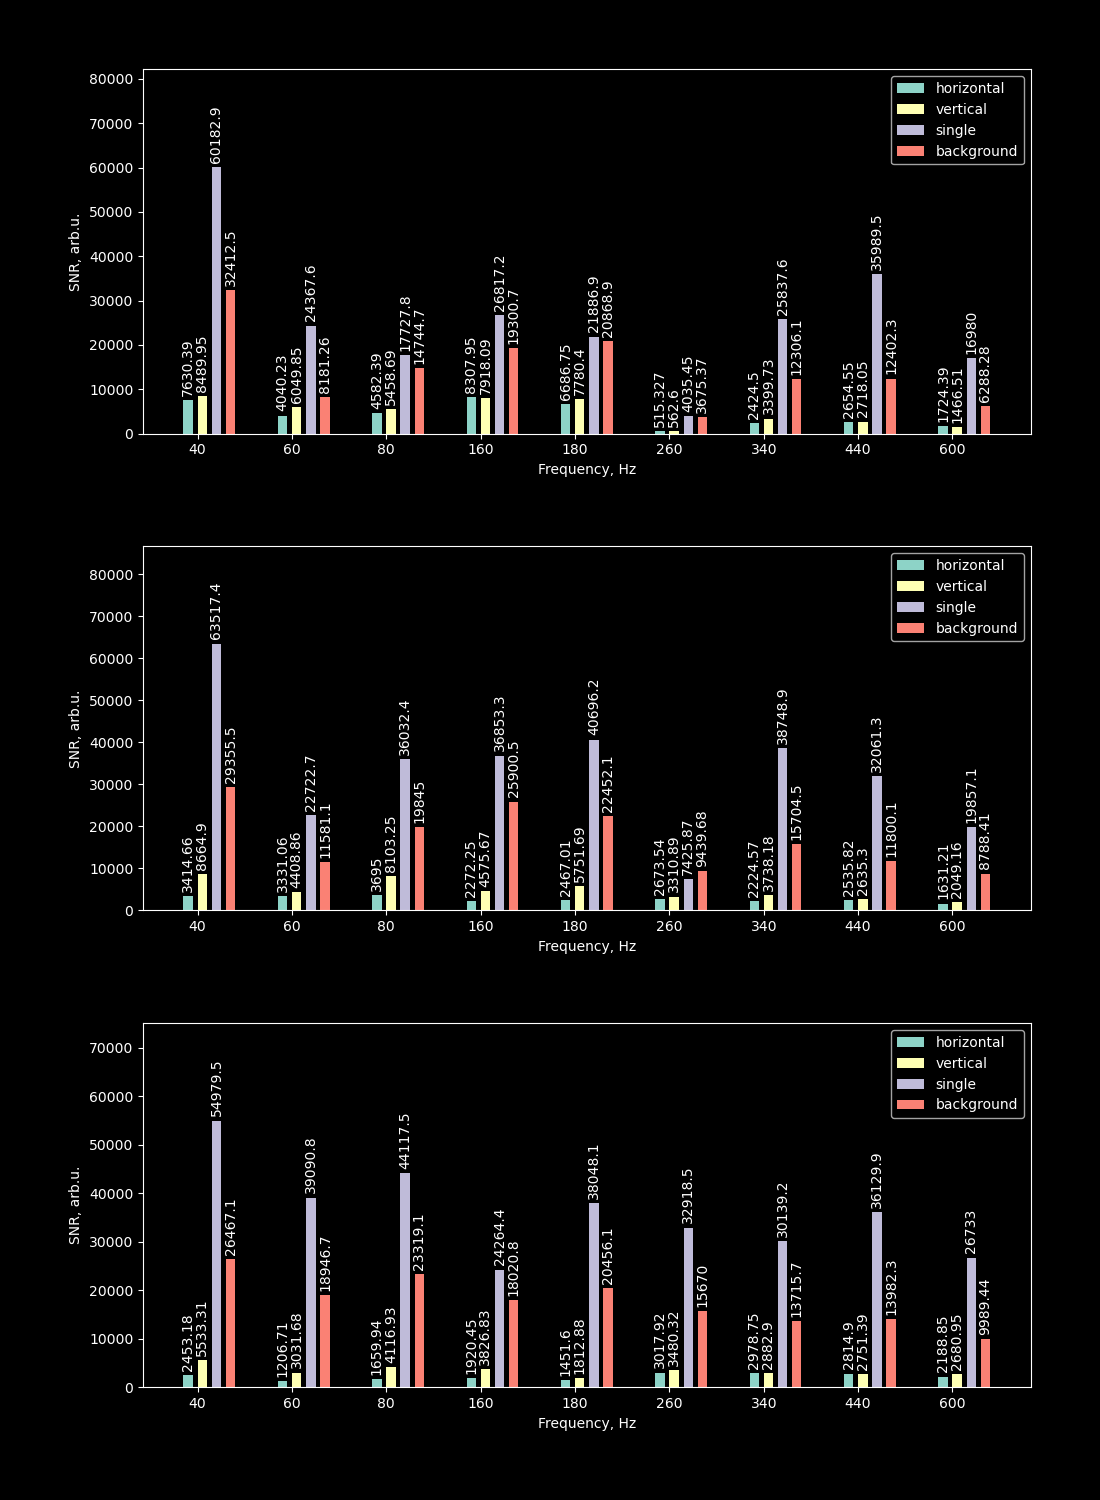

In [59]:
noises300 = {
    'horizontal': [df_snr[300][f][0] for f in df_snr.index],
    'vertical': [df_snr[300][f][1] for f in df_snr.index],
    'single': [df_snr[300][f][2] for f in df_snr.index],
    'background': [df_snr[300][f][3] for f in df_snr.index]
}

noises600 = {
    'horizontal': [df_snr[600][f][0] for f in df_snr.index],
    'vertical': [df_snr[600][f][1] for f in df_snr.index],
    'single': [df_snr[600][f][2] for f in df_snr.index],
    'background': [df_snr[600][f][3] for f in df_snr.index]
}

noises900 = {
    'horizontal': [df_snr[900][f][0] for f in df_snr.index],
    'vertical': [df_snr[900][f][1] for f in df_snr.index],
    'single': [df_snr[900][f][2] for f in df_snr.index],
    'background': [df_snr[900][f][3] for f in df_snr.index]
}




multiplier = 0
plt.close()
plt.figure(figsize=(11, 15), constrained_layout=True)

ax1 = plt.subplot(311)
for k, v in noises300.items():
    offset = (width+spacing) * multiplier
    rects = ax1.bar(x+offset, v, width, label=k)
    ax1.bar_label(rects, rotation=90, padding=3)
    multiplier += 1
ax1.set_xticks(x+width, np.round(list(frequencies), 2))
ax1.set_xlabel('Frequency, Hz')
ax1.set_ylabel('SNR, arb.u.')
old_top = ax1.get_ylim()[1]
new_top = old_top*top_align
ax1.set_ylim(top=new_top)
ax1.legend()
multiplier = 0

ax2 = plt.subplot(312)
for k, v in noises600.items():
    offset = (width+spacing) * multiplier
    rects = ax2.bar(x+offset, v, width, label=k)
    ax2.bar_label(rects, rotation=90, padding=3)
    multiplier += 1
ax2.set_xticks(x+width, np.round(list(frequencies), 2))
ax2.set_xlabel('Frequency, Hz')
ax2.set_ylabel('SNR, arb.u.')
old_top = ax2.get_ylim()[1]
new_top = old_top*top_align
ax2.set_ylim(top=new_top)
ax2.legend()
multiplier = 0

ax3 = plt.subplot(313)
for k, v in noises900.items():
    offset = (width+spacing) * multiplier
    rects = ax3.bar(x+offset, v, width, label=k)
    ax3.bar_label(rects, rotation=90, padding=3)
    multiplier += 1
ax3.set_xticks(x+width, np.round(list(frequencies), 2))
ax3.set_xlabel('Frequency, Hz')
ax3.set_ylabel('SNR, arb.u.')
old_top = ax3.get_ylim()[1]
new_top = old_top*top_align
ax3.set_ylim(top=new_top)
ax3.legend()

plt.tight_layout(pad=5)
plt.show()

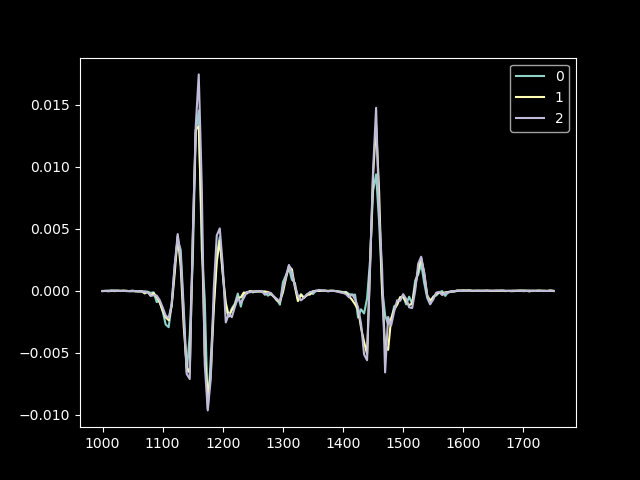

In [60]:
foam_path = "./datas/benchmark/2/measurements/"
df_foam_test = CEPAS_measurement(foam_path, "gasx_300_.+_300__.+", col_names)
x = df_foam_test.spectra_list[0]['offset1']
x1 = df_foam_test.spectra_list[1]['offset1']
x2 = df_foam_test.spectra_list[2]['offset1']
y = df_foam_test.spectra_list[0]['H2']
y1 = df_foam_test.spectra_list[1]['H2']
y2 = df_foam_test.spectra_list[2]['H2']
%matplotlib widget
plt.close()
plt.figure()
plt.plot(x, y, label="0")
plt.plot(x1, y1, label="1")
plt.plot(x2, y2, label="2")
plt.legend()
plt.show()
# df_foam_test.spectra_list[0]

# Benchmark #2

## Initial

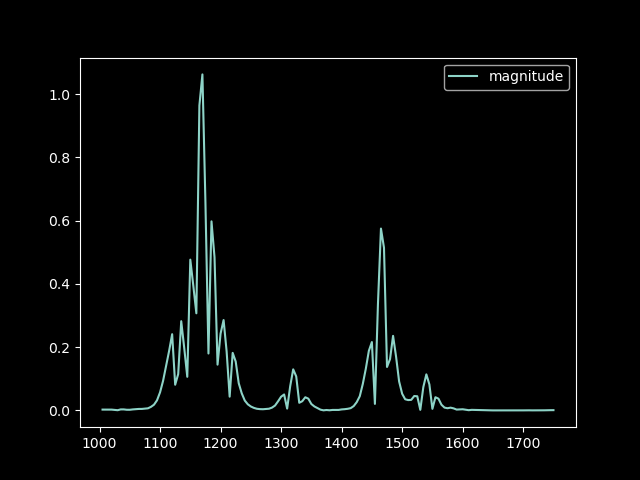

In [96]:
benchmark_path_2 = "./datas/benchmark/2/measurements/"
benchmark_noise_2 = "./datas/benchmark/2/noise/"

u1 = [1158.1, 1452.7]
u2 = [6984.9534710, 6983.6678]

# REMINDER frequencies: [20, 30, 40, 80, 90, 130, 170, 220, 300]
p = 300
f = 40
bench_test_2 = CEPAS_benchmark(benchmark_path_2, test_bench_files, p, f)
# bench_test.self_test()
bench_test_2.add_wav(u1, u2)
test_avg = bench_test_2.get_avg()
target_peak = (1400, 1550)
bench_peaks = find_peaks_cwt(test_avg['H2_pnorm'], 10.0)
# print(bench_peaks)
# print(test_300_20)
%matplotlib widget
plt.ion()
plt.close()
plt.figure()
# 1st test
# plt.plot(bench_test_2.spectra.spectra_list[0]['offset1'], bench_test_2.spectra.spectra_list[0]['H2_pnorm'])
# plt.plot(bench_test_2.spectra.spectra_list[1]['offset1'], bench_test_2.spectra.spectra_list[1]['H2_pnorm'])
# plt.plot(bench_test_2.spectra.spectra_list[2]['offset1'], bench_test_2.spectra.spectra_list[2]['H2_pnorm'])
# plt.plot(test_avg['offset1'][bench_peaks], test_avg['H2_pnorm'][bench_peaks], 'rx')
# plt.plot(test_avg['offset1'], test_avg['H2_pnorm'], label='avg')

# test magnitude
abs_test = np.sqrt(test_avg['H2_pnorm']**2 + test_avg['H3_pnorm']**2)
plt.plot(test_avg['offset1'], abs_test, label="magnitude")

plt.legend()
# plt.xlim(1625, 1750)
# plt.ylim(-0.008, -0.0015)
plt.show()

## Signal

### See all peaks

uncomment below

In [97]:
# plt.close()
# ps = [300, 600, 900]
# fs = [20, 30, 40, 80, 90, 130, 170, 220, 300]
# for p, f in itertools.product(ps, fs):
#     bench_test = CEPAS_benchmark(benchmark_path_2, test_bench_files, p, f)
#     peak_start = 1400
#     peak_end = 1510
#     peak = bench_test.get_window(peak_start, peak_end)
#     peak_spline = bench_test.get_spline_of_window(n_spectrum=-1, n_knots=11, start=peak_start, end=peak_end)
#     # print(peak_spline[1])
#     print(peak_spline[-1])
#     plt.figure()
#     plt.plot(peak[0]['offset1'], peak[0]['H2_pnorm'])
#     plt.plot(peak[1]['offset1'], peak[1]['H2_pnorm'])
#     plt.plot(peak[2]['offset1'], peak[2]['H2_pnorm'])
#     plt.plot(peak[3]['offset1'], peak[3]['H2_pnorm'], label='avg')
#     plt.scatter(peak_spline[2]['offset1'], peak_spline[2]['H2_pnorm'], label='spline of avg')
#     plt.plot(peak_spline[-2]['offset1'], peak_spline[-2]['H2_pnorm'], 'rx')
#     plt.legend()
#     plt.title(f"p={p}, f={f}")
#     plt.show()

## Noise

[[Model]]
    Model(spline_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 24
    # variables        = 10
    chi-square         = 9.1539e-07
    reduced chi-square = 6.5385e-08
    Akaike info crit   = -389.967148
    Bayesian info crit = -378.186610
    R-squared          = 0.85121937
[[Variables]]
    s0: -0.00147772 +/- 7.2445e-04 (49.02%) (init = -0.0008392455)
    s1: -7.1751e-05 +/- 6.6978e-04 (933.48%) (init = -0.0005895682)
    s2: -8.0332e-04 +/- 5.1670e-04 (64.32%) (init = -0.000296656)
    s3: -1.0708e-04 +/- 3.3720e-04 (314.90%) (init = -0.0004476792)
    s4: -9.5810e-04 +/- 3.3984e-04 (35.47%) (init = -0.0004861219)
    s5:  5.1040e-04 +/- 3.3984e-04 (66.58%) (init = 6.373472e-05)
    s6: -4.5202e-04 +/- 3.3720e-04 (74.60%) (init = -0.000397626)
    s7: -4.7769e-04 +/- 5.1670e-04 (108.16%) (init = -0.000647019)
    s8: -0.00192622 +/- 6.6978e-04 (34.77%) (init = -0.001286293)
    s9: -0.00195570 +/- 7.2445e-0

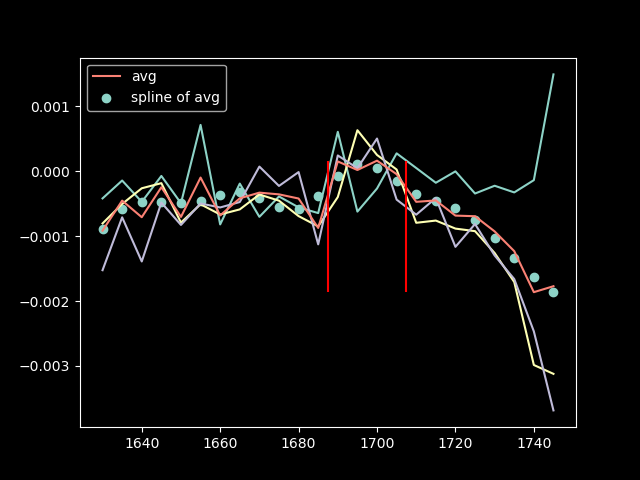

          0         1         2
0  0.000606 -0.000399  0.000242
1 -0.000623  0.000631  0.000046
2 -0.000267  0.000250  0.000502
3  0.000274  0.000025 -0.000438
Horizontal stdevs
['4.746455e-04', '3.725839e-04', '3.441535e-04', '8.795882e-05', '1.052658e-04']
0.000397127623362662
Vertical stdevs
['4.152093e-04', '5.120231e-04', '3.201946e-04', '2.950955e-04']
0.0003856306185754935


In [98]:
%matplotlib widget
flat_regions = bench_test.get_window()
spline_of_avg = bench_test.get_spline_of_window(n_knots=10)
print(spline_of_avg[1])
print(len(flat_regions[3]))
plt.close()
plt.figure()
plt.plot(flat_regions[0]['offset1'], flat_regions[0]['H2_pnorm'])
plt.plot(flat_regions[1]['offset1'], flat_regions[1]['H2_pnorm'])
plt.plot(flat_regions[2]['offset1'], flat_regions[2]['H2_pnorm'])
plt.plot(flat_regions[3]['offset1'], flat_regions[3]['H2_pnorm'], label='avg')
plt.scatter(spline_of_avg[0]['offset1'], spline_of_avg[0]['H2_pnorm'], label='spline of avg')
plt.legend()
plt.vlines([1687.5, 1707.5], ymin=flat_regions[3]['H2_pnorm'].min(), ymax=flat_regions[3]['H2_pnorm'].max(), colors=['red', 'red'])
plt.show()

flat_regions_dict = {
    '0': flat_regions[0],
    '1': flat_regions[1],
    '2': flat_regions[2],
    'avg': flat_regions[3],
    'avg_spline': spline_of_avg[0]
}

stdevs_horizontal = []
stdevs_vertical = []
for k, v in flat_regions_dict.items():
    df = flat_regions_dict[k]
    flat_regions_dict[k] = df[(df['offset1'] > 1687.5) & (df['offset1'] < 1707.5)]
    df = flat_regions_dict[k]
    stdevs_horizontal.append(df['H2_pnorm'].std(ddof=0))

df_std = pd.DataFrame({k: v.reset_index()['H2_pnorm'] for k, v in flat_regions_dict.items()})
df_std = df_std.loc[:,'0':'2']
for i in range(4):
    stdevs_vertical.append(df_std.iloc[i].T.std(ddof=0))
print(df_std)

print('Horizontal stdevs')
print([np.format_float_scientific(i, precision=6) for i in stdevs_horizontal])
print(np.average(np.array(stdevs_horizontal[0:3])))

print('Vertical stdevs')
print([np.format_float_scientific(i, precision=6) for i in stdevs_vertical])
print(np.average(np.array(stdevs_vertical[0:4])))

### See all noises

uncomment below

In [99]:
# plt.close()
# new_noise_dict = {}
# n = 3
# y = 'H2'
# for k1 in noise_2_dict.keys():
#     new_noise_dict[k1] = {}
#     for k2, v2 in noise_2_dict[k1].items():

#         cm = CEPAS_measurement(path=benchmark_noise_2, path_signature=noise_2_dict[k1][k2][0], cols=col_names)
#         df = cm.spectra_list[0]
#         new_df, std, outliers = std_range(df, y, n)
#         Q1 = df[y].quantile(0.25)
#         Q3 = df[y].quantile(0.75)
#         IQR = Q3 - Q1

#         new_noise_dict[k1][k2] = std
#         plt.figure()
#         plt.plot(df.index, df[y], label=f"std = {std:.2e}")
#         plt.hlines([Q1-n*IQR, Q3+n*IQR], xmin=df.index.min(), xmax=df.index.max(), colors=['red', 'red'])
#         plt.legend()
#         plt.show()

3.336e-05


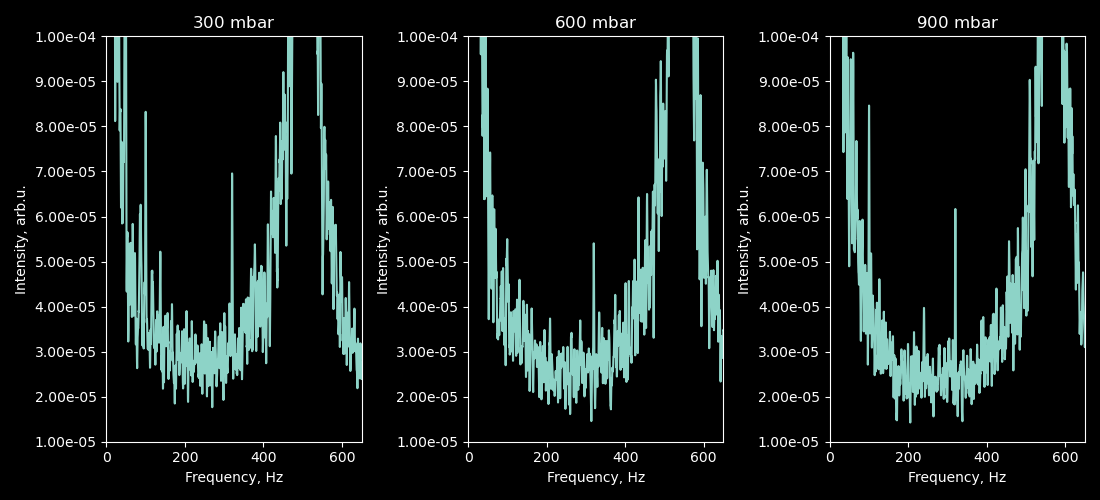

In [100]:
bench_noise_300_2 = CEPAS_noise_info(benchmark_noise_2, 300)
bench_noise_600_2 = CEPAS_noise_info(benchmark_noise_2, 600)
bench_noise_900_2 = CEPAS_noise_info(benchmark_noise_2, 900)


# bench_noise_300 = CEPAS_noise_info(benchmark_noise, 300, 2)
# bench_noise_600 = CEPAS_noise_info(benchmark_noise, 600, 2)
# bench_noise_900 = CEPAS_noise_info(benchmark_noise, 900, 2)
print(f"{np.format_float_scientific(bench_noise_300_2.get_noise_at(f), precision=3)}")
plt.close()
plt.figure(figsize=(11, 5))
ax1 = plt.subplot(131)
ax1.set_title("$300\\ \\text{mbar}$")
ax1.set_xlabel('Frequency, Hz')
ax1.set_ylabel('Intensity, arb.u.')
ax1.plot(bench_noise_300_2.spectrum['freq'], bench_noise_300_2.spectrum['intensity'])
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax1.set_xlim((0, 650))
ax1.set_ylim((1e-5, 1e-4))
ax2 = plt.subplot(132)
ax2.set_title("$600\\ \\text{mbar}$")
ax2.set_xlabel('Frequency, Hz')
ax2.set_ylabel('Intensity, arb.u.')
ax2.plot(bench_noise_600_2.spectrum['freq'], bench_noise_600_2.spectrum['intensity'])
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax2.set_xlim((0, 650))
ax2.set_ylim((1e-5, 1e-4))
ax3 = plt.subplot(133)
ax3.set_title("$900\\ \\text{mbar}$")
ax3.set_xlabel('Frequency, Hz')
ax3.set_ylabel('Intensity, arb.u.')
ax3.plot(bench_noise_900_2.spectrum['freq'], bench_noise_900_2.spectrum['intensity'])
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax3.set_xlim((0, 650))
ax3.set_ylim((1e-5, 1e-4))
plt.tight_layout()
plt.show()

## Compilation

In [101]:
noise_start_2 = 1625
noise_end_2 = 1750
peak_start_2 = 1400
peak_end_2 = 1510
bench_final_2 = CEPAS_SNR_bench(test_bench_files, bench_path=benchmark_path_2, noise_path=benchmark_noise_2)
get_all_2 = bench_final_2.get_all_snrs([peak_start_2, noise_start_2], [peak_end_2, noise_end_2]) # float=1625, end: int | float=1750
df_snr_2 = get_all_2[0]
df_noise_2 = get_all_2[1]

DEBUG: At p=300                         and f=20 signal is 
---->46    0.910724
Name: H2_pnorm, dtype: float64<----

noise from single measurements: 3.5342997290930734e-05
DEBUG: At p=300                         and f=30 signal is 
---->46    0.619257
Name: H2_pnorm, dtype: float64<----

noise from single measurements: 2.140889251885642e-05
DEBUG: At p=300                         and f=40 signal is 
---->59    0.502841
Name: H2_pnorm, dtype: float64<----

noise from single measurements: 1.769815171923273e-05
DEBUG: At p=300                         and f=80 signal is 
---->57    0.291306
Name: H2_pnorm, dtype: float64<----

noise from single measurements: 1.4561642634665629e-05
DEBUG: At p=300                         and f=90 signal is 
---->51    0.168065
Name: H2_pnorm, dtype: float64<----

noise from single measurements: 1.5184804127689356e-05
DEBUG: At p=300                         and f=130 signal is 
---->50    0.134861
Name: H2_pnorm, dtype: float64<----

noise from single measur

In [102]:
type(df_snr_2[300][40][0])
df_snr_2[300][40][0]

4597.366320262759

In [68]:
df_snr_2.index

Index([40, 60, 80, 160, 180, 260, 340, 440, 600], dtype='int64')

/tmp/ipykernel_2291/3388924271.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


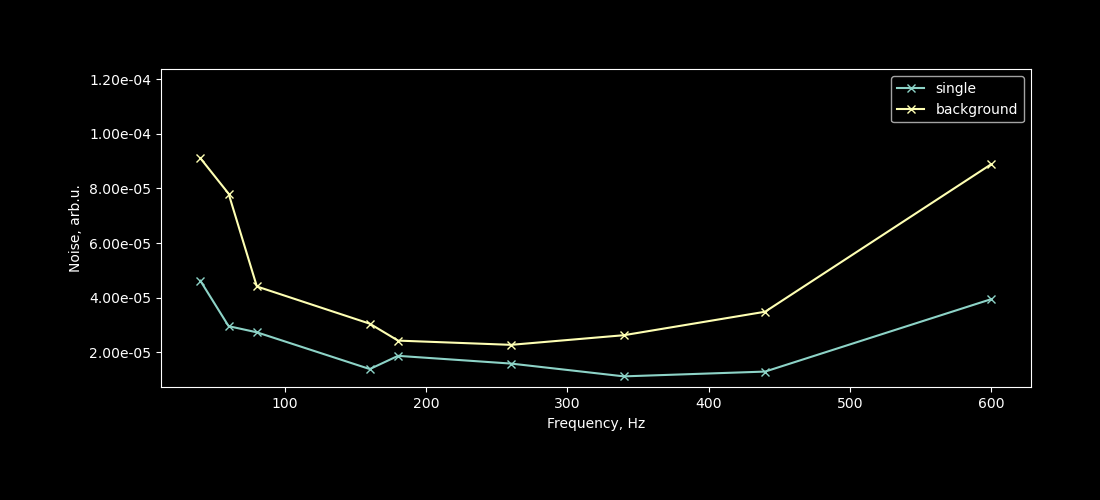

In [113]:
noises300_2 = {
    # 'horizontal': [df_noise_2[300][f][0] for f in df_snr_2.index],
    # 'vertical': [df_noise_2[300][f][1] for f in df_snr_2.index],
    'single': [df_noise_2[300][f][2] for f in df_snr_2.index],
    'background': [df_noise_2[300][f][3] for f in df_snr_2.index]
}

noises600_2 = {
    # 'horizontal': [df_noise_2[600][f][0] for f in df_snr_2.index],
    # 'vertical': [df_noise_2[600][f][1] for f in df_snr_2.index],
    'single': [df_noise_2[600][f][2] for f in df_snr_2.index],
    'background': [df_noise_2[600][f][3] for f in df_snr_2.index]
}

noises900_2 = {
    # 'horizontal': [df_noise_2[900][f][0] for f in df_snr_2.index],
    # 'vertical': [df_noise_2[900][f][1] for f in df_snr_2.index],
    'single': [df_noise_2[900][f][2] for f in df_snr_2.index],
    'background': [df_noise_2[900][f][3] for f in df_snr_2.index]
}

frequencies = df_snr_2.index
x = np.arange(len(frequencies))
width = 0.1
multiplier = 0
spacing = 0.05
top_align = 1.3

plt.close()
plt.figure(figsize=(11, 5), constrained_layout=True)

# ax1 = plt.subplot(311)
# for k, v in noises300_2.items():
#     offset = (width+spacing) * multiplier
#     rects = ax1.bar(x+offset, v, width, label=k)
#     ax1.bar_label(rects, rotation=90, padding=3, fmt="%.2e")
#     multiplier += 1
# ax1.set_xticks(x+width, np.round(list(frequencies), 2))
# ax1.set_xlabel('Frequency, Hz')
# ax1.set_ylabel('Noise, arb.u.')
# old_top = ax1.get_ylim()[1]
# new_top = old_top*top_align
# ax1.set_ylim(top=new_top)
# ax1.legend()
# multiplier = 0

# ax2 = plt.subplot(312)
# for k, v in noises600_2.items():
#     offset = (width+spacing) * multiplier
#     rects = ax2.bar(x+offset, v, width, label=k)
#     ax2.bar_label(rects, rotation=90, padding=3, fmt="%.2e")
#     multiplier += 1
# ax2.set_xticks(x+width, np.round(list(frequencies), 2))
# ax2.set_xlabel('Frequency, Hz')
# ax2.set_ylabel('Noise, arb.u.')
# old_top = ax2.get_ylim()[1]
# new_top = old_top*top_align
# ax2.set_ylim(top=new_top)
# ax2.legend()
multiplier = 0

ax3 = plt.subplot(111)
# for k, v in noises900_2.items():
#     offset = (width+spacing) * multiplier
#     rects = ax3.bar(x+offset, v, width, label=k)
#     ax3.bar_label(rects, rotation=90, padding=3, fmt="%.2e")
#     multiplier += 1
# ax3.set_xticks(x+width, np.round(list(frequencies), 2))

for k, v in noises900_2.items():
    ax3.plot(frequencies, v, "x-", label=k)

ax3.set_xlabel('Frequency, Hz')
ax3.set_ylabel('Noise, arb.u.')
old_top = ax3.get_ylim()[1]
new_top = old_top*top_align
ax3.set_ylim(top=new_top)
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax3.legend()

plt.tight_layout(pad=5)
plt.show()

/tmp/ipykernel_2291/3261528442.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


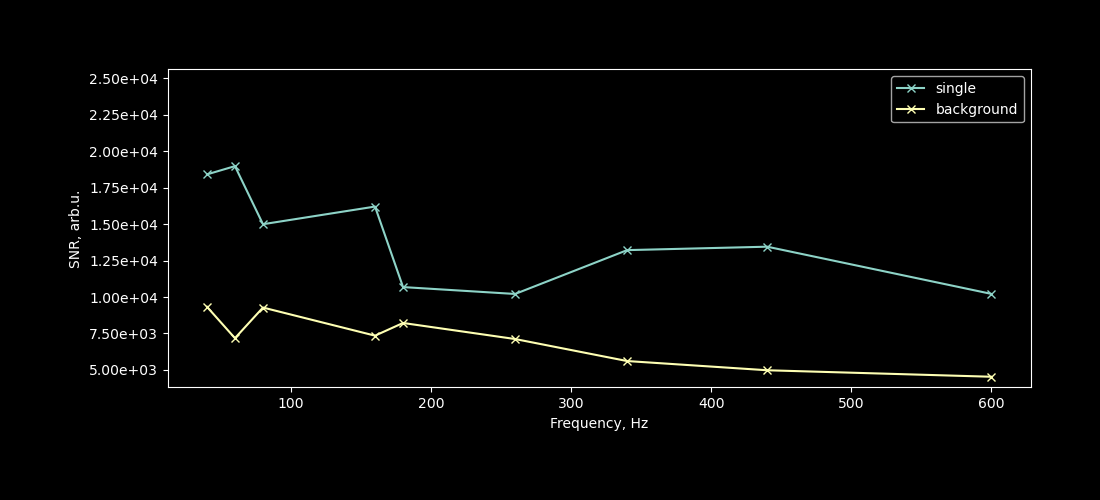

In [114]:
noises300_2 = {
    # 'horizontal': [df_snr_2[300][f][0] for f in df_snr_2.index],
    # 'vertical': [df_snr_2[300][f][1] for f in df_snr_2.index],
    'single': [df_snr_2[300][f][2] for f in df_snr_2.index],
    'background': [df_snr_2[300][f][3] for f in df_snr_2.index]
}

noises600_2 = {
    # 'horizontal': [df_snr_2[600][f][0] for f in df_snr_2.index],
    # 'vertical': [df_snr_2[600][f][1] for f in df_snr_2.index],
    'single': [df_snr_2[600][f][2] for f in df_snr_2.index],
    'background': [df_snr_2[600][f][3] for f in df_snr_2.index]
}

noises900_2 = {
    # 'horizontal': [df_snr_2[900][f][0] for f in df_snr_2.index],
    # 'vertical': [df_snr_2[900][f][1] for f in df_snr_2.index],
    'single': [df_snr_2[900][f][2] for f in df_snr_2.index],
    'background': [df_snr_2[900][f][3] for f in df_snr_2.index]
}




multiplier = 0
plt.close()
plt.figure(figsize=(11, 5), constrained_layout=True)

# ax1 = plt.subplot(311)
# for k, v in noises300_2.items():
#     offset = (width+spacing) * multiplier
#     rects = ax1.bar(x+offset, v, width, label=k)
#     ax1.bar_label(rects, rotation=90, padding=3, fmt="%.2e")
#     multiplier += 1
# ax1.set_xticks(x+width, np.round(list(frequencies), 2))
# ax1.set_xlabel('Frequency, Hz')
# ax1.set_ylabel('SNR, arb.u.')
# old_top = ax1.get_ylim()[1]
# new_top = old_top*top_align
# ax1.set_ylim(top=new_top)
# ax1.legend()
# multiplier = 0

# ax2 = plt.subplot(312)
# for k, v in noises600_2.items():
#     offset = (width+spacing) * multiplier
#     rects = ax2.bar(x+offset, v, width, label=k)
#     ax2.bar_label(rects, rotation=90, padding=3, fmt="%.2e")
#     multiplier += 1
# ax2.set_xticks(x+width, np.round(list(frequencies), 2))
# ax2.set_xlabel('Frequency, Hz')
# ax2.set_ylabel('SNR, arb.u.')
# old_top = ax2.get_ylim()[1]
# new_top = old_top*top_align
# ax2.set_ylim(top=new_top)
# ax2.legend()
multiplier = 0

ax3 = plt.subplot(111)
# for k, v in noises900_2.items():
#     offset = (width+spacing) * multiplier
#     rects = ax3.bar(x+offset, v, width, label=k)
#     ax3.bar_label(rects, rotation=90, padding=3, fmt="%.2e")
#     multiplier += 1
# ax3.set_xticks(x+width, np.round(list(frequencies), 2))

for k, v in noises900_2.items():
    ax3.plot(frequencies, v, "x-", label=k)

ax3.set_xlabel('Frequency, Hz')
ax3.set_ylabel('SNR, arb.u.')
old_top = ax3.get_ylim()[1]
new_top = old_top*top_align
ax3.set_ylim(top=new_top)
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax3.legend()

plt.tight_layout(pad=5)
plt.show()

# Different cantilevers

In [71]:
def plot_magnitudes(path: str,
                    patterns: Dict[
                        int | str | float,
                        Dict[
                            int | str | float,
                            Pattern[str]
                        ]
                    ],
                    p: List[int],
                    freqs: List[int]) -> Dict[Any, Any]:
    """
    Plot the magnitudes for phase uncorrected spectra

    Args:
        path (str): Where are the spectra located
        patterns (Dict[int | str | float, \
            Dict[int | str | float, Pattern[str]]): \
            patterns built with `dir_match_dict()`
        p (List[int]): pressures list
        freqs (List[int]): frequencies list

    Returns:
        (Dict[Any, Any]): Benches (Plots the magnitude spectra of these)

    """

    dictionary = cp.dir_match_dict(path, patterns)
    to_return = {}

    for pressure in p:
        benches = [
            CEPAS_benchmark(path, dictionary, pressure, f) for f in freqs
        ]

        # add averages
        path_avgs = [bench.get_avg() for bench in benches]

        for bench_idx in range(len(benches)):
            spectra = benches[bench_idx].spectra.spectra_list
            spectra.append(path_avgs[bench_idx])

        # plot everything
        plt.close()
        for b_idx in range(len(benches)):
            spectra = benches[b_idx].spectra.spectra_list
            plt.figure()
            labels = ['1', '2', '3', 'avg']
            for s_idx in range(len(spectra)):
                magnitude = np.sqrt(
                    spectra[s_idx]['H2_pnorm']**2 +
                    spectra[s_idx]['H3_pnorm']**2
                )
                plt.plot(
                    spectra[s_idx]['offset1'],
                    magnitude,
                    label=labels[s_idx]
                )
            plt.title(f"$f={freqs[b_idx]}$")
            plt.legend()
            plt.show()

        to_return[pressure] = benches

    return to_return

## R5C10, $l_{gap} = 60\ \mu\text{m}$

49    0.243587
Name: H2_pnorm, dtype: float64
0.7662884520255687


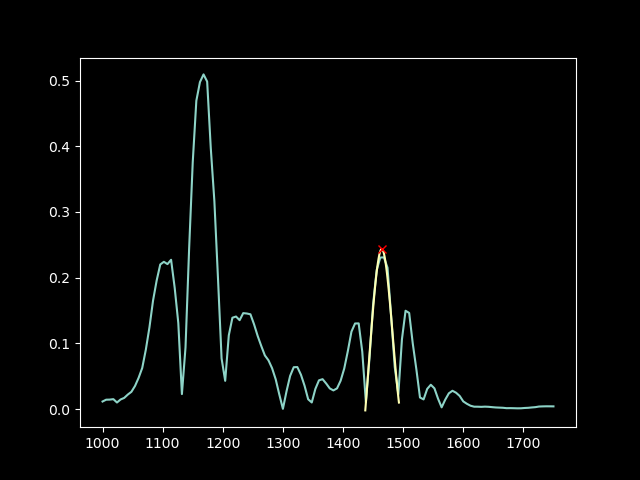

In [72]:
%matplotlib widget
r5c10 = \
    "./datas/misc_tests/cantilevers/2025_09/R5C10_SOI2/"

r5c10_patterns = cp.create_regex_strings([900], [30])
r5c10_dict = cp.dir_match_dict(r5c10, r5c10_patterns)

cb_r5c10 = CEPAS_benchmark(r5c10, r5c10_dict, 900, 30, True)
df = cb_r5c10.spectra.spectra_list[0]
df.head()

magnitude = np.sqrt(df['H2_pnorm']**2 + df['H3_pnorm']**2)
X_cor, Y_cor, angle = cp.phase_correct(df, "H3_pnorm", "H2_pnorm")
cb_r5c10.spectra.spectra_list[0]['H2_pnorm'] = magnitude

wstart = 1437
wend = 1493
best_fit, fit_report, dense_eval, max_row, r5c10_peak = \
    cb_r5c10.get_spline_of_window(0, 5, wstart, wend)

print(r5c10_peak)
print(angle)

xs = df['offset1']
plt.close()
plt.figure()
plt.plot(xs, magnitude)
plt.plot(dense_eval['offset1'], dense_eval['H2_pnorm'])
plt.plot(max_row['offset1'], max_row['H2_pnorm'], 'rx')
plt.show()

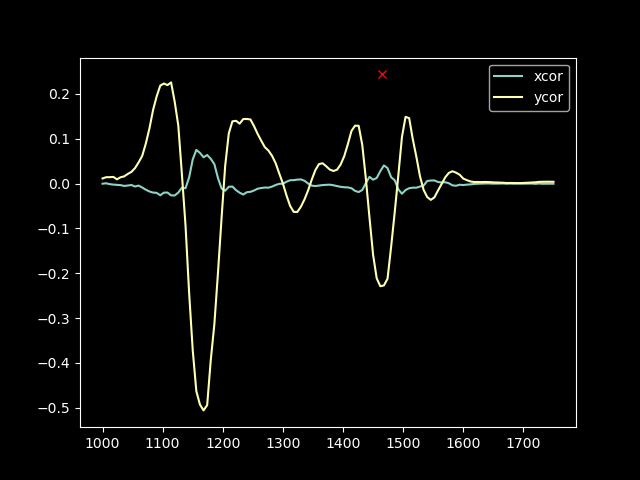

In [73]:
plt.close()
plt.figure()
# plt.plot(np.sin(angle), 'rx')
# plt.plot(np.cos(angle), 'bx')
plt.plot(xs, X_cor, label='xcor')
plt.plot(xs, Y_cor, label="ycor")

plt.plot(max_row['offset1'], max_row['H2_pnorm'], 'rx')
plt.legend()
plt.show()

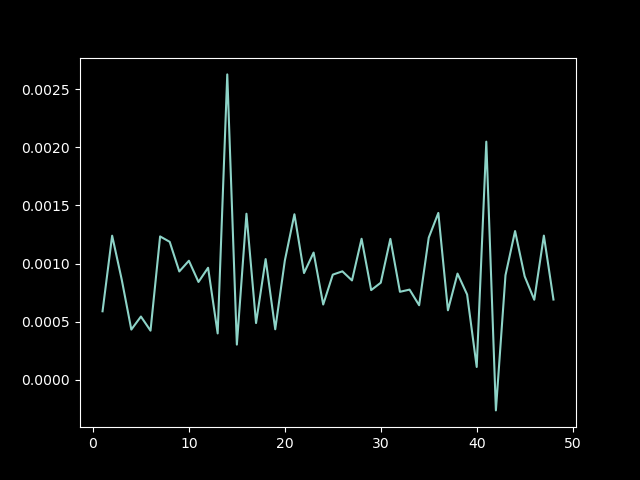

0.00046466567309643944

In [74]:
df_noise = CEPAS_measurement(r5c10+"noise-tests/", "gasx", col_names)
noise_r5c10 = df_noise.spectra_list[0]['H3_pnorm']
plt.close()
plt.figure()
plt.plot(df_noise.spectra_list[0].index, noise_r5c10)
plt.show()

noise_clean = cp.std_range(df_noise.spectra_list[0], 'H2_pnorm', 3)
noise_r5c10.std()

## R6C5(SOI2), $l_{gap} = 30\ \mu\text{m}$

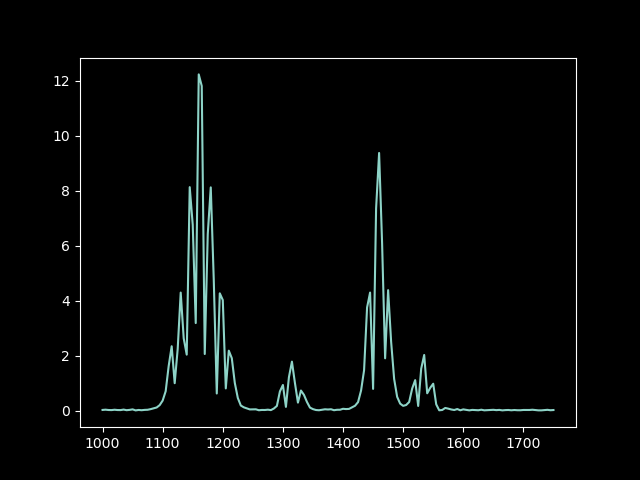

In [75]:
r6c5 = \
    "./datas/misc_tests/cantilevers/2025_09/R6C5_SOI2/"

cp_r6c5 = CEPAS_measurement(r6c5, "gasx", col_names)
df = cp_r6c5.spectra_list[0]
df.head()

magnitude = np.sqrt(df['H2_pnorm']**2 + df['H3_pnorm']**2)
xs = df['offset1']
plt.close()
plt.figure()
plt.plot(xs, magnitude)
plt.show()

In [76]:
cp.dir_match(r6c5, "gasx")

['gasx_300_12_130__msr__15',
 'gasx_300_12_130__msr__16',
 'gasx_300_12_130__msr__17',
 'gasx_300_12_170__msr__18',
 'gasx_300_12_170__msr__19',
 'gasx_300_12_170__msr__20',
 'gasx_300_12_20__msr__0',
 'gasx_300_12_20__msr__1',
 'gasx_300_12_20__msr__2',
 'gasx_300_12_220__msr__21',
 'gasx_300_12_220__msr__22',
 'gasx_300_12_220__msr__23',
 'gasx_300_12_300__msr__24',
 'gasx_300_12_300__msr__25',
 'gasx_300_12_300__msr__26',
 'gasx_300_12_30__msr__3',
 'gasx_300_12_30__msr__4',
 'gasx_300_12_30__msr__5',
 'gasx_300_12_40__msr__6',
 'gasx_300_12_40__msr__7',
 'gasx_300_12_40__msr__8',
 'gasx_300_12_80__msr__10',
 'gasx_300_12_80__msr__11',
 'gasx_300_12_80__msr__9',
 'gasx_300_12_90__msr__12',
 'gasx_300_12_90__msr__13',
 'gasx_300_12_90__msr__14',
 'gasx_600_24_130__msr__15',
 'gasx_600_24_130__msr__16',
 'gasx_600_24_130__msr__17',
 'gasx_600_24_170__msr__18',
 'gasx_600_24_170__msr__19',
 'gasx_600_24_170__msr__20',
 'gasx_600_24_20__msr__0',
 'gasx_600_24_20__msr__1',
 'gasx_600_24_

Bench: 0
	Angle: -11.550483151444345
	Angle: -381.0170223916453
	Angle: -362.4402621645816
Bench: 1
	Angle: -298.3735589447648
	Angle: -401.5403967080284
	Angle: -94.7040880783259
Bench: 2
	Angle: -174.3188510267894
	Angle: -8.54461002143437
	Angle: 10.959886311759064
Bench: 3
	Angle: -219.0700436801094
	Angle: -163.81740193166428
	Angle: -131.3182292491245
Bench: 4
	Angle: -329.46913126005046
	Angle: -294.39346666040035
	Angle: -476.983047190544
Bench: 5
	Angle: -144.0000208401999
	Angle: -140.97534961026727
	Angle: -314.6661103258034
Bench: 6
	Angle: -77.20622954314196
	Angle: 110.71559701311581
	Angle: -59.98016577800539
Bench: 7
	Angle: -308.99235801285585
	Angle: -273.3435076856791
	Angle: -283.37126860244354
Bench: 8
	Angle: -222.43627703627803
	Angle: -492.2635576695705
	Angle: -244.51849729233672


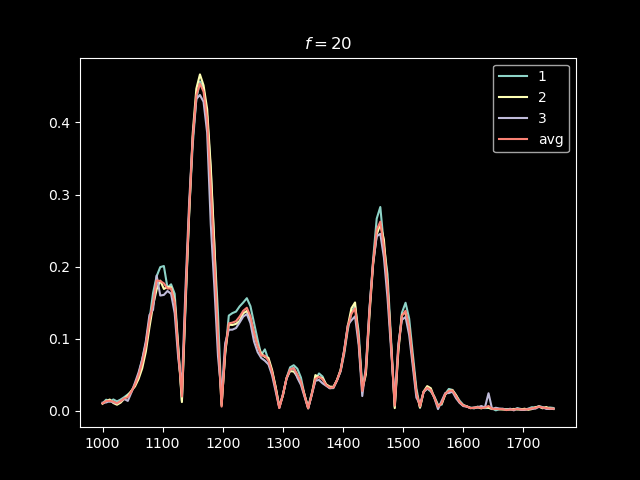

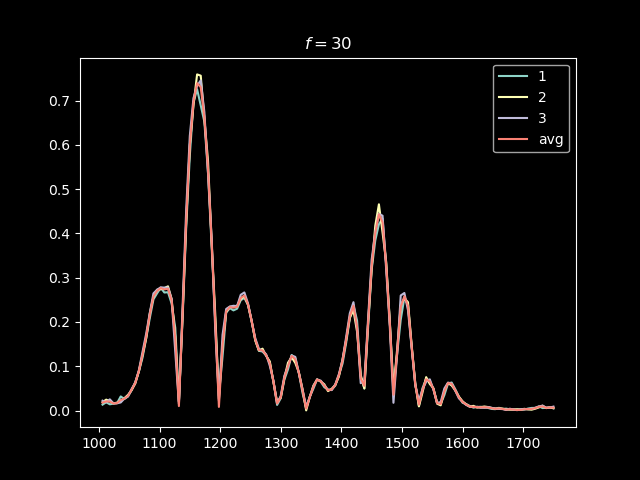

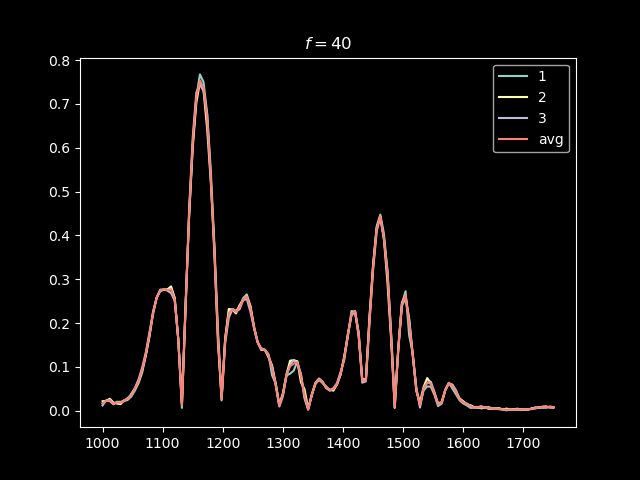

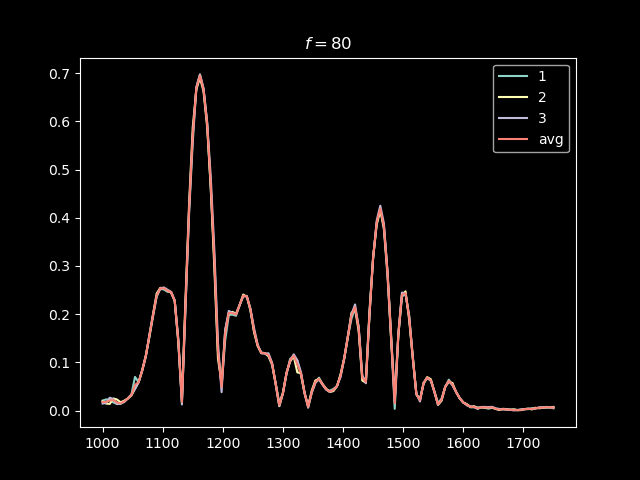

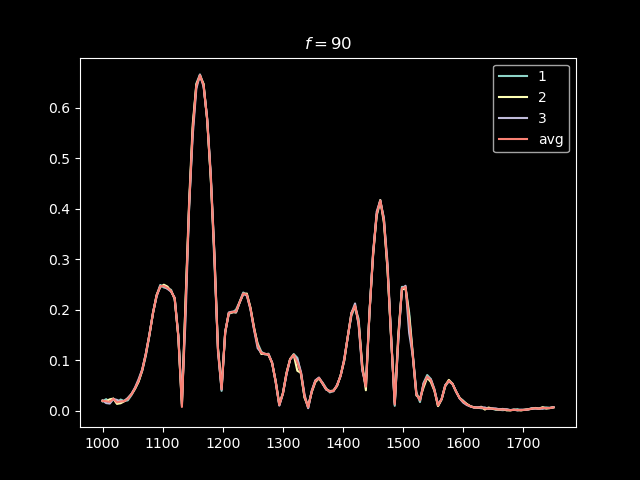

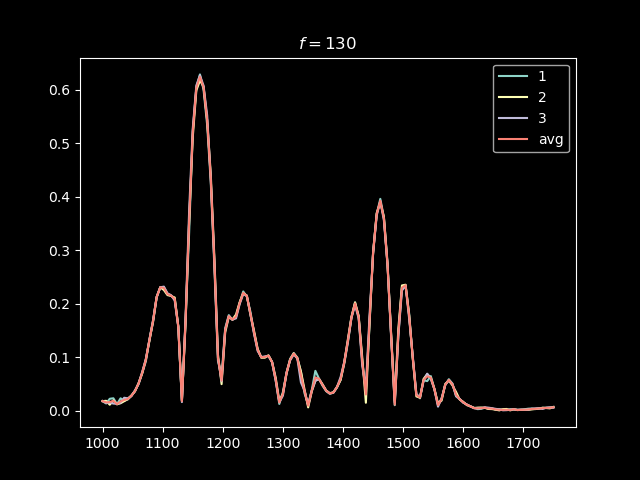

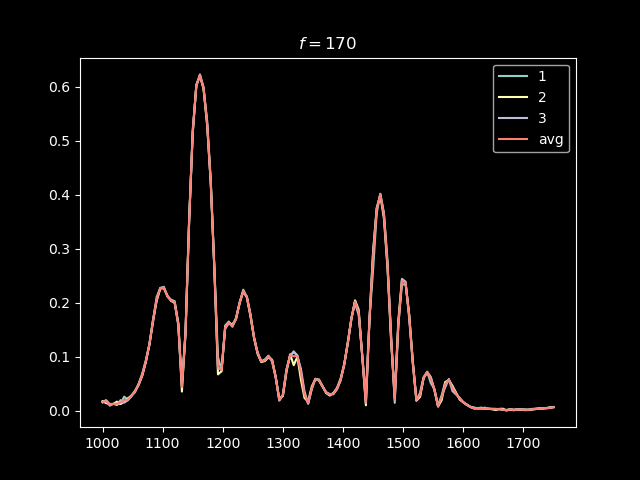

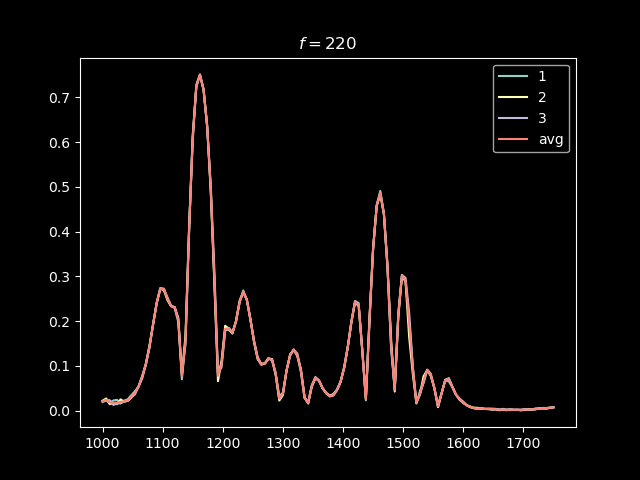

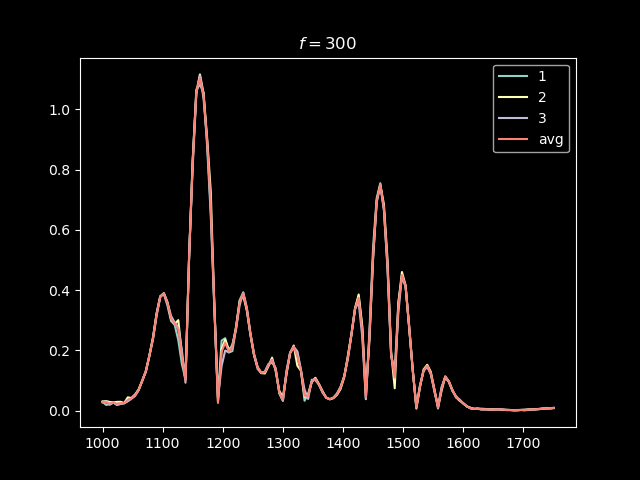

In [77]:
pressure_list_900 = [900]
r6c5_patterns = cp.create_regex_strings(pressure_list_900, freq_list_2)
r6c5_dict = cp.dir_match_dict(r6c5, r6c5_patterns)

r6c5_benches = [CEPAS_benchmark(r6c5, r6c5_dict, 900, f) for f in freq_list_2]

# Phase correct
for bench_idx in range(len(r6c5_benches)):
    spectra = r6c5_benches[bench_idx].spectra.spectra_list
    print(f"Bench: {bench_idx}")
    for s in spectra:
        X_cor, Y_cor, angle = cp.phase_correct(s, "H3_pnorm", "H2_pnorm")
        print(f"\tAngle: {np.rad2deg(angle)}")
        s["H2_pnorm_pc"] = X_cor
        s["H3_pnorm_pc"] = Y_cor

# Add averages
r6c5_avgs = [bench.get_avg() for bench in r6c5_benches]

for bench_idx in range(len(r6c5_benches)):
    spectra = r6c5_benches[bench_idx].spectra.spectra_list
    spectra.append(r6c5_avgs[bench_idx])

# plot everything
plt.close()
for b_idx in range(len(r6c5_benches)):
    spectra = r6c5_benches[b_idx].spectra.spectra_list
    plt.figure()
    labels = ['1', '2', '3', 'avg']
    for s_idx in range(len(spectra)):
        magnitude = np.sqrt(spectra[s_idx]['H2_pnorm']**2 \
                            + spectra[s_idx]['H3_pnorm']**2)
        plt.plot(spectra[s_idx]['offset1'],
                 magnitude,
                 label=labels[s_idx])
        # plt.plot(spectra[s_idx]["offset1"],
        #          spectra[s_idx]["H2_pnorm_pc"],
        #          label = labels[s_idx])
        # plt.plot(spectra[s_idx]["offset1"],
        #          spectra[s_idx]["H3_pnorm_pc"],
        #          label = labels[s_idx])
    plt.title(f"$f={freq_list_2[b_idx]}$")
    plt.legend()
    plt.show()


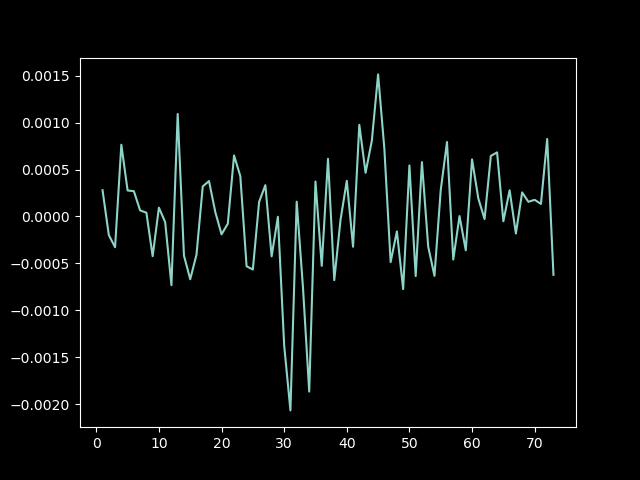

0.0006227867390320717

In [78]:
df_noise = CEPAS_measurement(r6c5+"noise-tests/", "single", col_names)
noise_r6c5 = df_noise.spectra_list[0]['H3_pnorm']
plt.close()
plt.figure()
plt.plot(df_noise.spectra_list[0].index, noise_r6c5)
plt.show()

noise_clean = cp.std_range(df_noise.spectra_list[0], 'H2_pnorm', 3)
noise_r6c5.std()

## R5C10 (SOI 1), $l_{gap} = 60\ \mu\text{m}$

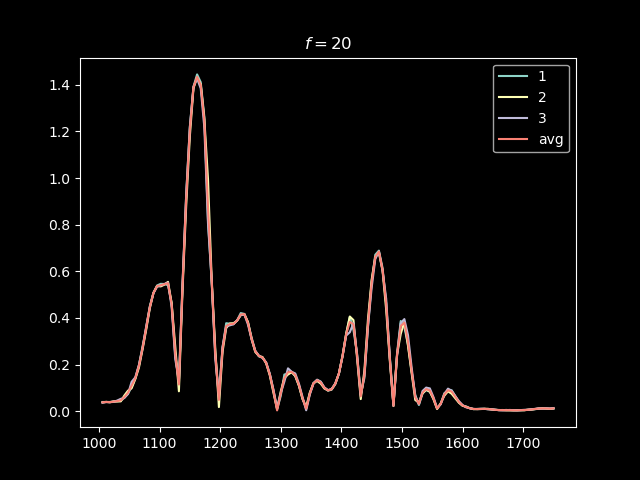

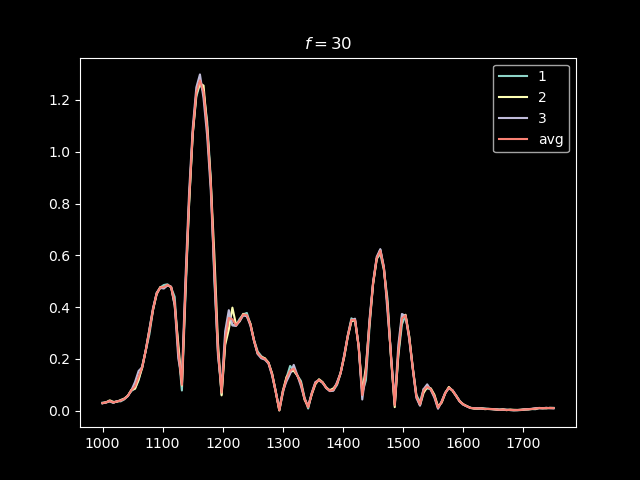

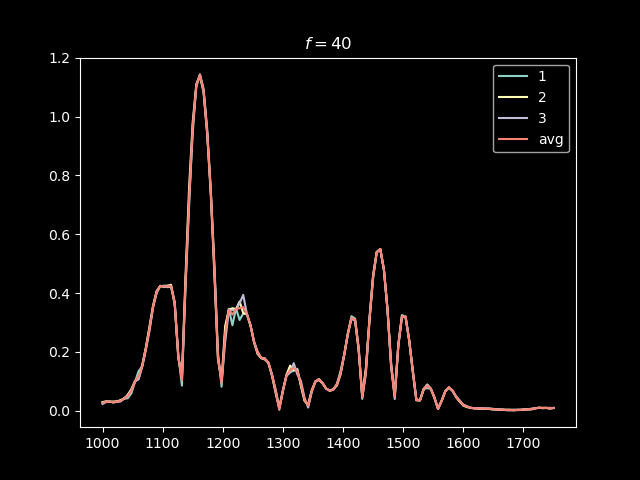

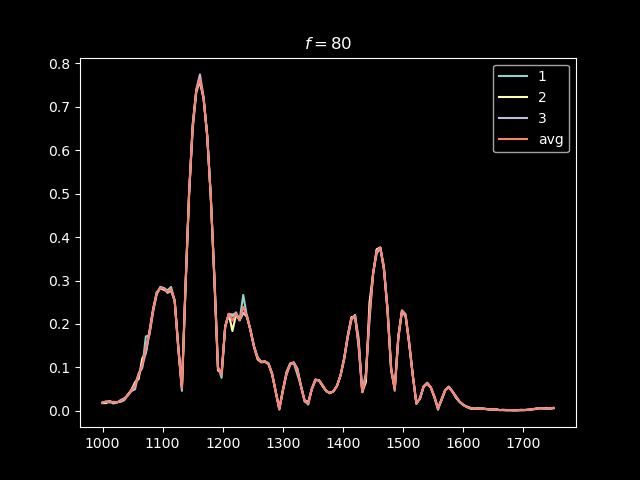

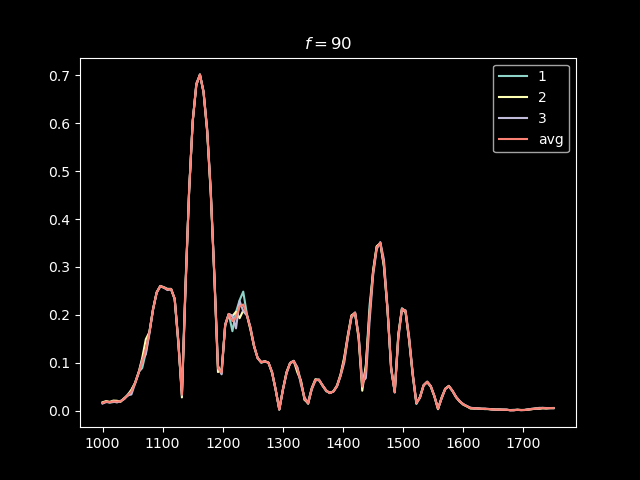

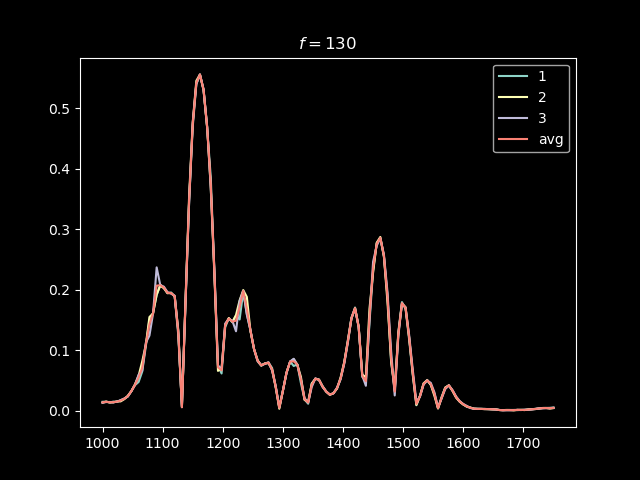

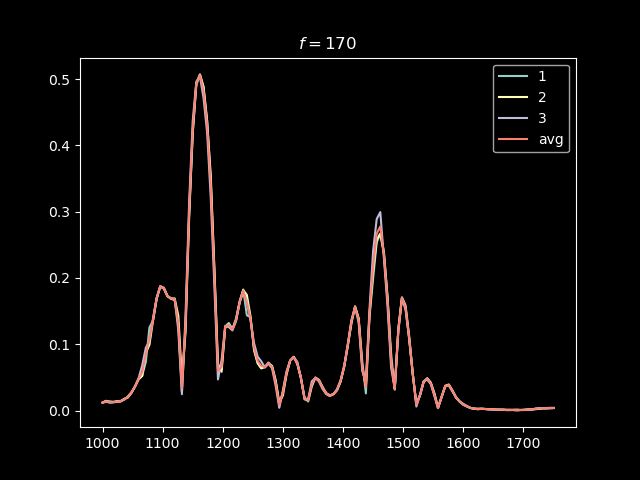

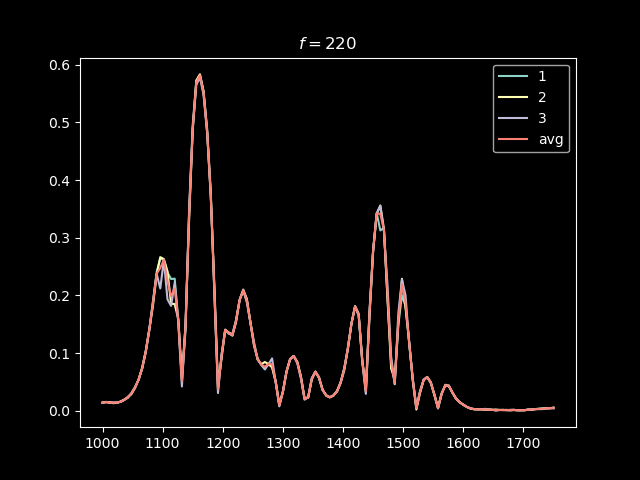

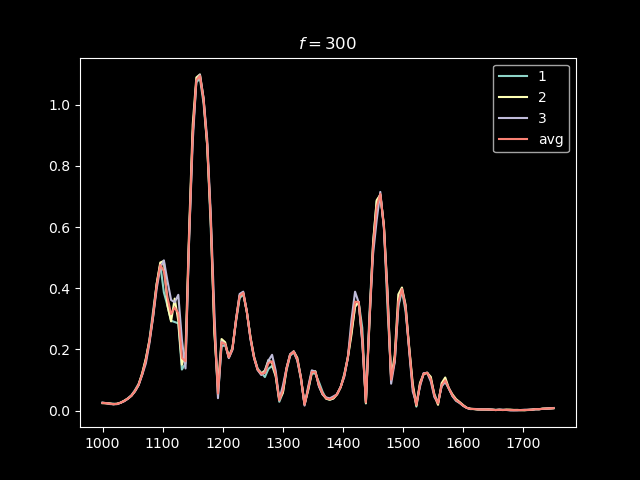

In [79]:
r5c10_1 = \
    "./datas/misc_tests/cantilevers/2025_09/R5C10_SOI1/"

r5c10_1_patterns = r6c5_patterns

r5c10_1_all = plot_magnitudes(r5c10_1, r5c10_1_patterns, [900], freq_list_2)

0.0003323266713792389
0.0012157568574608188
0.0006057358743813018


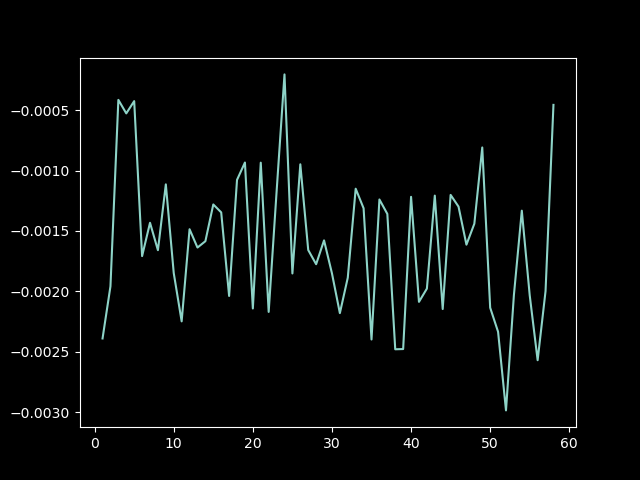

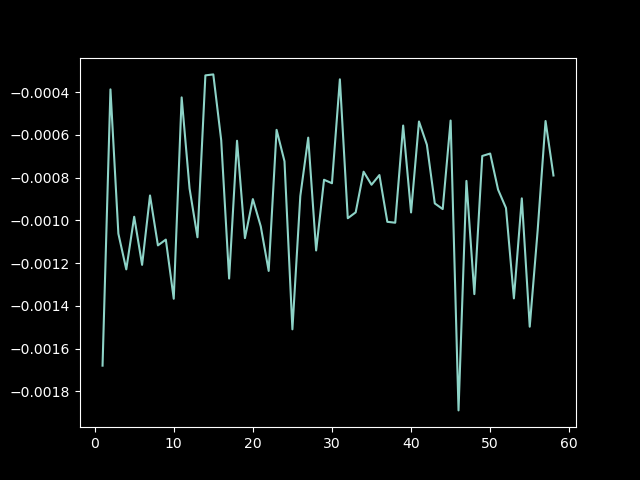

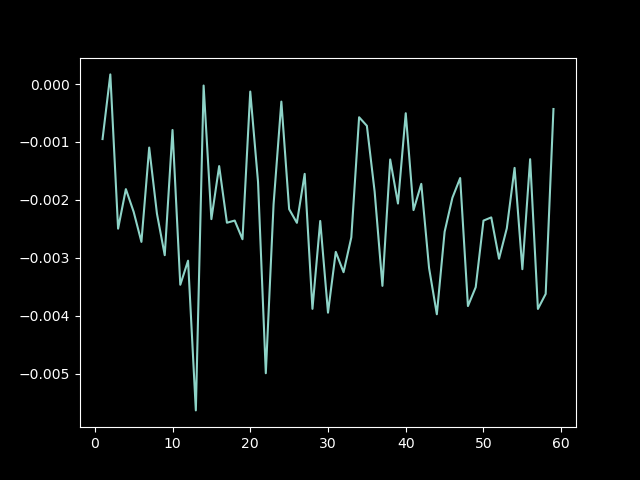

In [80]:
r5c10_1_noise = r5c10_1 + "noise-tests/"
special_freqs = [20, 170, 300]
r5c10_1_noises = CEPAS_measurement(r5c10_1_noise, "single", col_names)
plt.close()
for n in r5c10_1_noises.spectra_list:
    plt.figure()
    plt.plot(n.index, n["H2_pnorm"])
    noise = n['H2_pnorm'].std()
    print(noise)
plt.show()

## Cantilever compare scatter

### all figs together

'magnitude_pnorm'
, but now added the missing column
DEBUG: At p=300                         and f=20 signal is 
---->18    1.010176
Name: magnitude_pnorm, dtype: float64<----

noise from single measurements: 3.5342997290930734e-05
'magnitude_pnorm'
, but now added the missing column
DEBUG: At p=300                         and f=30 signal is 
---->15    0.68208
Name: magnitude_pnorm, dtype: float64<----

noise from single measurements: 2.140889251885642e-05
'magnitude_pnorm'
, but now added the missing column
DEBUG: At p=300                         and f=40 signal is 
---->81    0.622308
Name: magnitude_pnorm, dtype: float64<----

noise from single measurements: 1.769815171923273e-05
'magnitude_pnorm'
, but now added the missing column
DEBUG: At p=300                         and f=80 signal is 
---->77    0.344484
Name: magnitude_pnorm, dtype: float64<----

noise from single measurements: 1.4561642634665629e-05
'magnitude_pnorm'
, but now added the missing column
DEBUG: At p=300       

/tmp/ipykernel_2291/945689554.py:346: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


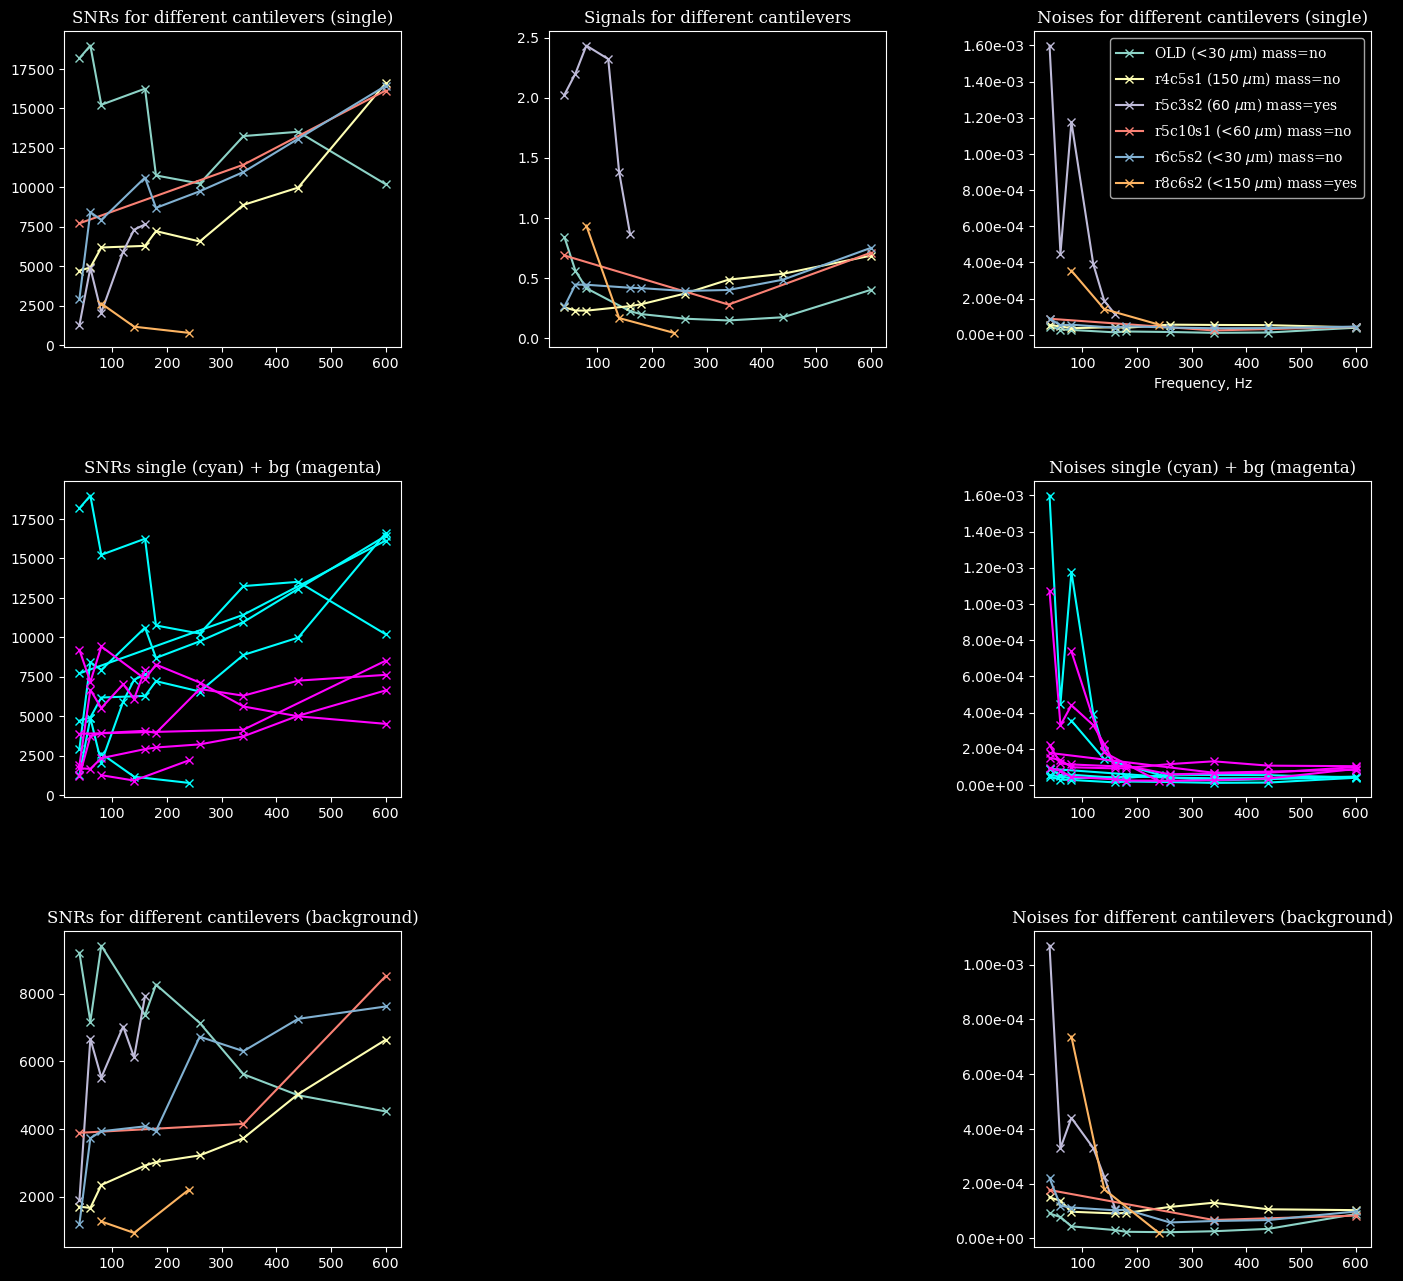

In [115]:
%matplotlib inline
# OLD OG cantilever
old_noise_start = 1625
old_noise_end = 1749
old_peak_start = 1449
old_peak_end = 1471

old_path = "./datas/benchmark/2/measurements/"
old_path_noise = "./datas/benchmark/2/noise/"
old_freqs = freq_list_2
old_press = pressure_list
old_patterns = cp.create_regex_strings(old_press, old_freqs)
old_test_bench_files = cp.dir_match_dict(old_path, old_patterns)


old_final = CEPAS_SNR_bench(old_test_bench_files,
                                bench_path=old_path,
                                noise_path=old_path_noise,
                                file_sig="gasx")

old_all = old_final.get_mag_snrs(old_peak_start,
                                     old_peak_end,
                                     n_knots=4)

old_signals = old_all[2]
old_noises = old_all[1]
old_snrs = old_all[0]

# R4C5S1 ($150\ \mu$m) mass=no
r4c5s1_noise_start = 1625
r4c5s1_noise_end = 1749
r4c5s1_peak_start = 1440
r4c5s1_peak_end = 1480

r4c5s1_path = "./datas/misc_tests/cantilevers/2025_09/R4C5_SOI1/"
r4c5s1_path_noise = r4c5s1_path + "noise-tests/"
r4c5s1_freqs = freq_list_2
r4c5s1_press = [900]
r4c5s1_patterns = cp.create_regex_strings(r4c5s1_press, r4c5s1_freqs)
r4c5s1_test_bench_files = cp.dir_match_dict(r4c5s1_path, r4c5s1_patterns)


r4c5s1_final = CEPAS_SNR_bench(r4c5s1_test_bench_files,
                                bench_path=r4c5s1_path,
                                noise_path=r4c5s1_path_noise,
                                file_sig="single")

r4c5s1_all = r4c5s1_final.get_mag_snrs(r4c5s1_peak_start,
                                     r4c5s1_peak_end,
                                     n_knots=4)

r4c5s1_signals = r4c5s1_all[2]
r4c5s1_noises = r4c5s1_all[1]
r4c5s1_snrs = r4c5s1_all[0]

# R5C3S2 ($60\ \mu$m) mass=yes
r5c3s2_noise_start = 1625
r5c3s2_noise_end = 1749
r5c3s2_peak_start = 1435
r5c3s2_peak_end = 1471

r5c3s2_path = "./datas/misc_tests/cantilevers/2025_09/R5C3_SOI2/"
r5c3s2_path_noise = r5c3s2_path + "noise-tests/"
r5c3s2_freqs = [60, 70, 80]
r5c3s2_press = [900]
r5c3s2_patterns = cp.create_regex_strings(r5c3s2_press, r5c3s2_freqs)
r5c3s2_test_bench_files = cp.dir_match_dict(r5c3s2_path, r5c3s2_patterns)


r5c3s2_final = CEPAS_SNR_bench(r5c3s2_test_bench_files,
                                bench_path=r5c3s2_path,
                                noise_path=r5c3s2_path_noise,
                                file_sig="single")

r5c3s2_all = r5c3s2_final.get_mag_snrs(r5c3s2_peak_start,
                                     r5c3s2_peak_end,
                                     n_knots=4)

r5c3s2_signals = r5c3s2_all[2]
r5c3s2_noises = r5c3s2_all[1]
r5c3s2_snrs = r5c3s2_all[0]

# R5C3S2 ($60\ \mu$m) mass=yes # Take two (20,30,40)
r5c3s2_2_noise_start = 1625
r5c3s2_2_noise_end = 1749
r5c3s2_2_peak_start = 1435
r5c3s2_2_peak_end = 1471

r5c3s2_2_path = "./datas/misc_tests/cantilevers/2025_09/R5C3_SOI2/"
r5c3s2_2_path_noise = r5c3s2_path + "noise-tests/"
r5c3s2_2_freqs = [20, 30, 40]
r5c3s2_2_press = [900]
r5c3s2_2_patterns = cp.create_regex_strings(r5c3s2_2_press, r5c3s2_2_freqs)
r5c3s2_2_test_bench_files = cp.dir_match_dict(r5c3s2_2_path, r5c3s2_2_patterns)


r5c3s2_2_final = CEPAS_SNR_bench(r5c3s2_2_test_bench_files,
                                bench_path=r5c3s2_2_path,
                                noise_path=r5c3s2_2_path_noise,
                                noise_number=2,
                                file_sig="single")

r5c3s2_2_all = r5c3s2_2_final.get_mag_snrs(r5c3s2_2_peak_start,
                                     r5c3s2_2_peak_end,
                                     n_knots=4)

r5c3s2_2_signals = r5c3s2_2_all[2]
r5c3s2_2_noises = r5c3s2_2_all[1]
r5c3s2_2_snrs = r5c3s2_2_all[0]

# R5C10S1 ($60\ \mu$m) mass=no
r5c10s1_noise_start = 1625
r5c10s1_noise_end = 1749
r5c10s1_peak_start = 1449
r5c10s1_peak_end = 1471

r5c10s1_path = "./datas/misc_tests/cantilevers/2025_09/R5C10_SOI1/"
r5c10s1_path_noise = r5c10s1_path + "noise-tests/"
r5c10s1_freqs = [20, 170, 300]
r5c10s1_press = [900]
r5c10s1_patterns = cp.create_regex_strings(r5c10s1_press, r5c10s1_freqs)
r5c10s1_test_bench_files = cp.dir_match_dict(r5c10s1_path, r5c10s1_patterns)


r5c10s1_final = CEPAS_SNR_bench(r5c10s1_test_bench_files,
                                bench_path=r5c10s1_path,
                                noise_path=r5c10s1_path_noise,
                                file_sig="single")

r5c10s1_all = r5c10s1_final.get_mag_snrs(r5c10s1_peak_start,
                                     r5c10s1_peak_end,
                                     n_knots=4)

r5c10s1_signals = r5c10s1_all[2]
r5c10s1_noises = r5c10s1_all[1]
r5c10s1_snrs = r5c10s1_all[0]

# R5C10S2 ($60\ \mu$m) mass=no
# Not good cantilever

# R6C5S2 ($30\ \mu$m) mass=no
r6c5s2_noise_start = 1625
r6c5s2_noise_end = 1749
r6c5s2_peak_start = 1449
r6c5s2_peak_end = 1471

r6c5s2_path = "./datas/misc_tests/cantilevers/2025_09/R6C5_SOI2/"
r6c5s2_path_noise = r6c5s2_path + "noise-tests/"
r6c5s2_freqs = freq_list_2
r6c5s2_press = [900]
r6c5s2_patterns = cp.create_regex_strings(r6c5s2_press, r6c5s2_freqs)
r6c5s2_test_bench_files = cp.dir_match_dict(r6c5s2_path, r6c5s2_patterns)


r6c5s2_final = CEPAS_SNR_bench(r6c5s2_test_bench_files,
                                bench_path=r6c5s2_path,
                                noise_path=r6c5s2_path_noise,
                                file_sig="single")

r6c5s2_all = r6c5s2_final.get_mag_snrs(r6c5s2_peak_start,
                                     r6c5s2_peak_end,
                                     n_knots=4)

r6c5s2_signals = r6c5s2_all[2]
r6c5s2_noises = r6c5s2_all[1]
r6c5s2_snrs = r6c5s2_all[0]

# R8C6S2 ($150\ \mu$m) mass=yes
r8c6s2_noise_start = 1625
r8c6s2_noise_end = 1749
r8c6s2_peak_start = 1435
r8c6s2_peak_end = 1471

r8c6s2_path = "./datas/misc_tests/cantilevers/2025_09/R8C6_SOI2/"
r8c6s2_path_noise = r8c6s2_path + "noise-tests/"
r8c6s2_freqs = [40, 70, 120]
r8c6s2_press = [900]
r8c6s2_patterns = cp.create_regex_strings(r8c6s2_press, r8c6s2_freqs)
r8c6s2_test_bench_files = cp.dir_match_dict(r8c6s2_path, r8c6s2_patterns)


r8c6s2_final = CEPAS_SNR_bench(r8c6s2_test_bench_files,
                                bench_path=r8c6s2_path,
                                noise_path=r8c6s2_path_noise,
                                file_sig="single")

r8c6s2_all = r8c6s2_final.get_mag_snrs(r8c6s2_peak_start,
                                     r8c6s2_peak_end,
                                     n_knots=4)

r8c6s2_signals = r8c6s2_all[2]
r8c6s2_noises = r8c6s2_all[1]
r8c6s2_snrs = r8c6s2_all[0]


old_freqs = [f*2 for f in old_freqs]
r4c5s1_freqs = [f*2 for f in r4c5s1_freqs]
r5c3s2_freqs = r5c3s2_2_freqs + r5c3s2_freqs
r5c3s2_freqs = [f*2 for f in r5c3s2_freqs]
r5c10s1_freqs = [f*2 for f in r5c10s1_freqs]
r6c5s2_freqs = [f*2 for f in r6c5s2_freqs]
r8c6s2_freqs = [f*2 for f in r8c6s2_freqs]
r5c3s2_2_freqs = [f*2 for f in r5c3s2_2_freqs]


r5c3s2_noises = pd.concat([r5c3s2_2_noises, r5c3s2_noises])
r5c3s2_signals = pd.concat([r5c3s2_2_signals, r5c3s2_signals])
r5c3s2_snrs = pd.concat([r5c3s2_2_snrs, r5c3s2_snrs])

print(r5c3s2_freqs)
print(r5c3s2_noises)

plt.close()

plt.figure(figsize=(15, 14), constrained_layout=True)
font = font_manager.FontProperties(family='serif')

# snrs (single)
ax2 = plt.subplot(331)
ax2.set_title("SNRs for different cantilevers (single)", fontname="serif")

ax2.plot(old_freqs, [old_snrs[900][idx][0] for idx in old_snrs[900].index], "x-", label="OLD (<$30\\ \\mu$m) mass=no")
ax2.plot(r4c5s1_freqs, [r4c5s1_snrs[900][idx][0] for idx in r4c5s1_snrs[900].index], "x-", label="r4c5s1 (<$30\\ \\mu$m) mass=no")
ax2.plot(r5c3s2_freqs, [r5c3s2_snrs[900][idx][0] for idx in r5c3s2_snrs[900].index], "x-", label="r5c3s2 (<$30\\ \\mu$m) mass=no")
ax2.plot(r5c10s1_freqs, [r5c10s1_snrs[900][idx][0] for idx in r5c10s1_snrs[900].index], "x-", label="r5c10s1 (<$30\\ \\mu$m) mass=no")
ax2.plot(r6c5s2_freqs, [r6c5s2_snrs[900][idx][0] for idx in r6c5s2_snrs[900].index], "x-", label="r6c5s2 (<$30\\ \\mu$m) mass=no")
ax2.plot(r8c6s2_freqs, [r8c6s2_snrs[900][idx][0] for idx in r8c6s2_snrs[900].index], "x-", label="r8c6s2 (<$30\\ \\mu$m) mass=no")

# signals
ax0 = plt.subplot(332)
ax0.set_title("Signals for different cantilevers", fontname="serif")

ax0.plot(old_freqs, [old_signals[900][idx][0] for idx in old_signals[900].index], "x-", label="OLD (<$30\\ \\mu$m) mass=no")
ax0.plot(r4c5s1_freqs, [r4c5s1_signals[900][idx][0] for idx in r4c5s1_signals[900].index], "x-", label="r4c5s1 (<$30\\ \\mu$m) mass=no")
ax0.plot(r5c3s2_freqs, [r5c3s2_signals[900][idx][0] for idx in r5c3s2_signals[900].index], "x-", label="r5c3s2 (<$30\\ \\mu$m) mass=no")
ax0.plot(r5c10s1_freqs, [r5c10s1_signals[900][idx][0] for idx in r5c10s1_signals[900].index], "x-", label="r5c10s1 (<$30\\ \\mu$m) mass=no")
ax0.plot(r6c5s2_freqs, [r6c5s2_signals[900][idx][0] for idx in r6c5s2_signals[900].index], "x-", label="r6c5s2 (<$30\\ \\mu$m) mass=no")
ax0.plot(r8c6s2_freqs, [r8c6s2_signals[900][idx][0] for idx in r8c6s2_signals[900].index], "x-", label="r8c6s2 (<$30\\ \\mu$m) mass=no")

# noises (single)
ax1 = plt.subplot(333)
ax1.set_title("Noises for different cantilevers (single)", fontname="serif")
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

ax1.plot(old_freqs, [old_noises[900][idx][0] for idx in old_noises[900].index], "x-", label="OLD (<$30\\ \\mu$m) mass=no")
ax1.plot(r4c5s1_freqs, [r4c5s1_noises[900][idx][0] for idx in r4c5s1_noises[900].index], "x-", label="r4c5s1 ($150\\ \\mu$m) mass=no")
ax1.plot(r5c3s2_freqs, [r5c3s2_noises[900][idx][0] for idx in r5c3s2_noises[900].index], "x-", label="r5c3s2 ($60\\ \\mu$m) mass=yes")
ax1.plot(r5c10s1_freqs, [r5c10s1_noises[900][idx][0] for idx in r5c10s1_noises[900].index], "x-", label="r5c10s1 (<$60\\ \\mu$m) mass=no")
ax1.plot(r6c5s2_freqs, [r6c5s2_noises[900][idx][0] for idx in r6c5s2_noises[900].index], "x-", label="r6c5s2 (<$30\\ \\mu$m) mass=no")
ax1.plot(r8c6s2_freqs, [r8c6s2_noises[900][idx][0] for idx in r8c6s2_noises[900].index], "x-", label="r8c6s2 (<$150\\ \\mu$m) mass=yes")

ax1.legend(prop=font)
ax1.set_xlabel("Frequency, Hz")

# snrs (background)
ax3 = plt.subplot(337)
ax3.set_title("SNRs for different cantilevers (background)", fontname="serif")

ax3.plot(old_freqs, [old_snrs[900][idx][1] for idx in old_snrs[900].index], "x-", label="OLD (<$30\\ \\mu$m) mass=no")
ax3.plot(r4c5s1_freqs, [r4c5s1_snrs[900][idx][1] for idx in r4c5s1_snrs[900].index], "x-", label="r4c5s1 (<$30\\ \\mu$m) mass=no")
ax3.plot(r5c3s2_freqs, [r5c3s2_snrs[900][idx][1] for idx in r5c3s2_snrs[900].index], "x-", label="r5c3s2 (<$30\\ \\mu$m) mass=no")
ax3.plot(r5c10s1_freqs, [r5c10s1_snrs[900][idx][1] for idx in r5c10s1_snrs[900].index], "x-", label="r5c10s1 (<$30\\ \\mu$m) mass=no")
ax3.plot(r6c5s2_freqs, [r6c5s2_snrs[900][idx][1] for idx in r6c5s2_snrs[900].index], "x-", label="r6c5s2 (<$30\\ \\mu$m) mass=no")
ax3.plot(r8c6s2_freqs, [r8c6s2_snrs[900][idx][1] for idx in r8c6s2_snrs[900].index], "x-", label="r8c6s2 (<$30\\ \\mu$m) mass=no")

# noises (background)
ax4 = plt.subplot(339)
ax4.set_title("Noises for different cantilevers (background)", fontname="serif")
ax4.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

ax4.plot(old_freqs, [old_noises[900][idx][1] for idx in old_noises[900].index], "x-", label="OLD (<$30\\ \\mu$m) mass=no")
ax4.plot(r4c5s1_freqs, [r4c5s1_noises[900][idx][1] for idx in r4c5s1_noises[900].index], "x-", label="r4c5s1 ($150\\ \\mu$m) mass=no")
ax4.plot(r5c3s2_freqs,[r5c3s2_noises[900][idx][1] for idx in r5c3s2_noises[900].index], "x-", label="r5c3s2 ($60\\ \\mu$m) mass=yes")
ax4.plot(r5c10s1_freqs, [r5c10s1_noises[900][idx][1] for idx in r5c10s1_noises[900].index], "x-", label="r5c10s1 (<$60\\ \\mu$m) mass=no")
ax4.plot(r6c5s2_freqs, [r6c5s2_noises[900][idx][1] for idx in r6c5s2_noises[900].index], "x-", label="r6c5s2 (<$30\\ \\mu$m) mass=no")
ax4.plot(r8c6s2_freqs, [r8c6s2_noises[900][idx][1] for idx in r8c6s2_noises[900].index], "x-", label="r8c6s2 (<$150\\ \\mu$m) mass=yes")

# SNRs single+bg
ax5 = plt.subplot(334)
ax5.set_title("SNRs single (cyan) + bg (magenta)", fontname="serif")

ax5.plot(old_freqs,
         [old_snrs[900][idx][0] for idx in old_snrs[900].index], "x-", color="cyan", label="OLD (<$30\\ \\mu$m) mass=no")
ax5.plot(r4c5s1_freqs,
         [r4c5s1_snrs[900][idx][0] for idx in r4c5s1_snrs[900].index], "x-", color="cyan", label="r4c5s1 (<$30\\ \\mu$m) mass=no")
ax5.plot(r5c3s2_freqs,
         [r5c3s2_snrs[900][idx][0] for idx in r5c3s2_snrs[900].index], "x-", color="cyan", label="r5c3s2 (<$30\\ \\mu$m) mass=no")
ax5.plot(r5c10s1_freqs,
         [r5c10s1_snrs[900][idx][0] for idx in r5c10s1_snrs[900].index], "x-", color="cyan", label="r5c10s1 (<$30\\ \\mu$m) mass=no")
ax5.plot(r6c5s2_freqs,
         [r6c5s2_snrs[900][idx][0] for idx in r6c5s2_snrs[900].index], "x-", color="cyan", label="r6c5s2 (<$30\\ \\mu$m) mass=no")
ax5.plot(r8c6s2_freqs,
         [r8c6s2_snrs[900][idx][0] for idx in r8c6s2_snrs[900].index], "x-", color="cyan", label="r8c6s2 (<$30\\ \\mu$m) mass=no")

ax5.plot(
    old_freqs, [old_snrs[900][idx][1] for idx in old_snrs[900].index], "x-", color="magenta", label="OLD (<$30\\ \\mu$m) mass=no")
ax5.plot(
    r4c5s1_freqs, [r4c5s1_snrs[900][idx][1] for idx in r4c5s1_snrs[900].index], "x-", color="magenta", label="r4c5s1 (<$30\\ \\mu$m) mass=no")
ax5.plot(
    r5c3s2_freqs, [r5c3s2_snrs[900][idx][1] for idx in r5c3s2_snrs[900].index], "x-", color="magenta", label="r5c3s2 (<$30\\ \\mu$m) mass=no")
ax5.plot(
    r5c10s1_freqs, [r5c10s1_snrs[900][idx][1] for idx in r5c10s1_snrs[900].index], "x-", color="magenta", label="r5c10s1 (<$30\\ \\mu$m) mass=no")
ax5.plot(
    r6c5s2_freqs, [r6c5s2_snrs[900][idx][1] for idx in r6c5s2_snrs[900].index], "x-", color="magenta", label="r6c5s2 (<$30\\ \\mu$m) mass=no")
ax5.plot(
    r8c6s2_freqs, [r8c6s2_snrs[900][idx][1] for idx in r8c6s2_snrs[900].index], "x-", color="magenta", label="r8c6s2 (<$30\\ \\mu$m) mass=no")

# Noises single+bg
ax6 = plt.subplot(336)
ax6.set_title("Noises single (cyan) + bg (magenta)", fontname="serif")
ax6.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

ax6.plot(
    old_freqs,
    [old_noises[900][idx][0] for idx in old_noises[900].index], "x-", color="cyan", label="OLD (<$30\\ \\mu$m) mass=no")
ax6.plot(
    r4c5s1_freqs,
    [r4c5s1_noises[900][idx][0] for idx in r4c5s1_noises[900].index], "x-", color="cyan", label="r4c5s1 ($150\\ \\mu$m) mass=no")
ax6.plot(
    r5c3s2_freqs,
    [r5c3s2_noises[900][idx][0] for idx in r5c3s2_noises[900].index], "x-", color="cyan", label="r5c3s2 ($60\\ \\mu$m) mass=yes")
ax6.plot(
    r5c10s1_freqs,
    [r5c10s1_noises[900][idx][0] for idx in r5c10s1_noises[900].index], "x-", color="cyan", label="r5c10s1 (<$60\\ \\mu$m) mass=no")
ax6.plot(
    r6c5s2_freqs,
    [r6c5s2_noises[900][idx][0] for idx in r6c5s2_noises[900].index], "x-", color="cyan", label="r6c5s2 (<$30\\ \\mu$m) mass=no")
ax6.plot(
    r8c6s2_freqs,
    [r8c6s2_noises[900][idx][0] for idx in r8c6s2_noises[900].index], "x-", color="cyan", label="r8c6s2 (<$150\\ \\mu$m) mass=yes")

ax6.plot(old_freqs, [old_noises[900][idx][1] for idx in old_noises[900].index], "x-", color="magenta",
          label="OLD (<$30\\ \\mu$m) mass=no")
ax6.plot(r4c5s1_freqs, [r4c5s1_noises[900][idx][1] for idx in r4c5s1_noises[900].index], "x-", color="magenta",
          label="r4c5s1 ($150\\ \\mu$m) mass=no")
ax6.plot(r5c3s2_freqs, [r5c3s2_noises[900][idx][1] for idx in r5c3s2_noises[900].index], "x-", color="magenta",
          label="r5c3s2 ($60\\ \\mu$m) mass=yes")
ax6.plot(r5c10s1_freqs, [r5c10s1_noises[900][idx][1] for idx in r5c10s1_noises[900].index], "x-", color="magenta",
          label="r5c10s1 (<$60\\ \\mu$m) mass=no")
ax6.plot(r6c5s2_freqs, [r6c5s2_noises[900][idx][1] for idx in r6c5s2_noises[900].index], "x-", color="magenta",
          label="r6c5s2 (<$30\\ \\mu$m) mass=no")
ax6.plot(r8c6s2_freqs, [r8c6s2_noises[900][idx][1] for idx in r8c6s2_noises[900].index], "x-", color="magenta",
          label="r8c6s2 (<$150\\ \\mu$m) mass=yes")


plt.tight_layout(pad=5)
plt.show()

### separate figs

'magnitude_pnorm'
, but now added the missing column
DEBUG: At p=300                         and f=20 signal is 
---->18    1.010176
Name: magnitude_pnorm, dtype: float64<----

noise from single measurements: 3.5342997290930734e-05
'magnitude_pnorm'
, but now added the missing column
DEBUG: At p=300                         and f=30 signal is 
---->15    0.68208
Name: magnitude_pnorm, dtype: float64<----

noise from single measurements: 2.140889251885642e-05
'magnitude_pnorm'
, but now added the missing column
DEBUG: At p=300                         and f=40 signal is 
---->81    0.622308
Name: magnitude_pnorm, dtype: float64<----

noise from single measurements: 1.769815171923273e-05
'magnitude_pnorm'
, but now added the missing column
DEBUG: At p=300                         and f=80 signal is 
---->77    0.344484
Name: magnitude_pnorm, dtype: float64<----

noise from single measurements: 1.4561642634665629e-05
'magnitude_pnorm'
, but now added the missing column
DEBUG: At p=300       

/tmp/ipykernel_2291/2409153111.py:230: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


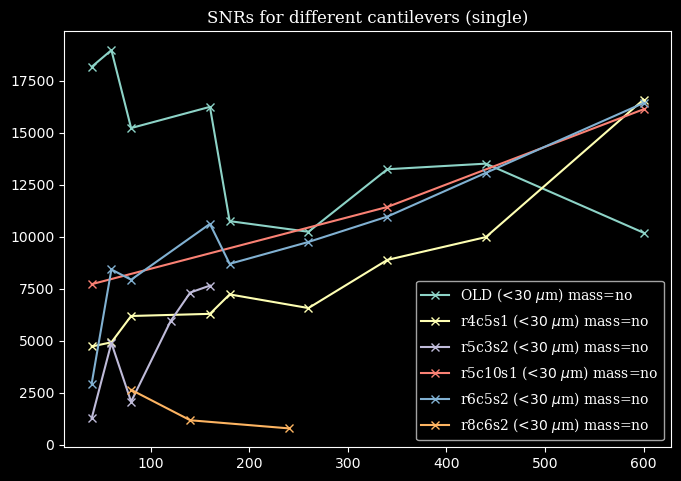

/tmp/ipykernel_2291/2409153111.py:248: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


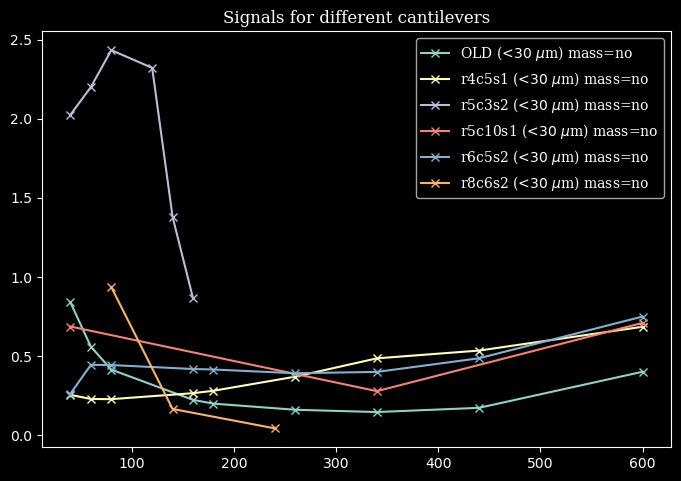

/tmp/ipykernel_2291/2409153111.py:269: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


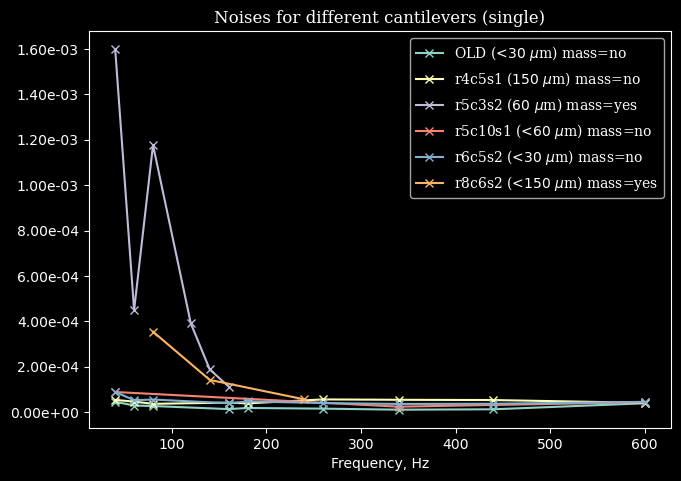

/tmp/ipykernel_2291/2409153111.py:291: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


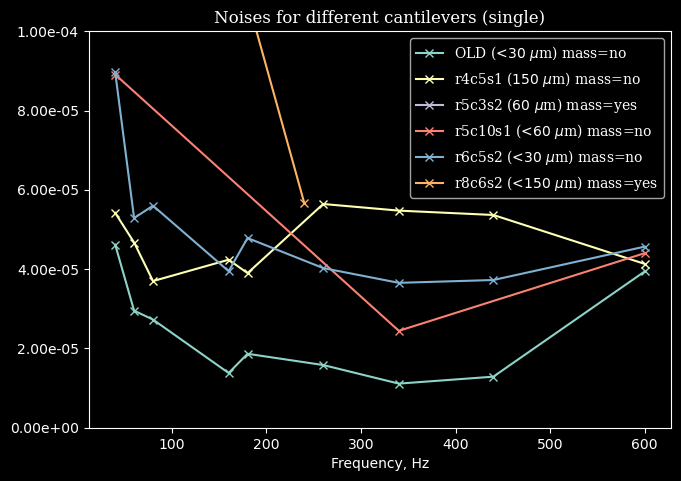

/tmp/ipykernel_2291/2409153111.py:309: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


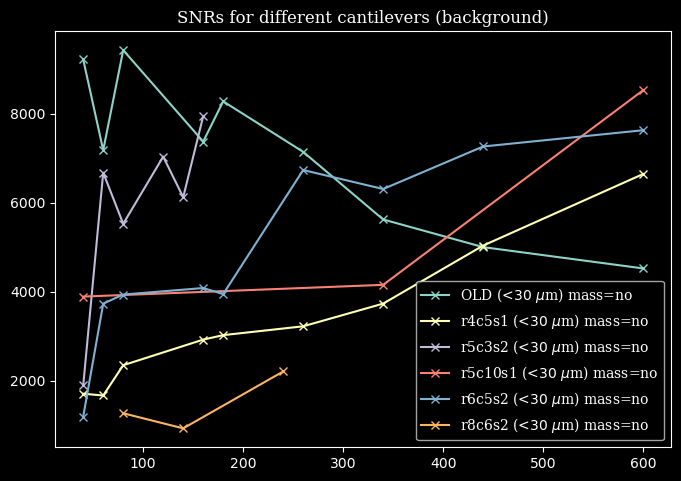

/tmp/ipykernel_2291/2409153111.py:328: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


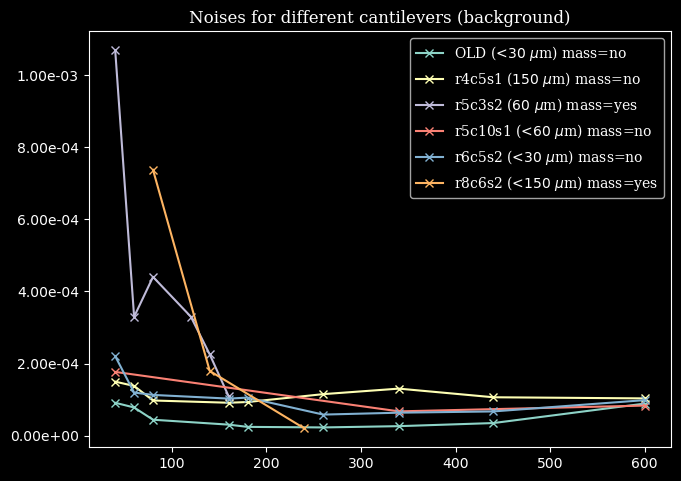

/tmp/ipykernel_2291/2409153111.py:348: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=5)


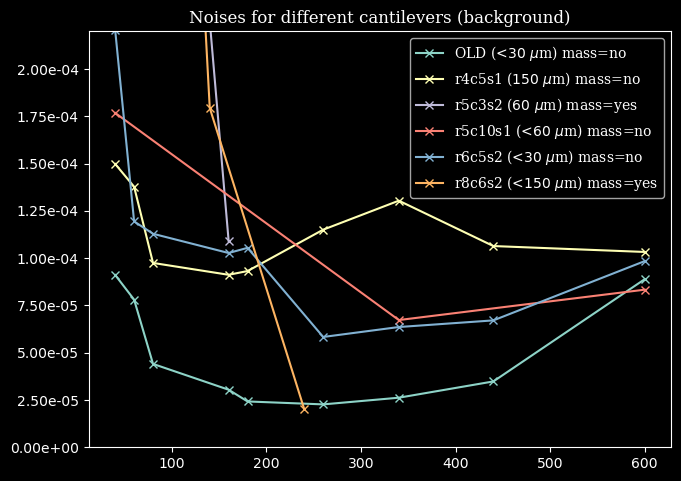

In [129]:
%matplotlib inline
# OLD OG cantilever
old_noise_start = 1625
old_noise_end = 1749
old_peak_start = 1449
old_peak_end = 1471

old_path = "./datas/benchmark/2/measurements/"
old_path_noise = "./datas/benchmark/2/noise/"
old_freqs = freq_list_2
old_press = pressure_list
old_patterns = cp.create_regex_strings(old_press, old_freqs)
old_test_bench_files = cp.dir_match_dict(old_path, old_patterns)


old_final = CEPAS_SNR_bench(old_test_bench_files,
                                bench_path=old_path,
                                noise_path=old_path_noise,
                                file_sig="gasx")

old_all = old_final.get_mag_snrs(old_peak_start,
                                     old_peak_end,
                                     n_knots=4)

old_signals = old_all[2]
old_noises = old_all[1]
old_snrs = old_all[0]

# R4C5S1 ($150\ \mu$m) mass=no
r4c5s1_noise_start = 1625
r4c5s1_noise_end = 1749
r4c5s1_peak_start = 1440
r4c5s1_peak_end = 1480

r4c5s1_path = "./datas/misc_tests/cantilevers/2025_09/R4C5_SOI1/"
r4c5s1_path_noise = r4c5s1_path + "noise-tests/"
r4c5s1_freqs = freq_list_2
r4c5s1_press = [900]
r4c5s1_patterns = cp.create_regex_strings(r4c5s1_press, r4c5s1_freqs)
r4c5s1_test_bench_files = cp.dir_match_dict(r4c5s1_path, r4c5s1_patterns)


r4c5s1_final = CEPAS_SNR_bench(r4c5s1_test_bench_files,
                                bench_path=r4c5s1_path,
                                noise_path=r4c5s1_path_noise,
                                file_sig="single")

r4c5s1_all = r4c5s1_final.get_mag_snrs(r4c5s1_peak_start,
                                     r4c5s1_peak_end,
                                     n_knots=4)

r4c5s1_signals = r4c5s1_all[2]
r4c5s1_noises = r4c5s1_all[1]
r4c5s1_snrs = r4c5s1_all[0]

# R5C3S2 ($60\ \mu$m) mass=yes
r5c3s2_noise_start = 1625
r5c3s2_noise_end = 1749
r5c3s2_peak_start = 1435
r5c3s2_peak_end = 1471

r5c3s2_path = "./datas/misc_tests/cantilevers/2025_09/R5C3_SOI2/"
r5c3s2_path_noise = r5c3s2_path + "noise-tests/"
r5c3s2_freqs = [60, 70, 80]
r5c3s2_press = [900]
r5c3s2_patterns = cp.create_regex_strings(r5c3s2_press, r5c3s2_freqs)
r5c3s2_test_bench_files = cp.dir_match_dict(r5c3s2_path, r5c3s2_patterns)


r5c3s2_final = CEPAS_SNR_bench(r5c3s2_test_bench_files,
                                bench_path=r5c3s2_path,
                                noise_path=r5c3s2_path_noise,
                                file_sig="single")

r5c3s2_all = r5c3s2_final.get_mag_snrs(r5c3s2_peak_start,
                                     r5c3s2_peak_end,
                                     n_knots=4)

r5c3s2_signals = r5c3s2_all[2]
r5c3s2_noises = r5c3s2_all[1]
r5c3s2_snrs = r5c3s2_all[0]

# R5C3S2 ($60\ \mu$m) mass=yes # Take two (20,30,40)
r5c3s2_2_noise_start = 1625
r5c3s2_2_noise_end = 1749
r5c3s2_2_peak_start = 1435
r5c3s2_2_peak_end = 1471

r5c3s2_2_path = "./datas/misc_tests/cantilevers/2025_09/R5C3_SOI2/"
r5c3s2_2_path_noise = r5c3s2_path + "noise-tests/"
r5c3s2_2_freqs = [20, 30, 40]
r5c3s2_2_press = [900]
r5c3s2_2_patterns = cp.create_regex_strings(r5c3s2_2_press, r5c3s2_2_freqs)
r5c3s2_2_test_bench_files = cp.dir_match_dict(r5c3s2_2_path, r5c3s2_2_patterns)


r5c3s2_2_final = CEPAS_SNR_bench(r5c3s2_2_test_bench_files,
                                bench_path=r5c3s2_2_path,
                                noise_path=r5c3s2_2_path_noise,
                                noise_number=2,
                                file_sig="single")

r5c3s2_2_all = r5c3s2_2_final.get_mag_snrs(r5c3s2_2_peak_start,
                                     r5c3s2_2_peak_end,
                                     n_knots=4)

r5c3s2_2_signals = r5c3s2_2_all[2]
r5c3s2_2_noises = r5c3s2_2_all[1]
r5c3s2_2_snrs = r5c3s2_2_all[0]

# R5C10S1 ($60\ \mu$m) mass=no
r5c10s1_noise_start = 1625
r5c10s1_noise_end = 1749
r5c10s1_peak_start = 1449
r5c10s1_peak_end = 1471

r5c10s1_path = "./datas/misc_tests/cantilevers/2025_09/R5C10_SOI1/"
r5c10s1_path_noise = r5c10s1_path + "noise-tests/"
r5c10s1_freqs = [20, 170, 300]
r5c10s1_press = [900]
r5c10s1_patterns = cp.create_regex_strings(r5c10s1_press, r5c10s1_freqs)
r5c10s1_test_bench_files = cp.dir_match_dict(r5c10s1_path, r5c10s1_patterns)


r5c10s1_final = CEPAS_SNR_bench(r5c10s1_test_bench_files,
                                bench_path=r5c10s1_path,
                                noise_path=r5c10s1_path_noise,
                                file_sig="single")

r5c10s1_all = r5c10s1_final.get_mag_snrs(r5c10s1_peak_start,
                                     r5c10s1_peak_end,
                                     n_knots=4)

r5c10s1_signals = r5c10s1_all[2]
r5c10s1_noises = r5c10s1_all[1]
r5c10s1_snrs = r5c10s1_all[0]

# R5C10S2 ($60\ \mu$m) mass=no
# Not good cantilever

# R6C5S2 ($30\ \mu$m) mass=no
r6c5s2_noise_start = 1625
r6c5s2_noise_end = 1749
r6c5s2_peak_start = 1449
r6c5s2_peak_end = 1471

r6c5s2_path = "./datas/misc_tests/cantilevers/2025_09/R6C5_SOI2/"
r6c5s2_path_noise = r6c5s2_path + "noise-tests/"
r6c5s2_freqs = freq_list_2
r6c5s2_press = [900]
r6c5s2_patterns = cp.create_regex_strings(r6c5s2_press, r6c5s2_freqs)
r6c5s2_test_bench_files = cp.dir_match_dict(r6c5s2_path, r6c5s2_patterns)


r6c5s2_final = CEPAS_SNR_bench(r6c5s2_test_bench_files,
                                bench_path=r6c5s2_path,
                                noise_path=r6c5s2_path_noise,
                                file_sig="single")

r6c5s2_all = r6c5s2_final.get_mag_snrs(r6c5s2_peak_start,
                                     r6c5s2_peak_end,
                                     n_knots=4)

r6c5s2_signals = r6c5s2_all[2]
r6c5s2_noises = r6c5s2_all[1]
r6c5s2_snrs = r6c5s2_all[0]

# R8C6S2 ($150\ \mu$m) mass=yes
r8c6s2_noise_start = 1625
r8c6s2_noise_end = 1749
r8c6s2_peak_start = 1435
r8c6s2_peak_end = 1471

r8c6s2_path = "./datas/misc_tests/cantilevers/2025_09/R8C6_SOI2/"
r8c6s2_path_noise = r8c6s2_path + "noise-tests/"
r8c6s2_freqs = [40, 70, 120]
r8c6s2_press = [900]
r8c6s2_patterns = cp.create_regex_strings(r8c6s2_press, r8c6s2_freqs)
r8c6s2_test_bench_files = cp.dir_match_dict(r8c6s2_path, r8c6s2_patterns)


r8c6s2_final = CEPAS_SNR_bench(r8c6s2_test_bench_files,
                                bench_path=r8c6s2_path,
                                noise_path=r8c6s2_path_noise,
                                file_sig="single")

r8c6s2_all = r8c6s2_final.get_mag_snrs(r8c6s2_peak_start,
                                     r8c6s2_peak_end,
                                     n_knots=4)

r8c6s2_signals = r8c6s2_all[2]
r8c6s2_noises = r8c6s2_all[1]
r8c6s2_snrs = r8c6s2_all[0]


old_freqs = [f*2 for f in old_freqs]
r4c5s1_freqs = [f*2 for f in r4c5s1_freqs]
r5c3s2_freqs = r5c3s2_2_freqs + r5c3s2_freqs
r5c3s2_freqs = [f*2 for f in r5c3s2_freqs]
r5c10s1_freqs = [f*2 for f in r5c10s1_freqs]
r6c5s2_freqs = [f*2 for f in r6c5s2_freqs]
r8c6s2_freqs = [f*2 for f in r8c6s2_freqs]
r5c3s2_2_freqs = [f*2 for f in r5c3s2_2_freqs]


r5c3s2_noises = pd.concat([r5c3s2_2_noises, r5c3s2_noises])
r5c3s2_signals = pd.concat([r5c3s2_2_signals, r5c3s2_signals])
r5c3s2_snrs = pd.concat([r5c3s2_2_snrs, r5c3s2_snrs])

print(r5c3s2_freqs)
print(r5c3s2_noises)

plt.close()

plt.figure(figsize=(8, 6), constrained_layout=True)
font = font_manager.FontProperties(family='serif')

# snrs (single)
ax2 = plt.subplot(111)
ax2.set_title("SNRs for different cantilevers (single)", fontname="serif")

ax2.plot(old_freqs, [old_snrs[900][idx][0] for idx in old_snrs[900].index], "x-", label="OLD (<$30\\ \\mu$m) mass=no")
ax2.plot(r4c5s1_freqs, [r4c5s1_snrs[900][idx][0] for idx in r4c5s1_snrs[900].index], "x-", label="r4c5s1 (<$30\\ \\mu$m) mass=no")
ax2.plot(r5c3s2_freqs, [r5c3s2_snrs[900][idx][0] for idx in r5c3s2_snrs[900].index], "x-", label="r5c3s2 (<$30\\ \\mu$m) mass=no")
ax2.plot(r5c10s1_freqs, [r5c10s1_snrs[900][idx][0] for idx in r5c10s1_snrs[900].index], "x-", label="r5c10s1 (<$30\\ \\mu$m) mass=no")
ax2.plot(r6c5s2_freqs, [r6c5s2_snrs[900][idx][0] for idx in r6c5s2_snrs[900].index], "x-", label="r6c5s2 (<$30\\ \\mu$m) mass=no")
ax2.plot(r8c6s2_freqs, [r8c6s2_snrs[900][idx][0] for idx in r8c6s2_snrs[900].index], "x-", label="r8c6s2 (<$30\\ \\mu$m) mass=no")
ax2.legend(prop=font)

plt.tight_layout(pad=5)
plt.show()

# signals
plt.figure(figsize=(8, 6), constrained_layout=True)
font = font_manager.FontProperties(family='serif')

ax0 = plt.subplot(111)
ax0.set_title("Signals for different cantilevers", fontname="serif")

ax0.plot(old_freqs, [old_signals[900][idx][0] for idx in old_signals[900].index], "x-", label="OLD (<$30\\ \\mu$m) mass=no")
ax0.plot(r4c5s1_freqs, [r4c5s1_signals[900][idx][0] for idx in r4c5s1_signals[900].index], "x-", label="r4c5s1 (<$30\\ \\mu$m) mass=no")
ax0.plot(r5c3s2_freqs, [r5c3s2_signals[900][idx][0] for idx in r5c3s2_signals[900].index], "x-", label="r5c3s2 (<$30\\ \\mu$m) mass=no")
ax0.plot(r5c10s1_freqs, [r5c10s1_signals[900][idx][0] for idx in r5c10s1_signals[900].index], "x-", label="r5c10s1 (<$30\\ \\mu$m) mass=no")
ax0.plot(r6c5s2_freqs, [r6c5s2_signals[900][idx][0] for idx in r6c5s2_signals[900].index], "x-", label="r6c5s2 (<$30\\ \\mu$m) mass=no")
ax0.plot(r8c6s2_freqs, [r8c6s2_signals[900][idx][0] for idx in r8c6s2_signals[900].index], "x-", label="r8c6s2 (<$30\\ \\mu$m) mass=no")
ax0.legend(prop=font)

plt.tight_layout(pad=5)
plt.show()

# noises (single)
plt.figure(figsize=(8, 6), constrained_layout=True)
font = font_manager.FontProperties(family='serif')

ax1 = plt.subplot(111)
ax1.set_title("Noises for different cantilevers (single)", fontname="serif")
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

ax1.plot(old_freqs, [old_noises[900][idx][0] for idx in old_noises[900].index], "x-", label="OLD (<$30\\ \\mu$m) mass=no")
ax1.plot(r4c5s1_freqs, [r4c5s1_noises[900][idx][0] for idx in r4c5s1_noises[900].index], "x-", label="r4c5s1 ($150\\ \\mu$m) mass=no")
ax1.plot(r5c3s2_freqs, [r5c3s2_noises[900][idx][0] for idx in r5c3s2_noises[900].index], "x-", label="r5c3s2 ($60\\ \\mu$m) mass=yes")
ax1.plot(r5c10s1_freqs, [r5c10s1_noises[900][idx][0] for idx in r5c10s1_noises[900].index], "x-", label="r5c10s1 (<$60\\ \\mu$m) mass=no")
ax1.plot(r6c5s2_freqs, [r6c5s2_noises[900][idx][0] for idx in r6c5s2_noises[900].index], "x-", label="r6c5s2 (<$30\\ \\mu$m) mass=no")
ax1.plot(r8c6s2_freqs, [r8c6s2_noises[900][idx][0] for idx in r8c6s2_noises[900].index], "x-", label="r8c6s2 (<$150\\ \\mu$m) mass=yes")

ax1.legend(prop=font)
ax1.set_xlabel("Frequency, Hz")

plt.tight_layout(pad=5)
plt.show()

# noises (single) zoom
plt.figure(figsize=(8, 6), constrained_layout=True)
font = font_manager.FontProperties(family='serif')

ax1_2 = plt.subplot(111)
ax1_2.set_title("Noises for different cantilevers (single)", fontname="serif")
ax1_2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

ax1_2.plot(old_freqs, [old_noises[900][idx][0] for idx in old_noises[900].index], "x-", label="OLD (<$30\\ \\mu$m) mass=no")
ax1_2.plot(r4c5s1_freqs, [r4c5s1_noises[900][idx][0] for idx in r4c5s1_noises[900].index], "x-", label="r4c5s1 ($150\\ \\mu$m) mass=no")
ax1_2.plot(r5c3s2_freqs, [r5c3s2_noises[900][idx][0] for idx in r5c3s2_noises[900].index], "x-", label="r5c3s2 ($60\\ \\mu$m) mass=yes")
ax1_2.plot(r5c10s1_freqs, [r5c10s1_noises[900][idx][0] for idx in r5c10s1_noises[900].index], "x-", label="r5c10s1 (<$60\\ \\mu$m) mass=no")
ax1_2.plot(r6c5s2_freqs, [r6c5s2_noises[900][idx][0] for idx in r6c5s2_noises[900].index], "x-", label="r6c5s2 (<$30\\ \\mu$m) mass=no")
ax1_2.plot(r8c6s2_freqs, [r8c6s2_noises[900][idx][0] for idx in r8c6s2_noises[900].index], "x-", label="r8c6s2 (<$150\\ \\mu$m) mass=yes")

ax1_2.legend(prop=font)
ax1_2.set_xlabel("Frequency, Hz")
ax1_2.set_ylim((0, 1e-4))

plt.tight_layout(pad=5)
plt.show()

# snrs (background)
plt.figure(figsize=(8, 6), constrained_layout=True)
font = font_manager.FontProperties(family='serif')

ax3 = plt.subplot(111)
ax3.set_title("SNRs for different cantilevers (background)", fontname="serif")

ax3.plot(old_freqs, [old_snrs[900][idx][1] for idx in old_snrs[900].index], "x-", label="OLD (<$30\\ \\mu$m) mass=no")
ax3.plot(r4c5s1_freqs, [r4c5s1_snrs[900][idx][1] for idx in r4c5s1_snrs[900].index], "x-", label="r4c5s1 (<$30\\ \\mu$m) mass=no")
ax3.plot(r5c3s2_freqs, [r5c3s2_snrs[900][idx][1] for idx in r5c3s2_snrs[900].index], "x-", label="r5c3s2 (<$30\\ \\mu$m) mass=no")
ax3.plot(r5c10s1_freqs, [r5c10s1_snrs[900][idx][1] for idx in r5c10s1_snrs[900].index], "x-", label="r5c10s1 (<$30\\ \\mu$m) mass=no")
ax3.plot(r6c5s2_freqs, [r6c5s2_snrs[900][idx][1] for idx in r6c5s2_snrs[900].index], "x-", label="r6c5s2 (<$30\\ \\mu$m) mass=no")
ax3.plot(r8c6s2_freqs, [r8c6s2_snrs[900][idx][1] for idx in r8c6s2_snrs[900].index], "x-", label="r8c6s2 (<$30\\ \\mu$m) mass=no")
ax3.legend(prop=font)

plt.tight_layout(pad=5)
plt.show()

# noises (background)
plt.figure(figsize=(8, 6), constrained_layout=True)
font = font_manager.FontProperties(family='serif')

ax4 = plt.subplot(111)
ax4.set_title("Noises for different cantilevers (background)", fontname="serif")
ax4.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

ax4.plot(old_freqs, [old_noises[900][idx][1] for idx in old_noises[900].index], "x-", label="OLD (<$30\\ \\mu$m) mass=no")
ax4.plot(r4c5s1_freqs, [r4c5s1_noises[900][idx][1] for idx in r4c5s1_noises[900].index], "x-", label="r4c5s1 ($150\\ \\mu$m) mass=no")
ax4.plot(r5c3s2_freqs,[r5c3s2_noises[900][idx][1] for idx in r5c3s2_noises[900].index], "x-", label="r5c3s2 ($60\\ \\mu$m) mass=yes")
ax4.plot(r5c10s1_freqs, [r5c10s1_noises[900][idx][1] for idx in r5c10s1_noises[900].index], "x-", label="r5c10s1 (<$60\\ \\mu$m) mass=no")
ax4.plot(r6c5s2_freqs, [r6c5s2_noises[900][idx][1] for idx in r6c5s2_noises[900].index], "x-", label="r6c5s2 (<$30\\ \\mu$m) mass=no")
ax4.plot(r8c6s2_freqs, [r8c6s2_noises[900][idx][1] for idx in r8c6s2_noises[900].index], "x-", label="r8c6s2 (<$150\\ \\mu$m) mass=yes")
ax4.legend(prop=font)

plt.tight_layout(pad=5)
plt.show()

# noises (background) zoom
plt.figure(figsize=(8, 6), constrained_layout=True)
font = font_manager.FontProperties(family='serif')

ax4 = plt.subplot(111)
ax4.set_title("Noises for different cantilevers (background)", fontname="serif")
ax4.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

ax4.plot(old_freqs, [old_noises[900][idx][1] for idx in old_noises[900].index], "x-", label="OLD (<$30\\ \\mu$m) mass=no")
ax4.plot(r4c5s1_freqs, [r4c5s1_noises[900][idx][1] for idx in r4c5s1_noises[900].index], "x-", label="r4c5s1 ($150\\ \\mu$m) mass=no")
ax4.plot(r5c3s2_freqs,[r5c3s2_noises[900][idx][1] for idx in r5c3s2_noises[900].index], "x-", label="r5c3s2 ($60\\ \\mu$m) mass=yes")
ax4.plot(r5c10s1_freqs, [r5c10s1_noises[900][idx][1] for idx in r5c10s1_noises[900].index], "x-", label="r5c10s1 (<$60\\ \\mu$m) mass=no")
ax4.plot(r6c5s2_freqs, [r6c5s2_noises[900][idx][1] for idx in r6c5s2_noises[900].index], "x-", label="r6c5s2 (<$30\\ \\mu$m) mass=no")
ax4.plot(r8c6s2_freqs, [r8c6s2_noises[900][idx][1] for idx in r8c6s2_noises[900].index], "x-", label="r8c6s2 (<$150\\ \\mu$m) mass=yes")
ax4.legend(prop=font)
ax4.set_ylim((0, 2.2e-4))

plt.tight_layout(pad=5)
plt.show()

# Whiteboard

In [82]:
%matplotlib inline
def offs2uvolts(stock):
    return (stock-768)/10*1000+37000

print(f"min: {offs2uvolts(1300)/1000} mV\nmax: {offs2uvolts(2130)/1000} mV\n")

min: 90.2 mV
max: 173.2 mV



In [83]:
# q1_list = []
# q3_list = []

# for i in range(10000):
#     numbers = np.random.normal(0, 0.5, 10000)
#     x = list(range(len(numbers)))
#     df = pd.DataFrame(
#         {
#             'x': x,
#             'y': numbers
#         }
#     )

#     Q1 = df.y.quantile(1/3/2)
#     Q3 = df.y.quantile(1-(1/3/2))
#     q1_list.append(Q1)
#     q3_list.append(Q3)

# print(np.array(q1_list).mean())
# print(np.array(q3_list).mean())
# plt.close()
# plt.figure()
# # plt.hist(numbers, 50)
# plt.plot(df.x, df.y)
# plt.show()

In [84]:
R = 100e6
S = 3968
tau = 10
1/(R/2**tau)*S

0.04063232

In [85]:
offsets_dec = [768.0, 2130.0]
scope = [37.0, 182.0]
_, a, b = cp.get_wavenumber(1, scope, offsets_dec)
val1 = 189.0 + 1.25
val2 = 189.0 - 1.25
val1_offset = a*val1 + b
val2_offset = a*val2 + b
f1 = cp.get_wavenumber(val1_offset, units1, units2)
f2 = cp.get_wavenumber(val2_offset, units1, units2)
print(f2[0]-f1[0])

0.08271534728373808


In [86]:
diff88_8 = cp.subtract_hex("00088", "00008")
int(diff88_8, 16)/8

16.0

In [87]:
def f(x):
    return x

interact(f, x=10)



interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

<function __main__.f(x)>

In [88]:
np.round(np.geomspace(32, 300, 9, endpoint=True))

array([ 32.,  42.,  56.,  74.,  98., 130., 171., 227., 300.])

# Misc

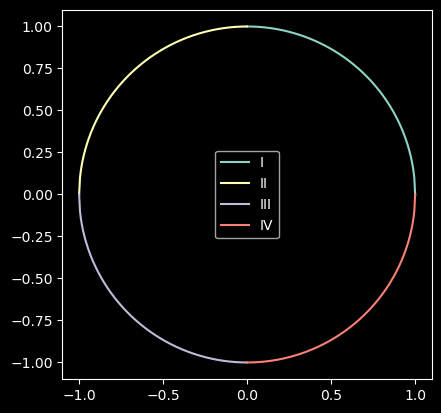

In [89]:
plt.close()
r = 1
A = np.pi * r**2
x_arr = np.linspace(0.001, 1, 200)
def circle(x, r=1.0):
    expression = r - np.pow(x, 2)
    return np.sqrt(expression)

# print(x_arr)
plt.figure()
plt.gca().set_aspect('equal')
plt.plot(x_arr, circle(x_arr, r), label="I")
plt.plot(-x_arr, circle(x_arr, r), label="II")
plt.plot(-x_arr, -circle(x_arr, r), label="III")
plt.plot(x_arr, -circle(x_arr, r), label="IV")
plt.legend()
plt.show()

In [90]:
area_test, err = quad(circle, 0, 1, args=(1,))
print(round(4*area_test, 14))
print(round(np.pi, 14))


3.14159265358979
3.14159265358979


In [91]:
def custom_integral(f, x1, x0=0, step_denominator=1e6):
    dx = 1/step_denominator
    x_values = np.linspace(x0+dx, x1, int(step_denominator))
    return np.sum(f(x_values, x1)*dx)

4*custom_integral(f=circle, x1=1.0)

np.float64(3.141590652413811)

# Tutorials

## `scipy.signal.find_peaks`

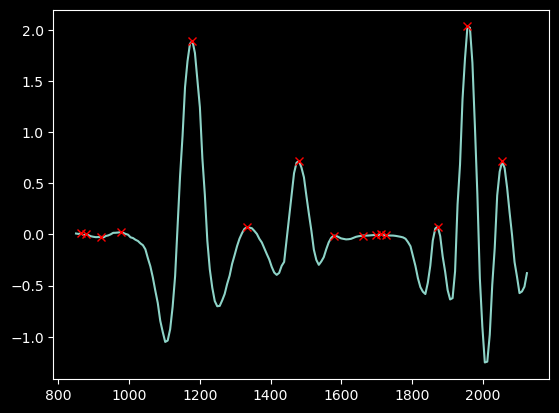

time  offset1     P1     H3     H2  P_las  T_las     RH  Pressure  \
1    False    False  False  False  False  False  False  False     False   
2    False    False  False  False  False  False  False  False     False   
3    False    False  False  False  False  False  False  False     False   
4    False    False  False  False  False  False  False  False     False   
5    False    False  False  False  False  False  False  False     False   
..     ...      ...    ...    ...    ...    ...    ...    ...       ...   
179  False    False  False  False  False  False  False  False     False   
180  False    False  False  False  False  False  False  False     False   
181  False    False  False  False  False  False  False  False     False   
182  False    False  False  False  False  False  False  False     False   
183  False    False  False  False  False  False  False  False     False   

     time_subtracted  H2_pnorm  H3_pnorm  
1              False     False     False  
2              False     False     False  
3              False     False     False  
4              False     False     False  
5              False     False     False  
..               ...       ...       ...  
179            False     False     False  
180            False     False     False  
181            False     False     False  
182            False     False     False  
183            False     False     False  

[183 rows x 12 columns]

In [92]:
df = cm_22deg_600.spectra_list[0]
test_peaks, _ = find_peaks(df['H2_pnorm'])

plt.close()
plt.figure()
plt.plot(df['offset1'], df['H2_pnorm'])
plt.plot(df['offset1'].iloc[test_peaks], df['H2_pnorm'].iloc[test_peaks], 'rx')
plt.show()
# test_peaks[0]
# df.loc[1,:]
# df_peaks
df.isna()

## `lmfit`

[[Model]]
    ((Model(voigt, prefix='v1_') + Model(voigt, prefix='v2_')) + Model(constant, prefix='const_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 1001
    # variables        = 8
    chi-square         = 42.2860346
    reduced chi-square = 0.04258412
    Akaike info crit   = -3151.46220
    Bayesian info crit = -3112.19216
    R-squared          = 0.97912586
[[Variables]]
    v1_amplitude:  14.5263544 +/- 0.16703544 (1.15%) (init = 28.59745)
    v1_center:     9000.00339 +/- 0.00543357 (0.00%) (init = 9000.025)
    v1_sigma:      0.56793148 +/- 0.01423603 (2.51%) (init = 0.50375)
    v1_gamma:      0.21783289 +/- 0.02037281 (9.35%) (init = 0.50375)
    v1_fwhm:       1.58555505 +/- 0.01525624 (0.96%) == '1.0692*v1_gamma+sqrt(0.8664*v1_gamma**2+5.545083*v1_sigma**2)'
    v1_height:     7.70238578 +/- 0.05633235 (0.73%) == '(v1_amplitude/(max(1e-15, v1_sigma*sqrt(2*pi))))*real(wofz((1j*v1_gamma)/(max(1e-15, v1_sigma*sqrt(

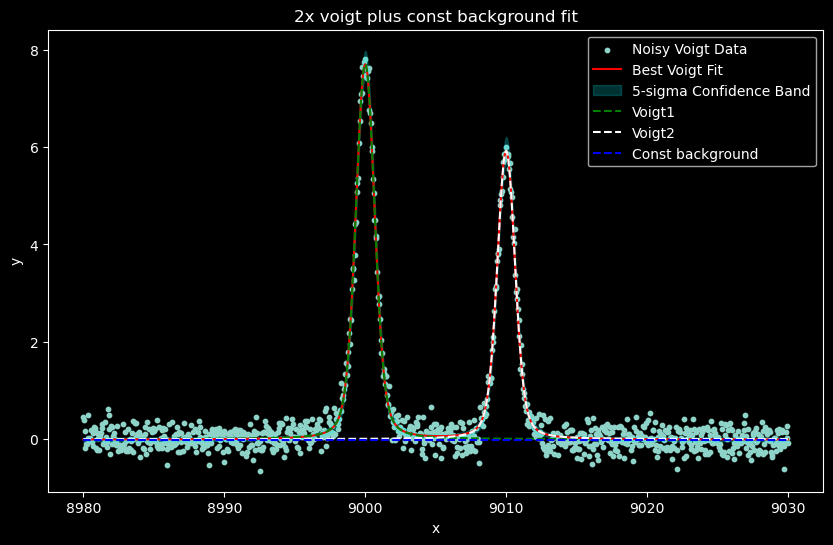

In [93]:
x = np.linspace(8980, 9030, 1001) # creating x axis linspave

# defining true params for arbitrary simulation
voigt1_true = {'amplitude': 15.0, 'center': 9000, 'sigma': 0.5, 'gamma': 0.3}
voigt2_true = {'amplitude': 10.0, 'center': 9010, 'sigma': 0.6, 'gamma': 0.1}
const_true = {'offs': 1.5}

# creating 'true' data for arbitrary somulation on x axis
y = np.asarray(VoigtModel().eval(x=x, **voigt1_true)) +\
    np.asarray(VoigtModel().eval(x=x, **voigt2_true)) +\
    np.asarray(ConstantModel().eval(x=x, **const_true))

# creating noise and adding it to 'true' data
noise = np.random.normal(0, 0.2, size=x.size)
y_noisy = y + noise

# creating model to fit, using custom prefixes for easier param ID later
m1 = VoigtModel(prefix='v1_')
m2 = VoigtModel(prefix='v2_')
m3 = ConstantModel(prefix='const_')
model = m1 + m2 + m3

# defining initial guesses (close to 'true' params)
p1 = m1.guess(y_noisy[300:500], x=x[300:500])
p2 = m2.guess(y_noisy[500:], x=x[500:])
p3 = m3.guess(y_noisy[0:300], x=x[0:300])
params = p1 + p2 + p3

# setting off from the default sigma=gamma by enabling gamma variation
params['v1_gamma'].set(vary=True)
params['v2_gamma'].set(expr='v1_gamma')

# calling the fit
result = model.fit(y_noisy, params, x=x)

# confidence bands
confidence_sigma = 5
dely = result.eval_uncertainty(sigma=confidence_sigma)

# extracting individual components from the composite model
comps = result.eval_components()

# creating fit report
print(result.fit_report())
# print(result.conf_interval())
plt.close()
plt.figure(figsize=(10, 6))
plt.scatter(x, y_noisy, label='Noisy Voigt Data', s=10)
plt.plot(x, result.best_fit, 'r-', label='Best Voigt Fit')
plt.fill_between(
    x, result.best_fit - dely, result.best_fit + dely,
    color='cyan', alpha=0.2,
    label=f'{confidence_sigma}-sigma Confidence Band')
plt.plot(x, comps['v1_'], 'g--', label='Voigt1')
plt.plot(x, comps['v2_'], 'w--', label='Voigt2')
plt.plot(x, comps['const_'], 'b--', label='Const background')

plt.xlabel('x')
plt.ylabel('y')
plt.title('2x voigt plus const background fit')
plt.legend()
# plt.xlim(8995, 9005)
plt.show()

[[Model]]
    Model(spline_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 101
    # variables        = 15
    chi-square         = 0.71515038
    reduced chi-square = 0.00831570
    Akaike info crit   = -469.988679
    Bayesian info crit = -430.761871
    R-squared          = 0.98427930
[[Variables]]
    s0:  -0.10515630 +/- 0.06599500 (62.76%) (init = -0.0773336)
    s1:   0.54050661 +/- 0.10250762 (18.97%) (init = 0.6203149)
    s2:   1.15147707 +/- 0.09981048 (8.67%) (init = 1.034262)
    s3:   0.99402007 +/- 0.07165315 (7.21%) (init = 0.9032417)
    s4:   0.07443609 +/- 0.07478255 (100.47%) (init = 0.1351993)
    s5:  -0.26530318 +/- 0.07571908 (28.54%) (init = -0.3920092)
    s6:  -1.02394169 +/- 0.07598303 (7.42%) (init = -0.993412)
    s7:  -0.95521181 +/- 0.07603810 (7.96%) (init = -1.027185)
    s8:  -0.73427907 +/- 0.07598303 (10.35%) (init = -0.6745006)
    s9:   0.15739231 +/- 0.07571908 (48.11%) (init = 0.109

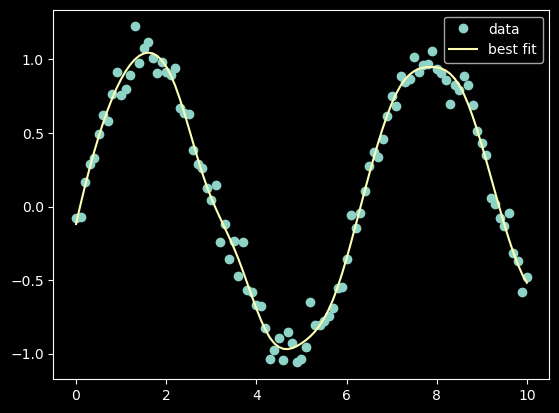

In [94]:
# Generate some sample data
x = np.linspace(0, 10, 101)
y = np.sin(x) + np.random.normal(scale=0.1, size=x.size)

# Create a SplineModel with 7 knots
smodel = SplineModel(xknots=np.linspace(0.01, 9.99, 15))

# Generate initial parameters
params = smodel.guess(y, x=x)

# Fit the model to the data
result = smodel.fit(y, params, x=x)

# Print the fit report
print(result.fit_report())

# Plot the results
plt.close()
plt.figure()
plt.plot(x, y, 'o', label='data')
plt.plot(x, result.best_fit, '-', label='best fit')
plt.legend()
plt.show()

## Itertools and functools

In [95]:
def even_gen():
    start = 0
    even_counter = itertools.count(start, 2)
    for n in even_counter:
        yield n

print(next(even_gen()))
print(next(even_gen()))
print(next(even_gen()))

0
0
0
